# Analysez des données de systèmes éducatifs

## 0 - Rappel du sujet

Vous êtes Data Scientist dans une start-up de la EdTech, nommée academy, qui propose des contenus de formation en ligne pour un public de niveau lycée et université. 

Mark, votre manager, vous a convié à une réunion pour vous présenter le projet d’expansion à l’international de l’entreprise. Il vous confie une première mission d’analyse exploratoire, pour déterminer si les données sur l’éducation de la banque mondiale permettent d’informer le projet d’expansio
 

Mark aimerait explorer les pays avec un fort potentiel de clients pour les services de academy, et comment ce potentiel pourrait évol
er. 


## 1 - Analyse générale des données

Le jeu de données à analyser contient 5 fichiers :
- EdStatsCountry : ce fichier contient la liste des pays, leur zone géographique, le groupe de revenus.
- EdStatsCountry-Series : ce fichier donne des indications par pays sur la source des indicateurs, et le périmètre (exemple pour la France, les chiffres inclus la Guyane, la Guadeloupe,..). Il ne sera analysé par la suite.
- EdStatsData : il s'agit du fichier principal où se trouve les valorisations des indicateurs par pays et par année.
- EdStatsFootNote : ce fichier indique la source des données de chaque indicateur valorisé par pays. A ce stade de l'analyse, son contenu n'est pas utile pour répondre à la problématique. Il ne sera donc pas détaillé ci-dessous.
- EdStatsSeries : ce fichier contient la liste exhaustive de tous les indicateurs avec leur description.


### 1.1 - Analyse du fichier EdStatsCountry

#### 1.1.1 - Manipulation du fichier avec python et premiers constats

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy.stats as st
import statsmodels.api as sm

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

In [8]:
# Charger le fichier de données
countries = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_2/datas_education/EdStatsCountry.csv")
countries.head()

Country Code   Short Name   Table Name                     Long Name  \
0          ABW        Aruba        Aruba                         Aruba   
1          AFG  Afghanistan  Afghanistan  Islamic State of Afghanistan   
2          AGO       Angola       Angola   People's Republic of Angola   
3          ALB      Albania      Albania           Republic of Albania   
4          AND      Andorra      Andorra       Principality of Andorra   

  2-alpha code   Currency Unit  \
0           AW   Aruban florin   
1           AF  Afghan afghani   
2           AO  Angolan kwanza   
3           AL    Albanian lek   
4           AD            Euro   

                                       Special Notes  \
0  SNA data for 2000-2011 are updated from offici...   
1  Fiscal year end: March 20; reporting period fo...   
2  April 2013 database update: Based on IMF data,...   
3                                                NaN   
4                                                NaN   

                      Region          Income Group WB-2 code  \
0  Latin America & Caribbean  High income: nonOECD        AW   
1                 South Asia            Low income        AF   
2         Sub-Saharan Africa   Upper middle income        AO   
3      Europe & Central Asia   Upper middle income        AL   
4      Europe & Central Asia  High income: nonOECD        AD   

                         National accounts base year  \
0                                               2000   
1                                            2002/03   
2                                               2002   
3  Original chained constant price data are resca...   
4                                               1990   

   National accounts reference year                   SNA price valuation  \
0                               NaN     Value added at basic prices (VAB)   
1                               NaN     Value added at basic prices (VAB)   
2                               NaN  Value added at producer prices (VAP)   
3                            1996.0     Value added at basic prices (VAB)   
4                               NaN                                   NaN   

  Lending category Other groups  \
0              NaN          NaN   
1              IDA         HIPC   
2             IBRD          NaN   
3             IBRD          NaN   
4              NaN          NaN   

                         System of National Accounts  \
0  Country uses the 1993 System of National Accou...   
1  Country uses the 1993 System of National Accou...   
2  Country uses the 1993 System of National Accou...   
3  Country uses the 1993 System of National Accou...   
4  Country uses the 1968 System of National Accou...   

  Alternative conversion factor PPP survey year  \
0                           NaN             NaN   
1                           NaN             NaN   
2                       1991–96            2005   
3                           NaN         Rolling   
4                           NaN             NaN   

              Balance of Payments Manual in use  \
0  IMF Balance of Payments Manual, 6th edition.   
1                                           NaN   
2  IMF Balance of Payments Manual, 6th edition.   
3  IMF Balance of Payments Manual, 6th edition.   
4                                           NaN   

  External debt Reporting status       System of trade  \
0                            NaN  Special trade system   
1                         Actual  General trade system   
2                         Actual  Special trade system   
3                         Actual  General trade system   
4                            NaN  Special trade system   

     Government Accounting concept           IMF data dissemination standard  \
0                              NaN                                       NaN   
1  Consolidated central government  General Data Dissemination System (GDDS)   
2     Budgetary central government  General Data Dissemination System (GDDS)   

In [9]:
# nombre de pays dans le dataframe
print("Il y a", countries.shape[0], "pays dans le fichier (nbre de lignes)")
print("Il y a", countries.shape[1], "colonnes")

Il y a 241 pays dans le fichier (nbre de lignes)
Il y a 32 colonnes


In [10]:
# identifier le nombre de valeurs manquantes par variable
print("Nombre de valeurs manquantes par colonnes")
print(countries.isnull().sum())
# constat :
## Il y a 32 colonnes, mais la plupart des colonnes contiennent des valeurs manquantes
## on peut utiliser le country code, le nom long ou court
## 27 pays sans région

Nombre de valeurs manquantes par colonnes
Country Code                                           0
Short Name                                             0
Table Name                                             0
Long Name                                              0
2-alpha code                                           3
Currency Unit                                         26
Special Notes                                         96
Region                                                27
Income Group                                          27
WB-2 code                                              1
National accounts base year                           36
National accounts reference year                     209
SNA price valuation                                   44
Lending category                                      97
Other groups                                         183
System of National Accounts                           26
Alternative conversion factor                 

In [11]:
# Identifier les "pays" sans région
mask = countries['Region'].isnull()
paysSansRegion = countries.loc[mask, 'Short Name']
print(paysSansRegion)
# Constat :
## les pays sans région ne sont pas des pays, hormis Nauru (pays d'océanie - East Asia & Pacific) qu'on peut corriger manuellement par la suite, 
## mais ce n'est pas utile, car Nauru est un pays de moins de 10 000 habitants, sur une île isolée.


5                                          Arab World
57              East Asia & Pacific (developing only)
58            East Asia & Pacific (all income levels)
59            Europe & Central Asia (developing only)
60          Europe & Central Asia (all income levels)
63                                          Euro area
68                                     European Union
78                                          Gibraltar
89                                        High income
92             Heavily indebted poor countries (HIPC)
116       Latin America & Caribbean (developing only)
122     Latin America & Caribbean (all income levels)
123      Least developed countries: UN classification
124                                        Low income
127                               Lower middle income
128                               Low & middle income
140    Middle East & North Africa (all income levels)
143                                     Middle income
148      Middle East & North

In [12]:
# Identifier la liste des régions
regions = countries['Region'].unique()
print(regions)
# Constat :
## il y a 7 régions dont voici la liste
## Ces régions pourront être utilisées par la suite
## Il faudra tout de même séparer les pays d'Europe de ceux d'Asie Central car on sent qu'il y aura de gros écarts entre les pays d'Europe et ceux d'Asie Central
mask = countries['Region'] == 'Europe & Central Asia'
print(countries.loc[mask, "Short Name"])

## Les pays suivants devront être rattachés à l'Asie Centrale :
#Armenia
#Azerbaijan
#Georgia
#Kazakhstan
#Tajikistan
#Turkmenistan
#Turkey
#Uzbekistan
#Kyrgyz Republic

['Latin America & Caribbean' 'South Asia' 'Sub-Saharan Africa'
 'Europe & Central Asia' nan 'Middle East & North Africa'
 'East Asia & Pacific' 'North America']
3                     Albania
4                     Andorra
8                     Armenia
12                    Austria
13                 Azerbaijan
15                    Belgium
19                   Bulgaria
22     Bosnia and Herzegovina
23                    Belarus
34                Switzerland
35            Channel Islands
49                     Cyprus
50             Czech Republic
51                    Germany
54                    Denmark
65                      Spain
66                    Estonia
69                    Finland
71                     France
72             Faeroe Islands
75             United Kingdom
76                    Georgia
83                     Greece
85                  Greenland
93                    Croatia
95                    Hungary
97                Isle of Man
99                    Ireland

In [13]:
# rechercher les doublons
countries.duplicated()

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
30     False
31     False
32     False
33     False
34     False
35     False
36     False
37     False
38     False
39     False
40     False
41     False
42     False
43     False
44     False
45     False
46     False
47     False
48     False
49     False
50     False
51     False
52     False
53     False
54     False
55     False
56     False
57     False
58     False
59     False
60     False
61     False
62     False
63     False
64     False
65     False
66     False
67     False
68     False
69     False
70     False
71     False
72     False
73     False
74     False
75     False
76     False

In [14]:
mask1 = countries['Short Name'].duplicated(keep=False)
countries.loc[mask1,:]
# Constat :
## Pas de de doublons sur le nom court du pays

Empty DataFrame
Columns: [Country Code, Short Name, Table Name, Long Name, 2-alpha code, Currency Unit, Special Notes, Region, Income Group, WB-2 code, National accounts base year, National accounts reference year, SNA price valuation, Lending category, Other groups, System of National Accounts, Alternative conversion factor, PPP survey year, Balance of Payments Manual in use, External debt Reporting status, System of trade, Government Accounting concept, IMF data dissemination standard, Latest population census, Latest household survey, Source of most recent Income and expenditure data, Vital registration complete, Latest agricultural census, Latest industrial data, Latest trade data, Latest water withdrawal data, Unnamed: 31]
Index: []

In [15]:
# Calculer les effectifs par groupe de revenus

effectifs_grp_revenus = countries['Income Group'].value_counts()
print("Nombre total de pays avec un groupe de revenu : ", effectifs_grp_revenus.sum())

pd.DataFrame({'Income Group':effectifs_grp_revenus.index, 'nb':effectifs_grp_revenus.values})

# Constat :
## il y a des pays qui n'ont pas de groupe de revenus. Lesquels ?
### ce ne sont pas des pays. Ce sont les mêmes que plus haut qui n'ont pas de région

Nombre total de pays avec un groupe de revenu :  214


Income Group  nb
0   Upper middle income  55
1   Lower middle income  50
2  High income: nonOECD  44
3            Low income  34
4     High income: OECD  31

In [16]:
# Rechercher les pays sans groupe de revenus
mask = countries['Income Group'].isnull()
countries.loc[mask]

Country Code                                      Short Name  \
5            ARB                                      Arab World   
57           EAP           East Asia & Pacific (developing only)   
58           EAS         East Asia & Pacific (all income levels)   
59           ECA         Europe & Central Asia (developing only)   
60           ECS       Europe & Central Asia (all income levels)   
63           EMU                                       Euro area   
68           EUU                                  European Union   
78           GIB                                       Gibraltar   
89           HIC                                     High income   
92           HPC          Heavily indebted poor countries (HIPC)   
116          LAC     Latin America & Caribbean (developing only)   
122          LCN   Latin America & Caribbean (all income levels)   
123          LDC    Least developed countries: UN classification   
124          LIC                                      Low income   
127          LMC                             Lower middle income   
128          LMY                             Low & middle income   
140          MEA  Middle East & North Africa (all income levels)   
143          MIC                                   Middle income   
148          MNA    Middle East & North Africa (developing only)   
157          NAC                                   North America   
166          NRU                                           Nauru   
168          OED                                    OECD members   
187          SAS                                      South Asia   
198          SSA            Sub-Saharan Africa (developing only)   
200          SSF          Sub-Saharan Africa (all income levels)   
225          UMC                             Upper middle income   
234          WLD                                           World   

                                         Table Name  \
5                                        Arab World   
57                              East Asia & Pacific   
58          East Asia & Pacific (all income levels)   
59                            Europe & Central Asia   
60        Europe & Central Asia (all income levels)   
63                                        Euro area   
68                                   European Union   
78                                        Gibraltar   
89                                      High income   
92           Heavily indebted poor countries (HIPC)   
116                       Latin America & Caribbean   
122   Latin America & Caribbean (all income levels)   
123    Least developed countries: UN classification   
124                                      Low income   
127                             Lower middle income   
128                             Low & middle income   
140  Middle East & North Africa (all income levels)   
143                                   Middle income   
148                      Middle East & North Africa   
157                                   North America   
166                                           Nauru   
168                                    OECD members   
187                                      South Asia   
198                              Sub-Saharan Africa   
200          Sub-Saharan Africa (all income levels)   
225                             Upper middle income   
234                                           World   

                                          Long Name 2-alpha code  \
5                                        Arab World           1A   
57            East Asia & Pacific (developing only)           4E   
58          East Asia & Pacific (all income levels)           Z4   
59          Europe & Central Asia (developing only)           7E   
60        Europe & Central Asia (all income levels)           Z7   
63                                        Euro area           XC   
68                                   European Union           EU   
78            

#### 1.1.2 - Conclusions

On pourra constituer un dataFrame avec les colonnes suivantes de ce fichier :
    - Le short Name
    - Region
    - Income Group
Ce dataFrame permettra d'avoir une liste exhaustive des pays étudiés, de faire des regaroupements par niveau de revenus et par région.

Il faudra corriger manuellement la région et le groupe de revenus du pays Nauru.

### 1.2 - Analyse du fichier EdStatsSeries

#### 1.2.1 - Manipulation du fichier avec python et premiers constats

In [19]:
series = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_2/datas_education/EdStatsSeries.csv")
series.head()

Series Code       Topic  \
0  BAR.NOED.1519.FE.ZS  Attainment   
1     BAR.NOED.1519.ZS  Attainment   
2  BAR.NOED.15UP.FE.ZS  Attainment   
3     BAR.NOED.15UP.ZS  Attainment   
4  BAR.NOED.2024.FE.ZS  Attainment   

                                      Indicator Name  \
0  Barro-Lee: Percentage of female population age...   
1  Barro-Lee: Percentage of population age 15-19 ...   
2  Barro-Lee: Percentage of female population age...   
3  Barro-Lee: Percentage of population age 15+ wi...   
4  Barro-Lee: Percentage of female population age...   

                                    Short definition  \
0  Percentage of female population age 15-19 with...   
1  Percentage of population age 15-19 with no edu...   
2  Percentage of female population age 15+ with n...   
3  Percentage of population age 15+ with no educa...   
4  Percentage of female population age 20-24 with...   

                                     Long definition  Unit of measure  \
0  Percentage of female population age 15-19 with...              NaN   
1  Percentage of population age 15-19 with no edu...              NaN   
2  Percentage of female population age 15+ with n...              NaN   
3  Percentage of population age 15+ with no educa...              NaN   
4  Percentage of female population age 20-24 with...              NaN   

  Periodicity Base Period Other notes Aggregation method  \
0         NaN         NaN         NaN                NaN   
1         NaN         NaN         NaN                NaN   
2         NaN         NaN         NaN                NaN   
3         NaN         NaN         NaN                NaN   
4         NaN         NaN         NaN                NaN   

  Limitations and exceptions  Notes from original source General comments  \
0                        NaN                         NaN              NaN   
1                        NaN                         NaN              NaN   
2                        NaN                         NaN              NaN   
3                        NaN                         NaN              NaN   
4                        NaN                         NaN              NaN   

                                              Source  \
0  Robert J. Barro and Jong-Wha Lee: http://www.b...   
1  Robert J. Barro and Jong-Wha Lee: http://www.b...   
2  Robert J. Barro and Jong-Wha Lee: http://www.b...   
3  Robert J. Barro and Jong-Wha Lee: http://www.b...   
4  Robert J. Barro and Jong-Wha Lee: http://www.b...   

  Statistical concept and methodology Development relevance  \
0                                 NaN                   NaN   
1                                 NaN                   NaN   
2                                 NaN                   NaN   
3                                 NaN                   NaN   
4                                 NaN                   NaN   

  Related source links  Other web links  Related indicators  License Type  \
0                  NaN              NaN                 NaN           NaN   
1                  NaN              NaN                 NaN           NaN   
2                  NaN              NaN                 NaN           NaN   
3                  NaN              NaN                 NaN           NaN   
4                  NaN              NaN                 NaN           NaN   

   Unnamed: 20  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [20]:
# nombre de series dans le dataframe
print("Il y a", series.shape[0], "indicateurs / series (lignes) dans le dataframe")
print("Il y a", series.shape[1], "colonnes")

Il y a 3665 indicateurs / series (lignes) dans le dataframe
Il y a 21 colonnes


In [21]:
# identifier les outliers / valeurs extrêmes / doublons éventuels
series.describe(include="all")
# Constat :
## Le Topic semble être un regroupement d'indicateurs, comme une thématique. Il y en 37 unique
## Il n'y a pas d'indicateurs en double (count = 3665 et unique = 3665)

Series Code              Topic  \
count                  3665               3665   
unique                 3665                 37   
top     BAR.NOED.1519.FE.ZS  Learning Outcomes   
freq                      1               1046   
mean                    NaN                NaN   
std                     NaN                NaN   
min                     NaN                NaN   
25%                     NaN                NaN   
50%                     NaN                NaN   
75%                     NaN                NaN   
max                     NaN                NaN   

                                           Indicator Name  \
count                                                3665   
unique                                               3665   
top     Barro-Lee: Percentage of female population age...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                         Short definition  \
count                                                2156   
unique                                               1169   
top     Data Interpretation: 1=Latent; 2=Emerging; 3=E...   
freq                                                  215   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                          Long definition  Unit of measure  \
count                                                3665              0.0   
unique                                               2060              NaN   
top     Data Interpretation: 1=Latent; 2=Emerging; 3=E...              NaN   
freq                                                  215              NaN   
mean                                                  NaN              NaN   
std                                                   NaN              NaN   
min                                                   NaN              NaN   
25%                                                   NaN              NaN   
50%                                                   NaN              NaN   
75%                                                   NaN              NaN   
max                                                   NaN              NaN   

       Periodicity                 Base Period Other notes Aggregation method  \
count           99                         314         552                 47   
unique           1                           4          14                  3   
top         Annual  Projections (2010 to 2100)        EGRA   Weighted average   
freq            99                         308         403                 31   
mean           NaN                         NaN         NaN                NaN   
std            NaN                         NaN         NaN                NaN   
min            NaN                         NaN         NaN                NaN   
25%            NaN                         NaN         NaN                NaN   
50%            NaN                         NaN         NaN                NaN   
75%            NaN                         NaN         NaN                NaN   
max            NaN                         NaN         NaN                NaN   

                               Limitati

In [22]:
# identifier la liste des Topics
series['Topic'].unique()
# Constat
## on peut regrouper les indicateurs par thèmes
## on peut filtrer d'abord les Topics/Thèmes pertinents pour notre analyse avant d'aller dans le détail des indicateurs ?
## il faut vérifier si tous les indicateurs sont rattachés à un Topic

array(['Attainment', 'Education Equality',
       'Infrastructure: Communications', 'Learning Outcomes',
       'Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators',
       'Economic Policy & Debt: National accounts: US$ at constant 2010 prices: Aggregate indicators',
       'Economic Policy & Debt: Purchasing power parity',
       'Economic Policy & Debt: National accounts: Atlas GNI & GNI per capita',
       'Teachers', 'Education Management Information Systems (SABER)',
       'Early Child Development (SABER)',
       'Engaging the Private Sector (SABER)',
       'School Health and School Feeding (SABER)',
       'School Autonomy and Accountability (SABER)',
       'School Finance (SABER)', 'Student Assessment (SABER)',
       'Teachers (SABER)', 'Tertiary Education (SABER)',
       'Workforce Development (SABER)', 'Literacy', 'Background',
       'Primary', 'Secondary', 'Tertiary', 'Early Childhood Education',
       'Pre-Primary', 'Expenditures'

In [23]:
# Vérifier s'il y a des indicateurs sans Topic
mask = series['Topic'].isnull()
nbIndicateursSansPays = series.loc[mask, 'Indicator Name'].sum()
print("nombre d'indicateurs/series sans Topic/Thème :", nbIndicateursSansPays)
# Constat
## Tous les indicateurs sont rattachés à un thème

nombre d'indicateurs/series sans Topic/Thème : 0


In [24]:
# identifier le nombre de valeurs manquantes par variable
print("Nombre de valeurs manquantes par variable")
print(series.isnull().sum())
# Constat
## on ne peut pas exploiter l'unité de mesure - aucune donnée renseignée
## on peut utiliser uniquement Series Code, Topic Indicator Name, et Long definition

Nombre de valeurs manquantes par variable
Series Code                               0
Topic                                     0
Indicator Name                            0
Short definition                       1509
Long definition                           0
Unit of measure                        3665
Periodicity                            3566
Base Period                            3351
Other notes                            3113
Aggregation method                     3618
Limitations and exceptions             3651
Notes from original source             3665
General comments                       3651
Source                                    0
Statistical concept and methodology    3642
Development relevance                  3662
Related source links                   3450
Other web links                        3665
Related indicators                     3665
License Type                           3665
Unnamed: 20                            3665
dtype: int64


#### 1.2.2 - Conclusions

Ce fichier permet simplement de connaître la liste exhaustive des indicateurs, et leur définition pour avoir plus de précisions. Etant donné qu'on verra par la suite qu'il y a très peu d'indicateurs à retenir dans notre contexte, on n'utilisera pas le Topic (regroupement par thème des indicateurs).


### 1.3 - Analyse du fichier EdStatsData

#### 1.3.1 - Manipulation du fichier avec python et premiers constats

In [27]:
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_2/datas_education/EdStatsData.csv")
data.head()

Country Name Country Code  \
0   Arab World          ARB   
1   Arab World          ARB   
2   Arab World          ARB   
3   Arab World          ARB   
4   Arab World          ARB   

                                      Indicator Name  Indicator Code  \
0  Adjusted net enrolment rate, lower secondary, ...      UIS.NERA.2   
1  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.F   
2  Adjusted net enrolment rate, lower secondary, ...  UIS.NERA.2.GPI   
3  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.M   
4  Adjusted net enrolment rate, primary, both sex...     SE.PRM.TENR   

        1970       1971       1972       1973       1974      1975       1976  \
0        NaN        NaN        NaN        NaN        NaN       NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN       NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN       NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN       NaN        NaN   
4  54.822121  54.894138  56.209438  57.267109  57.991138  59.36554  60.999962   

       1977      1978       1979       1980       1981       1982       1983  \
0       NaN       NaN        NaN        NaN        NaN        NaN        NaN   
1       NaN       NaN        NaN        NaN        NaN        NaN        NaN   
2       NaN       NaN        NaN        NaN        NaN        NaN        NaN   
3       NaN       NaN        NaN        NaN        NaN        NaN        NaN   
4  61.92268  62.69342  64.383186  65.617767  66.085152  66.608139  67.290451   

        1984       1985       1986      1987       1988       1989       1990  \
0        NaN        NaN        NaN       NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN       NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN       NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN       NaN        NaN        NaN        NaN   
4  68.510094  69.033211  69.944908  71.04187  71.693779  71.699097  71.995819   

        1991       1992       1993       1994      1995       1996       1997  \
0        NaN        NaN        NaN        NaN       NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN       NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN       NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN       NaN        NaN        NaN   
4  72.602837  70.032722  70.464821  72.645683  71.81176  73.903511  74.425201   

        1998       1999       2000       2001       2002       2003  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4  75.110817  76.254318  77.245682  78.800522  80.051399  80.805389   

        2004       2005       2006       2007       2008       2009  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4  81.607063  82.489487  82.685509  83.280342  84.011871  84.195961   

        2010      2011       2012      2013       2014  2015  2016  2017  \
0        NaN       NaN        NaN       NaN        NaN   NaN   NaN   NaN   
1        NaN       NaN        NaN       NaN        NaN   NaN   NaN   NaN   
2        NaN       NaN        NaN       NaN        NaN   NaN   NaN   NaN   
3        NaN       NaN        NaN       NaN        NaN   NaN   NaN   NaN   
4  85.211998  85.24514  86.101669  85.51194  85.320152   NaN   NaN   NaN   

   2020  2025  2030  2035  2040  2045  2050  2055  2060  2065  2070  2075  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

In [28]:
print("nbre de lignes : ", data.shape[0])
print("nbre de colonnes : ", data.shape[1])

nbre de lignes :  886930
nbre de colonnes :  70


In [29]:
# Rechercher s'il y a des pays dans le fichier data qui ne sont pas dans le fichier countries

mask = ~data['Country Name'].isin(countries.iloc[:, 1])
data.loc[mask, 'Country Name'].unique()

# Constat
## Il y a effectivement des pays qui ne sont pas dans le fichier 'countries', comme la Cote d'Ivoire, le Congo ou l'Iran.

array(['East Asia & Pacific',
       'East Asia & Pacific (excluding high income)',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Middle East & North Africa',
       'Middle East & North Africa (excluding high income)',
       'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)',
       'Bahamas, The', 'British Virgin Islands', 'Brunei Darussalam',
       'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Curacao',
       'Egypt, Arab Rep.', 'Faroe Islands', 'Gambia, The',
       'Iran, Islamic Rep.', 'Korea, Dem. People’s Rep.', 'Korea, Rep.',
       'Macedonia, FYR', 'Micronesia, Fed. Sts.', 'Russian Federation',
       'Sao Tome and Principe', 'Venezuela, RB', 'Virgin Islands (U.S.)',
       'Yemen, Rep.'], dtype=object)

In [30]:
# identifier le nombre de valeurs manquantes par variable
sf = data.isnull().sum()
print(sf)
# Constat :
## Les années vont de 1970 à 2100. De 2020 à 2100 doivent être des projections
## on voit qu'il y a beaucoup de valeurs manquantes pour chaque année

Country Name           0
Country Code           0
Indicator Name         0
Indicator Code         0
1970              814642
1971              851393
1972              851311
1973              851385
1974              851200
1975              799624
1976              849447
1977              849356
1978              849354
1979              850121
1980              797808
1981              848153
1982              849419
1983              848470
1984              848324
1985              796634
1986              847558
1987              848289
1988              848378
1989              849390
1990              762525
1991              812493
1992              811387
1993              811137
1994              809468
1995              755569
1996              810123
1997              813477
1998              802016
1999              768091
2000              710254
2001              763421
2002              762725
2003              756567
2004              758116
2005              702822


In [31]:
# Afficher le pourcentage de valeurs manquantes par année
sf = data.isnull().sum() * 100 / data.shape[0]
print(sf.iloc[4:])
# Constat :
## on voit que 2005 et 2010 ont la meilleure couverture (79% et 72V %) 
## mais les années de projection peuvent être pertinentes

1970            91.849639
1971            95.993258
1972            95.984012
1973            95.992356
1974            95.971497
1975            90.156382
1976            95.773849
1977            95.763589
1978            95.763364
1979            95.849842
1980            89.951631
1981            95.627953
1982            95.770692
1983            95.663694
1984            95.647233
1985            89.819264
1986            95.560867
1987            95.643286
1988            95.653321
1989            95.767422
1990            85.973527
1991            91.607342
1992            91.482642
1993            91.454455
1994            91.266278
1995            85.189248
1996            91.340128
1997            91.718287
1998            90.426076
1999            86.601085
2000            80.080051
2001            86.074549
2002            85.996076
2003            85.301771
2004            85.476419
2005            79.242105
2006            84.180037
2007            84.522792
2008        

In [32]:
# Quels sont les indicateurs renseignés pour 2030 :
mask = ~data['2030'].isnull()
data.loc[mask, 'Indicator Name'].unique()

# Constat :
## on voit qu'il y des indicateurs pertinents, comme 
## Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total


array(['Wittgenstein Projection: Mean years of schooling. Age 0-19. Female',
       'Wittgenstein Projection: Mean years of schooling. Age 0-19. Male',
       'Wittgenstein Projection: Mean years of schooling. Age 0-19. Total',
       'Wittgenstein Projection: Mean years of schooling. Age 15+. Female',
       'Wittgenstein Projection: Mean Years of Schooling. Age 15+. Gender Gap',
       'Wittgenstein Projection: Mean years of schooling. Age 15+. Male',
       'Wittgenstein Projection: Mean years of schooling. Age 15+. Total',
       'Wittgenstein Projection: Mean years of schooling. Age 15-19. Female',
       'Wittgenstein Projection: Mean years of schooling. Age 15-19. Male',
       'Wittgenstein Projection: Mean years of schooling. Age 15-19. Total',
       'Wittgenstein Projection: Mean years of schooling. Age 20-24. Female',
       'Wittgenstein Projection: Mean years of schooling. Age 20-24. Male',
       'Wittgenstein Projection: Mean years of schooling. Age 20-24. Total',
     

In [33]:
# Quelle seraient les valorisations pour cet indicateur pertinent pour 2030 :
mask = (data['Indicator Name'] == 'Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total') & (~data['2030'].isnull())
print("nombre de pays valorisés en 2030 pour l'indicateur 'Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total' : ", len(data.loc[mask, ['Country Name', 'Indicator Name', '2030']]))

nombre de pays valorisés en 2030 pour l'indicateur 'Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total' :  167


In [34]:
# Quelle seraient les valorisations pour cet indicateur pertinent pour 2040 :
mask = (data['Indicator Name'] == 'Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total') & (~data['2040'].isnull())
print("nombre de pays valorisés en pour l'indicateur 'Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total' : ", len(data.loc[mask, ['Country Name', 'Indicator Name', '2040']]))

nombre de pays valorisés en pour l'indicateur 'Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total' :  167


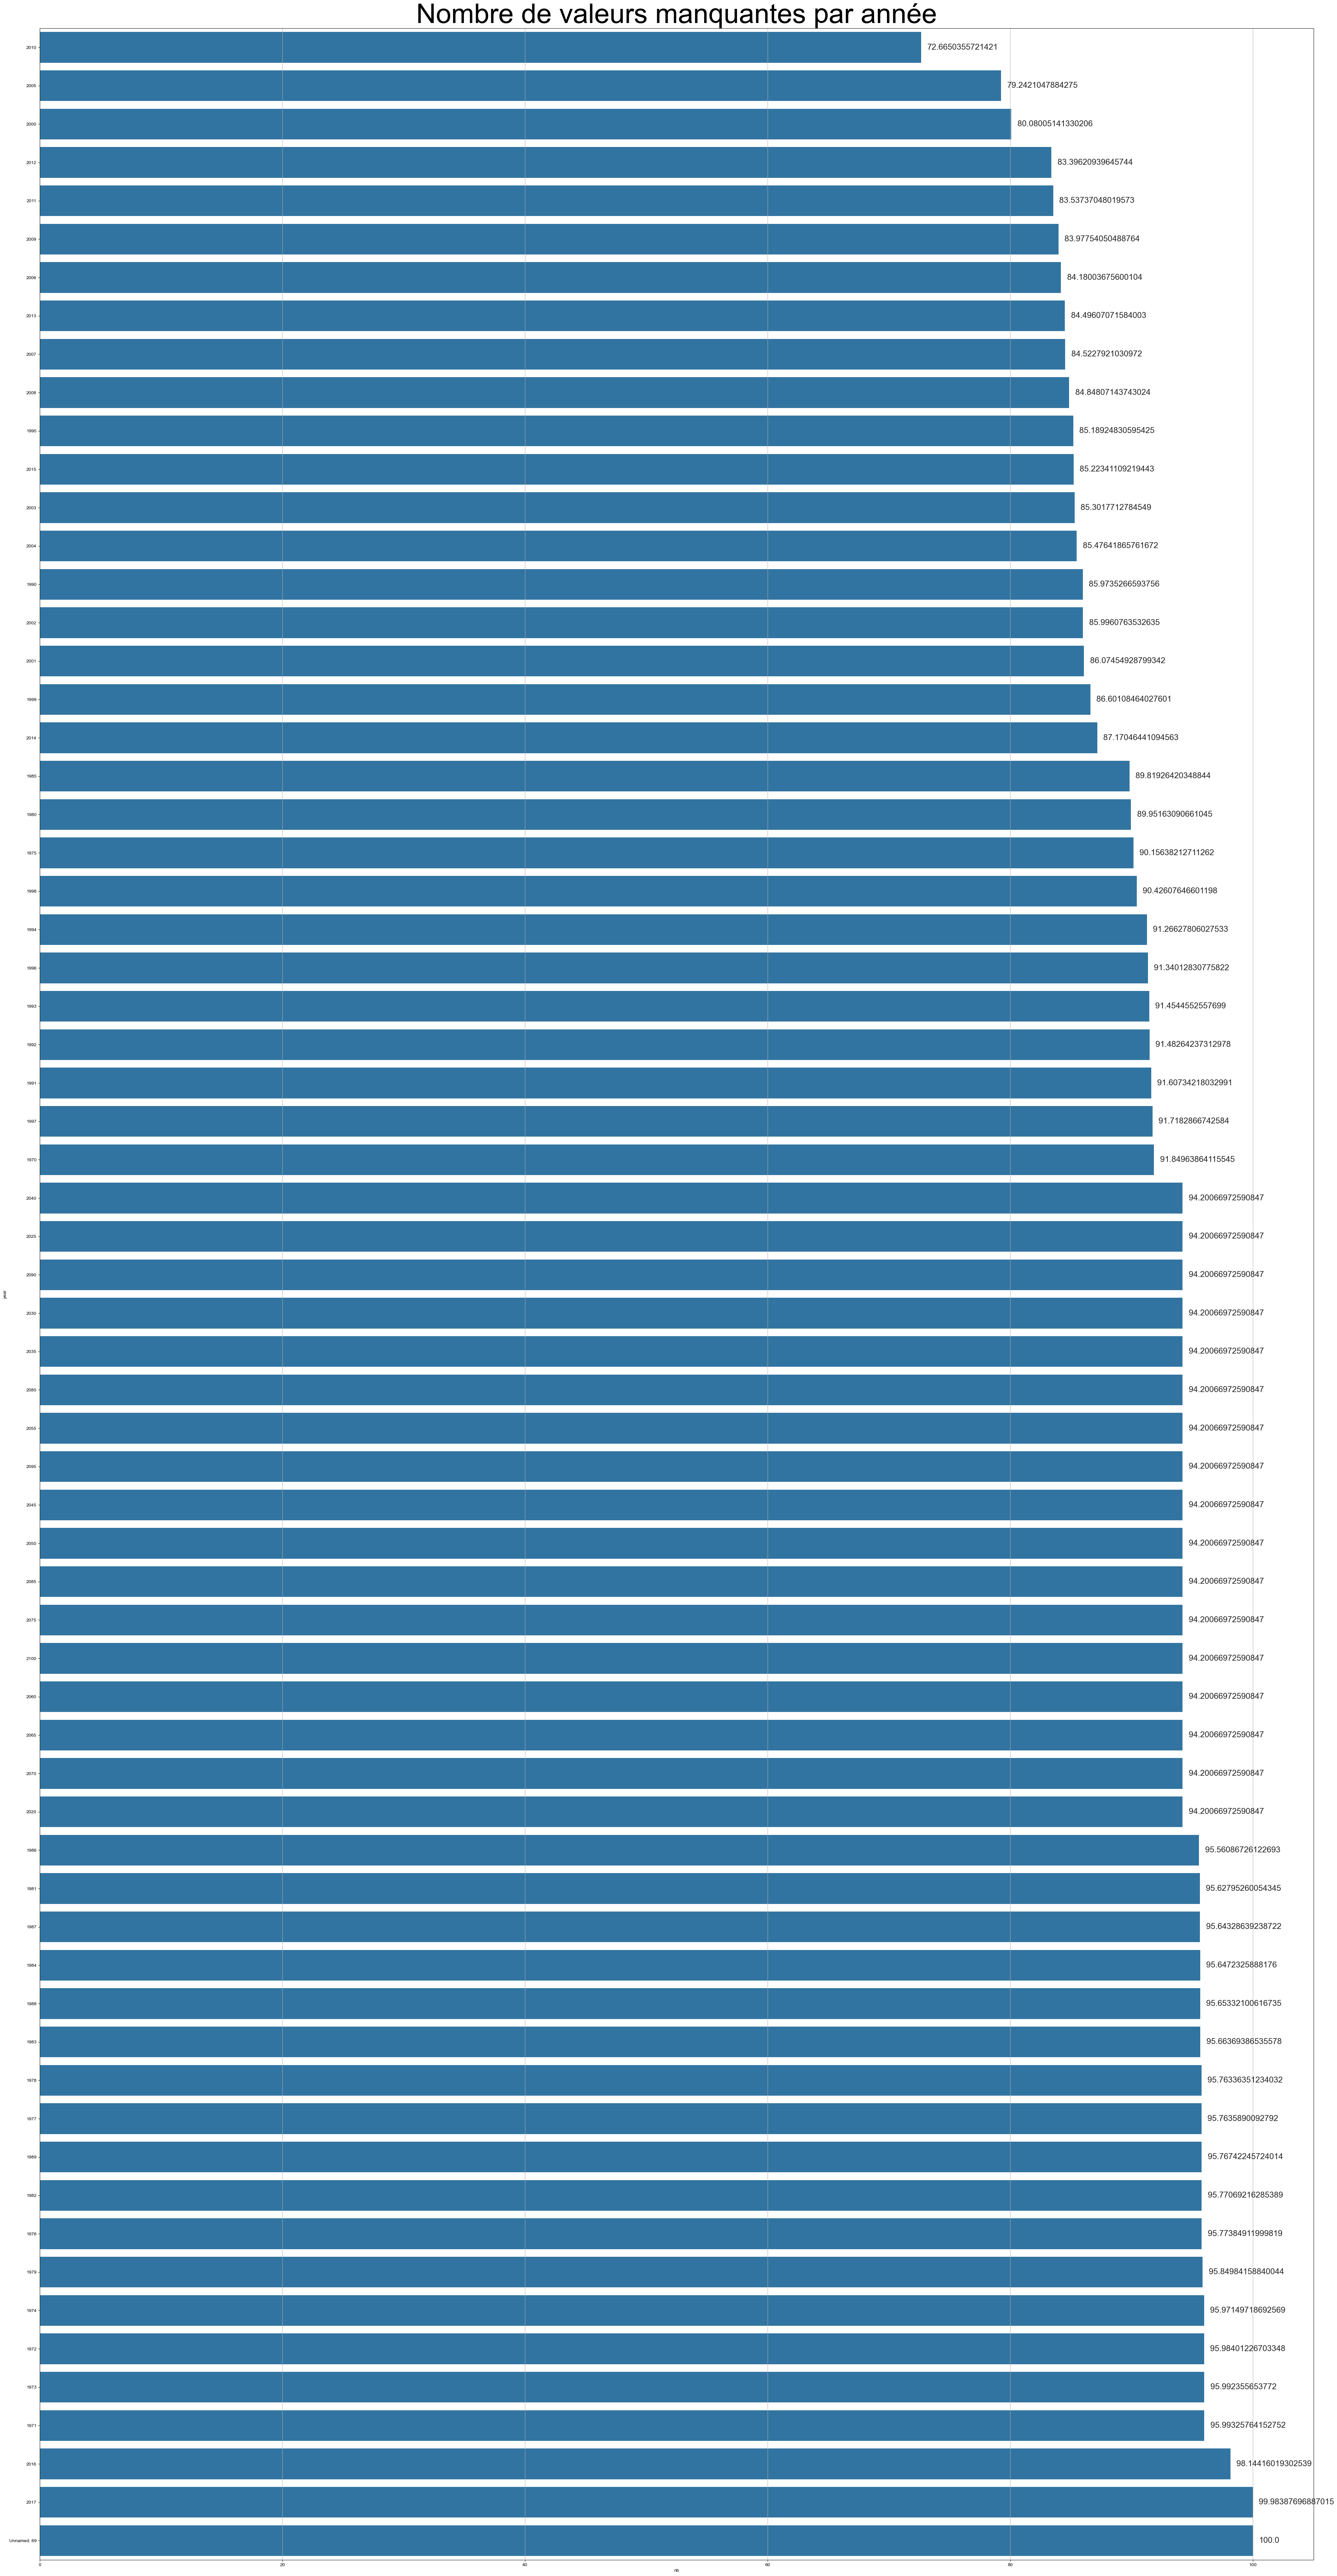

In [35]:
# Rechercher les années les mieux valorisées tout indicateur confondu

data_years_count = pd.DataFrame({'year':sf.index, 'nb':sf.values})
data_years_count_tri = data_years_count.sort_values(['nb'], ascending=[True])
data_years_count_tri.head()

plt.figure(figsize=(50,100))
ax = sns.barplot(data=data_years_count_tri.iloc[4:70,:], y='year', x='nb', errorbar=None)
sns.set_palette('pastel')
sns.set(font_scale=5)

# Ajouter des annotations à droite des barres
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.5, p.get_y() + p.get_height() / 2,  # Positionnement à droite de la barre
            f'{width}', ha='left', va='center', fontsize=18)  # Alignement à gauche pour que le texte soit à droite de la barre

plt.title("Nombre de valeurs manquantes par année")
plt.ylabel("year")
plt.xlabel("nb")
#plt.xlim(0,100)
#plt.xticks([0, 25, 50, 75, 100])
plt.grid(axis="x")

plt.show()

# Constat
# 2005 et 2010 sont les mieux valorisées

In [36]:
# rechercher les doublons country_name / indicator_name
doublons = data.duplicated(subset = ['Country Name', 'Indicator Name'])
totalDoublons = 0
for doublon in doublons:
    if doublon == True:
        totalDoublons += 1
print('fin, total doublons = ', totalDoublons)        
# Constat
## pas de doublons pays / indicateur

fin, total doublons =  0


Identifier la ou les années à prendre en compte dans l'analyse

In [38]:
# Calculer le nombre de valeurs de chaque indicateur par année, tout pays confondus

data_by_indicators_count = data.groupby('Indicator Name').count().reset_index()
data_by_indicators_count

Indicator Name  Country Name  \
0     Adjusted net enrolment rate, lower secondary, ...           242   
1     Adjusted net enrolment rate, lower secondary, ...           242   
2     Adjusted net enrolment rate, lower secondary, ...           242   
3     Adjusted net enrolment rate, lower secondary, ...           242   
4     Adjusted net enrolment rate, primary, both sex...           242   
...                                                 ...           ...   
3660  Youth illiterate population, 15-24 years, male...           242   
3661  Youth literacy rate, population 15-24 years, b...           242   
3662  Youth literacy rate, population 15-24 years, f...           242   
3663  Youth literacy rate, population 15-24 years, g...           242   
3664  Youth literacy rate, population 15-24 years, m...           242   

      Country Code  Indicator Code  1970  1971  1972  1973  1974  1975  1976  \
0              242             242     4    29    29    25    29    22    27   
1              242             242     2    24    25    22    24    20    22   
2              242             242     2    24    24    22    24    20    22   
3              242             242     2    24    24    22    24    20    22   
4              242             242    15    15    17    18    19    21    22   
...            ...             ...   ...   ...   ...   ...   ...   ...   ...   
3660           242             242     3     0     0     0     0     5     8   
3661           242             242     3     0     0     0     0     5     8   
3662           242             242     3     0     0     0     0     5     8   
3663           242             242     3     0     0     0     0     5     8   
3664           242             242     3     0     0     0     0     5     8   

      1977  1978  1979  1980  1981  1982  1983  1984  1985  1986  1987  1988  \
0       31    31    32    25    30    24    24    27    25    29    25    18   
1       27    26    26    21    27    24    24    25    24    26    21    15   
2       27    26    26    21    26    23    23    25    24    26    20    15   
3       27    26    26    21    26    23    23    25    24    26    20    15   
4       22    22    22    22    22    22    22    22    23    24    24    24   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
3660     1     2     7    19    18     7     2     4    15    14    13    14   
3661     1     2     7    20    19     7     2     4    23    22    21    22   
3662     1     2     7    20    18     7     2     4    23    22    21    22   
3663     1     2     7    20    18     7     2     4    23    22    21    22   
3664     1     2     7    20    18     7     2     4    23    22    21    22   

      1989  1990  1991  1992  1993  1994  1995  1996  1997  1998  1999  2000  \
0       24    21    26    30    32    39    33    32    29    42    96    95   
1       22    17    23    25    27    33    28    27    28    40    93    93   
2       21    17    22    24    27    32    27    26    27    40    93    93   
3       21    17    22    24    27    32    27    26    27    40    93    93   
4       24    24    24    25    25    25    25    25    25    25   145   148   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
3660    21    27    33    19    14    22    17    20    15    17    19    55   
3661    29    35    41    27    22    31    25    28    23    25    27    63   
3662    29    35    41    27    22    31    25    28    23    25    27    63   
3663    29    35    41    27    22    31    25    28    23    25    27    63   
3664    29    35    41    27    22    31    25    28    23    25    27    63   

      2001  2002  2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  \
0      101   101    94   101   105    98   104   102   112   106   107   102   
1       95    96    89    97   101    95   101   100   110   103   106   101   
2       95    96    89    97   101    95 

In [39]:
# On peut aussi retirer les indicateurs qui distinguent les 'female' et les 'males' 
# pour se concentrer sur la population totale, quelque soit le sexe

mask = ~(data_by_indicators_count['Indicator Name'].str.contains('female') | data_by_indicators_count['Indicator Name'].str.contains('male'))
data_by_indicators_count_without_sex = data_by_indicators_count.loc[mask]

print("Nombre d'indicateurs sans female ou male : ", data_by_indicators_count_without_sex.shape[0])

data_by_indicators_count_without_sex.head()

Nombre d'indicateurs sans female ou male :  2458


Indicator Name  Country Name  \
0  Adjusted net enrolment rate, lower secondary, ...           242   
2  Adjusted net enrolment rate, lower secondary, ...           242   
4  Adjusted net enrolment rate, primary, both sex...           242   
6  Adjusted net enrolment rate, primary, gender p...           242   
8  Adjusted net enrolment rate, upper secondary, ...           242   

   Country Code  Indicator Code  1970  1971  1972  1973  1974  1975  1976  \
0           242             242     4    29    29    25    29    22    27   
2           242             242     2    24    24    22    24    20    22   
4           242             242    15    15    17    18    19    21    22   
6           242             242    26    55    59    61    58    56    58   
8           242             242     0     0     0     0     0     0     0   

   1977  1978  1979  1980  1981  1982  1983  1984  1985  1986  1987  1988  \
0    31    31    32    25    30    24    24    27    25    29    25    18   
2    27    26    26    21    26    23    23    25    24    26    20    15   
4    22    22    22    22    22    22    22    22    23    24    24    24   
6    61    72    70    61    79    79    81    77    75    85    77    77   
8     0     0     0     0     0     0     0     0     0     0     0     0   

   1989  1990  1991  1992  1993  1994  1995  1996  1997  1998  1999  2000  \
0    24    21    26    30    32    39    33    32    29    42    96    95   
2    21    17    22    24    27    32    27    26    27    40    93    93   
4    24    24    24    25    25    25    25    25    25    25   145   148   
6    75    74    71    76    76    85    81    84    78    79   131   128   
8     0     0     0     0     0     0     0     0     0     6    24    33   

   2001  2002  2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  \
0   101   101    94   101   105    98   104   102   112   106   107   102   
2    95    96    89    97   101    95   101   100   110   103   106   101   
4   141   149   148   147   157   150   157   157   163   156   157   161   
6   118   119   125   126   135   136   142   142   144   135   140   141   
8    25    32    33    39    37    40    42    46    56    57    57    53   

   2013  2014  2015  2016  2017  2020  2025  2030  2035  2040  2045  2050  \
0    99    85     3     0     0     0     0     0     0     0     0     0   
2    98    84     3     0     0     0     0     0     0     0     0     0   
4   152   155   119     9     0     0     0     0     0     0     0     0   
6   130   120     7     0     0     0     0     0     0     0     0     0   
8   100    90     3     0     0     0     0     0     0     0     0     0   

   2055  2060  2065  2070  2075  2080  2085  2090  2095  2100  Unnamed: 69  
0     0     0     0     0     0     0     0     0     0     0            0  
2     0     0     0     0     0     0     0     0     0     0            0  
4     0     0     0     0     0     0     0     0     0     0            0  
6     0     0     0     0     0     0     0     0     0     0            0  
8     0     0     0     0     0     0     0     0     0     0            0

In [40]:
# Si on prend 2010 comme année de repère car c'est celle qui est la plus valorisée
# Quelles seraient les indicateurs les mieux valorisés pour 2010 ?
# pd.set_option('display.max_rows', 10)

mask = ~data_by_indicators_count_without_sex['2010'].isnull()
data_by_indicators_count_without_sex_sort = data_by_indicators_count_without_sex.loc[mask, ['Indicator Name', '2010']].sort_values('2010', ascending = False)
display(data_by_indicators_count_without_sex_sort)

# J'ai ensuite balayé visuellement la liste triée pour sélectionner des indicateurs pertinents pour notre analyse

Indicator Name  2010
2533                                  Population, total   240
2307                       Population growth (annual %)   240
1245                       GDP per capita (current US$)   228
1243                 GDP at market prices (current US$)   228
1242           GDP at market prices (constant 2005 US$)   227
...                                                 ...   ...
2040  PISA: Male 15-year-olds by mathematics profici...     0
2039  PISA: Male 15-year-olds by mathematics profici...     0
2038  PISA: Male 15-year-olds by mathematics profici...     0
2037  PISA: Male 15-year-olds by mathematics profici...     0
984   EGRA: Oral Reading Fluency - Share of students...     0

[2458 rows x 2 columns]

#### 1.3.2 - Conclusions

Les années retenues sont 2005 et 2010 car se sont celles les mieux valorisées pour tous les indicateurs, et particulièrement ceux sélectionnés. Ainsi que 2014 qui est l'année la plus récente la mieux valorisée.
Les années de projection/futures sont faiblement valorisés, mais pour cet indicateur, nous avons 167 pays valorisés :
- Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total
Mais on pourra tout de même utiliser ces 2 indicateurs pour la projection dans le futur 2030 et 2040.

Par ailleurs, pour compenser le déficit de pays dans les années de projection, on peut s'appuyer sur l'indicateur autour de l'éducation primaire , qui permettra d'estimer le nombre d'élèves futur dans le secondaire et à l'université.

Liste des indicateurs dans le fichier data retenus sont :

- GDP per capita (current US$)
- Internet users (per 100 people)
--> moyens dont disposent les élèves pour étudier en ligne

- Population of the official age for primary education, both sexes (number) 
- Population of the official age for secondary education, both sexes (number)
- Population of the official age for tertiary education, both sexes (number)
--> permet de voir l'évolutivité de la jeune population scolarisée dans le temps, et à comparer avec l'évolution de la population totale

- Population, total

- Population growth (annual %)
- Unemployment, total (% of total labor force) (modeled ILO estimate)
- Gross outbound enrolment ratio, all regions, both sexes (%)

- Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total
--> le dernier uniquement pour les projections dans le futur : 2030 et 2040

## 2 - Sélectionner les données pertinentes

### 2.1 - DataFrame country_selected

In [45]:
# On crée un dataframe sans les pays sans région vus précédemment, avec les 2 colonnes qui nous intéressent
mask = ~countries['Region'].isnull()
countries_selected = countries.loc[mask, ['Short Name', 'Region']].reset_index()
countries_selected = countries_selected.rename(columns={'Short Name': 'Country Name'})
print("Il y a", countries_selected.shape[0], "pays dans le dataFrame")
countries_selected.head()

Il y a 214 pays dans le dataFrame


index Country Name                     Region
0      0        Aruba  Latin America & Caribbean
1      1  Afghanistan                 South Asia
2      2       Angola         Sub-Saharan Africa
3      3      Albania      Europe & Central Asia
4      4      Andorra      Europe & Central Asia

In [46]:
# On crée la région Asie Centrale
central_asia_countries = ['Armenia', 'Azerbaijan', 'Georgia', 'Kazakhstan', 'Tajikistan', 'Turkmenistan', 'Turkey', 'Uzbekistan', 'Kyrgyz Republic']
mask = countries_selected['Country Name'].isin(central_asia_countries)
countries_selected.loc[mask, "Region"] = 'Central Asia'

# on renomme la région "Europe & Central Asia" en "Europe"
mask = countries_selected["Region"] == "Europe & Central Asia"
countries_selected.loc[mask, "Region"] = 'Europe'

In [47]:
# On crée la région 'Union Européenne"
ue_countries = ['Germany', 'Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Croatia', 'Denmark', 'Spain', 'Estonia', 'Finland', 'France', 'Greece', 'Hungary', 'Ireland', 'Italy',
                'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands', 'Poland', 'Portugal', 'Czech Republic', 'Romania', 'Slovak Republic', 'Slovenia', 'Sweden']
mask = countries_selected['Country Name'].isin(ue_countries)
countries_selected.loc[mask, "Region"] = 'European union'

# On renomme la région "Europe" en "Europe (hors UE)"
mask = countries_selected["Region"] == "Europe"
countries_selected.loc[mask, "Region"] = 'Europe (hors UE)'

### 2.2 - DataFrame data_selected

In [49]:
# on crée une liste avec tous indicateurs retenus, sauf les projections dans le futur
list_selected = [
    "GDP per capita (current US$)",
    "Internet users (per 100 people)",
    "Population, total",
    "Population of the official age for primary education, both sexes (number)",
    "Population of the official age for secondary education, both sexes (number)",
    "Population of the official age for tertiary education, both sexes (number)",
    "Population growth (annual %)",
    "Unemployment, total (% of total labor force)",
    "Gross outbound enrolment ratio, all regions, both sexes (%)"
]

In [50]:
# on crée un échantillon de "data" avec uniquement les indicateurs de la liste ci-dessus, et les années 2005 et 2010
mask_data_selected = data['Indicator Name'].isin(list_selected)
data_selected = data.loc[mask_data_selected, ['Country Name', 'Indicator Name', '2005', '2010', '2014']].reset_index()
data_selected.shape[0]

2178

In [51]:
# on retire de ce dataframe les 27 "pays" qui n'en sont pas
mask = ~data_selected['Country Name'].isin(paysSansRegion)
data_selected = data_selected.loc[mask]
print("Il y a donc", len(data_selected['Country Name'].unique()), "pays représentés dans ce fichier")
print("Ces pays ont", data_selected.shape[0] / len(data_selected['Country Name'].unique()), "indicateurs chacun")

Il y a donc 225 pays représentés dans ce fichier
Ces pays ont 9.0 indicateurs chacun


### 2.3 - Dataframe echantillon_projection

In [53]:
# on crée une liste avec les indicateurs futurs retenus
list_future = [
    "Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total"
]

In [54]:
# on crée un échantillon de "data" avec uniquement les indicateurs de la liste ci-dessus, et les années 2030 et 2040
mask_data_future = data['Indicator Name'].isin(list_future)
data_future = data.loc[mask_data_future, ['Country Name', 'Indicator Name', '2030', '2040']].reset_index()
data_future.shape[0]

242

In [55]:
# retirer les pays dont les valeurs sont manquantes
data_future = data_future.dropna(subset=['2030', '2040'])
print('nombre de pays valorisés dans le dataframe futur : ', data_future.shape[0])

# Constat
## on retrouve bien les 167 pays valorisés

nombre de pays valorisés dans le dataframe futur :  167


In [56]:
# on retire dans ce dataframe les 27 "pays" qui n'en sont pas
mask = ~data_future['Country Name'].isin(paysSansRegion)
data_future = data_future.loc[mask]
print("Il y a donc", len(data_future['Country Name'].unique()), "pays représentés dans ce dataframe futur")
print("Ces pays ont", data_future.shape[0] / len(data_future['Country Name'].unique()), "indicateurs chacun")

Il y a donc 166 pays représentés dans ce dataframe futur
Ces pays ont 1.0 indicateurs chacun


In [57]:
# créer le dataframe avec les indicateurs en colonnes à partir du dataframe data_future
# pivot the dataframe
pivot_data_future = data_future.pivot_table(index='Country Name', columns='Indicator Name').reset_index()
pivot_data_future.head()

Country Name  \
Indicator Name                
0                   Albania   
1                   Algeria   
2                 Argentina   
3                   Armenia   
4                     Aruba   

                                                                                                                                       2030  \
Indicator Name Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total   
0                                                           13.94                                                                             
1                                                         1044.45                                                                             
2                                                          247.98                                                                             
3                                                           38.39                                                                             
4                                                            0.77                                                                             

                                                                                                                                       2040  \
Indicator Name Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total   
0                                                           15.34                                                                             
1                                                         1269.20                                                                             
2                                                          276.84                                                                             
3                                                           34.76                                                                             
4                                                            0.90                                                                             

                                                                                                                                      index  
Indicator Name Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total  
0                                                         98904.0                                                                            
1                                                        102569.0                                                                            
2                                                        120894.0                                                                            
3                                                        124559.0                                                                            
4                                                        128224.0

In [58]:
pivot_data_future.describe()

# Constat
## on voit qu'il y a des pays qui ont 0.00000 personnes entre 20 et 24 ans. Quels sont ces pays ?

2030  \
Indicator Name Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total   
count                                                  166.000000                                                                             
mean                                                   608.992349                                                                             
std                                                   2386.292419                                                                             
min                                                      0.000000                                                                             
25%                                                     14.085000                                                                             
50%                                                     68.950000                                                                             
75%                                                    283.192500                                                                             
max                                                  22443.920000                                                                             

                                                                                                                                       2040  \
Indicator Name Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total   
count                                                  166.000000                                                                             
mean                                                   683.898976                                                                             
std                                                   2601.390365                                                                             
min                                                      0.000000                                                                             
25%                                                     16.697500                                                                             
50%                                                     86.510000                                                                             
75%                                                    324.792500                                                                             
max                                                  22836.480000                                                                             

                                                                                                                                      index  
Indicator Name Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total  
count                                                   166.00000                                                                            
mean                                                 494591.53012                                                                            
std                                                  226619.02294                                                                            
min                                                   98904.00000                                                                            
25%                                                  301395.25000                                                                            
50%                                                  492891.50000                                                                            
75%                                                  684387.75000                                                                        

In [59]:
# rechercher les pays avec 0.000000 population entre 20 et 24 ans
mask = pivot_data_future[('2030','Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total')] == 0
pivot_data_future.loc[mask, 'Country Name']

26    Central African Republic
Name: Country Name, dtype: object

In [60]:
# On supprime ce pays du dataframe car il ne peut pas être utilisé, d'autant plus que c'est un pays à faible revenu, 
# donc pas une destination à privilégier pour un développement international
pivot_data_future.drop(pivot_data_future[pivot_data_future[('2030','Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total')] == 00].index, inplace=True)
pivot_data_future.describe()

2030  \
Indicator Name Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total   
count                                                  165.000000                                                                             
mean                                                   612.683212                                                                             
std                                                   2393.081338                                                                             
min                                                      0.030000                                                                             
25%                                                     14.520000                                                                             
50%                                                     69.000000                                                                             
75%                                                    291.850000                                                                             
max                                                  22443.920000                                                                             

                                                                                                                                       2040  \
Indicator Name Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total   
count                                                  165.000000                                                                             
mean                                                   688.043818                                                                             
std                                                   2608.759517                                                                             
min                                                      0.030000                                                                             
25%                                                     16.750000                                                                             
50%                                                     88.660000                                                                             
75%                                                    326.130000                                                                             
max                                                  22836.480000                                                                             

                                                                                                                                      index  
Indicator Name Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total  
count                                                   165.00000                                                                            
mean                                                 496190.00000                                                                            
std                                                  226368.27329                                                                            
min                                                   98904.00000                                                                            
25%                                                  304144.00000                                                                            
50%                                                  494724.00000                                                                            
75%                                                  685304.00000                                                                        

In [61]:
# Pour plus de clarté, nous appelerons ce dataframe 'echantillon_projection'
# Utilisation de la méthode melt pour transformer les années en lignes
echantillon_projection = pd.melt(pivot_data_future, id_vars=['Country Name'], 
                    var_name='Year', value_name='Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total')

echantillon_projection.rename(columns={
    'Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total': 'Population age 20_24 in thousands'
}, inplace=True)

echantillon_projection.reset_index()

#supprimer les lignes year = index
echantillon_projection = echantillon_projection[echantillon_projection['Year'] != 'index']

echantillon_projection.head()

Country Name  Year  Population age 20_24 in thousands
0      Albania  2030                              13.94
1      Algeria  2030                            1044.45
2    Argentina  2030                             247.98
3      Armenia  2030                              38.39
4        Aruba  2030                               0.77

# 3 - Créer un dataframe pluriannuel dans le but de mener une analyse

## 3.1 - Créer le dataframe principal à analyser à partir de data_selected

In [64]:
# Tester le pivot_table sur un exemple, pour s'assurer que les valeurs seront bien toutes reportées
exemple = {'Indicateur': ['ind1', 'ind1', 'ind2', 'ind2'],
        'City': ['New York', 'Los Angeles', 'New York', 'Los Angeles'],
        '2005': [1, 2, 11, 22],
        '2010': [101, 102, 103, 104]}

df = pd.DataFrame(exemple)

print('Original DataFrame')
print(df)
print()

# pivot the dataframe
pivot_df = df.pivot_table(index='City', columns='Indicateur').reset_index()

print('Reshaped DataFrame')
print(pivot_df)

print()
print("Dataframe réduit avec que l'année 2010")
print(pivot_df['2010'])

Original DataFrame
  Indicateur         City  2005  2010
0       ind1     New York     1   101
1       ind1  Los Angeles     2   102
2       ind2     New York    11   103
3       ind2  Los Angeles    22   104

Reshaped DataFrame
                   City 2005         2010       
Indicateur              ind1  ind2   ind1   ind2
0           Los Angeles  2.0  22.0  102.0  104.0
1              New York  1.0  11.0  101.0  103.0

Dataframe réduit avec que l'année 2010
Indicateur   ind1   ind2
0           102.0  104.0
1           101.0  103.0


Le pivot_table est validé

In [66]:
# Ajouter la zone géographique dans data_selected
echantillon = pd.merge(data_selected, countries_selected, on='Country Name', how='left')
echantillon = echantillon.drop(columns=['index_y'])
echantillon = echantillon.drop(columns=['index_x'])
#echantillon = echantillon.rename(columns={'index_x': 'index'})
echantillon.reset_index()
echantillon.head()

Country Name                                     Indicator Name  \
0  East Asia & Pacific                       GDP per capita (current US$)   
1  East Asia & Pacific  Gross outbound enrolment ratio, all regions, b...   
2  East Asia & Pacific                    Internet users (per 100 people)   
3  East Asia & Pacific                       Population growth (annual %)   
4  East Asia & Pacific  Population of the official age for primary edu...   

           2005          2010          2014 Region  
0  4.842265e+03  7.679834e+03  9.665056e+03    NaN  
1  4.397100e-01  5.142800e-01           NaN    NaN  
2  1.466636e+01  3.423084e+01  4.681210e+01    NaN  
3  7.560929e-01  6.757239e-01  6.818708e-01    NaN  
4  1.918516e+08  1.697305e+08  1.711129e+08    NaN

In [67]:
# Rechercher les pays sans région
mask = echantillon['Region'].isna()
echantillon.loc[mask, 'Country Name'].unique()

array(['East Asia & Pacific',
       'East Asia & Pacific (excluding high income)',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Middle East & North Africa',
       'Middle East & North Africa (excluding high income)',
       'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)',
       'Bahamas, The', 'British Virgin Islands', 'Brunei Darussalam',
       'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Curacao',
       'Egypt, Arab Rep.', 'Faroe Islands', 'Gambia, The',
       'Iran, Islamic Rep.', 'Korea, Dem. People’s Rep.', 'Korea, Rep.',
       'Macedonia, FYR', 'Micronesia, Fed. Sts.', 'Russian Federation',
       'Sao Tome and Principe', 'Venezuela, RB', 'Virgin Islands (U.S.)',
       'Yemen, Rep.'], dtype=object)

In [68]:
# Supprimer les pays qui ne sont pas des pays
list = ['East Asia & Pacific',
       'East Asia & Pacific (excluding high income)',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Middle East & North Africa',
       'Middle East & North Africa (excluding high income)',
       'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)']
mask = ~echantillon['Country Name'].isin(list)
echantillon = echantillon[mask]
echantillon.head()

Country Name                                     Indicator Name  \
90  Afghanistan                       GDP per capita (current US$)   
91  Afghanistan  Gross outbound enrolment ratio, all regions, b...   
92  Afghanistan                    Internet users (per 100 people)   
93  Afghanistan                       Population growth (annual %)   
94  Afghanistan  Population of the official age for primary edu...   

            2005          2010          2014      Region  
90  2.502941e+02  5.533003e+02  6.120697e+02  South Asia  
91  1.558300e-01  3.136900e-01           NaN  South Asia  
92  1.224148e+00  4.000000e+00  7.000000e+00  South Asia  
93  3.870470e+00  2.812617e+00  3.183201e+00  South Asia  
94  4.145879e+06  5.003108e+06  5.564280e+06  South Asia

In [69]:
# Renseignons la region des pays dont la région n'est pas valorisée
mask = echantillon['Country Name'] == "Bahamas, The"
echantillon.loc[mask, 'Region'] = 'Latin America & Caribbean'

mask = echantillon['Country Name'] == "British Virgin Islands"
echantillon.loc[mask, 'Region'] = 'North America'

mask = echantillon['Country Name'] == "Brunei Darussalam"
echantillon.loc[mask, 'Region'] = 'East Asia & Pacific'

mask = echantillon['Country Name'] == "Congo, Dem. Rep."
echantillon.loc[mask, 'Region'] = 'Sub-Saharan Africa'

mask = echantillon['Country Name'] == "Congo, Rep."
echantillon.loc[mask, 'Region'] = 'Sub-Saharan Africa'

mask = echantillon['Country Name'] == "Cote d'Ivoire"
echantillon.loc[mask, 'Region'] = 'Sub-Saharan Africa'

mask = echantillon['Country Name'] == "Curacao"
echantillon.loc[mask, 'Region'] = 'Latin America & Caribbean'

mask = echantillon['Country Name'] == "Egypt, Arab Rep."
echantillon.loc[mask, 'Region'] = 'Middle East & North Africa'

mask = echantillon['Country Name'] == "Faroe Islands"
echantillon.loc[mask, 'Region'] = 'Europe (hors UE)'

mask = echantillon['Country Name'] == "Gambia, The"
echantillon.loc[mask, 'Region'] = 'Sub-Saharan Africa'

mask = echantillon['Country Name'] == "Iran, Islamic Rep."
echantillon.loc[mask, 'Region'] = 'Middle East & North Africa'

mask = echantillon['Country Name'] == "Korea, Dem. People’s Rep."
echantillon.loc[mask, 'Region'] = 'East Asia & Pacific'

mask = echantillon['Country Name'] == "Korea, Rep."
echantillon.loc[mask, 'Region'] = 'East Asia & Pacific'

mask = echantillon['Country Name'] == "Macedonia, FYR"
echantillon.loc[mask, 'Region'] = 'Europe (hors UE)'

mask = echantillon['Country Name'] == "Micronesia, Fed. Sts."
echantillon.loc[mask, 'Region'] = 'East Asia & Pacific'

mask = echantillon['Country Name'] == "Russian Federation"
echantillon.loc[mask, 'Region'] = 'Europe (hors UE)'

mask = echantillon['Country Name'] == "Sao Tome and Principe"
echantillon.loc[mask, 'Region'] = 'Sub-Saharan Africa'

mask = echantillon['Country Name'] == "Venezuela, RB"
echantillon.loc[mask, 'Region'] = 'Latin America & Caribbean'

mask = echantillon['Country Name'] == "Virgin Islands (U.S.)"
echantillon.loc[mask, 'Region'] = 'Latin America & Caribbean'

mask = echantillon['Country Name'] == "Yemen, Rep."
echantillon.loc[mask, 'Region'] = 'Middle East & North Africa'


In [70]:
# créer le dataframe avec les indicateurs en colonnes à partir du dataframe echantillon
# pivot the dataframe

# réorganiser les colonnes en une seule année
echantillon_melted = echantillon.melt(id_vars=['Country Name', 'Indicator Name', 'Region'],
                    var_name='Year', value_name='Value')

# pivot pour mettre les années en lignes et les indicateurs en colonnes
echantillon_pivoted = echantillon_melted.pivot_table(index=['Country Name', 'Region', 'Year'], 
                                   columns='Indicator Name', 
                                   values='Value', 
                                   aggfunc='first').reset_index()

echantillon_pivoted.head()

Indicator Name Country Name            Region  Year  \
0               Afghanistan        South Asia  2005   
1               Afghanistan        South Asia  2010   
2               Afghanistan        South Asia  2014   
3                   Albania  Europe (hors UE)  2005   
4                   Albania  Europe (hors UE)  2010   

Indicator Name  GDP per capita (current US$)  \
0                                 250.294130   
1                                 553.300289   
2                                 612.069651   
3                                2709.142931   
4                                4094.358832   

Indicator Name  Gross outbound enrolment ratio, all regions, both sexes (%)  \
0                                                         0.15583             
1                                                         0.31369             
2                                                             NaN             
3                                                         5.90823             
4                                                         8.48007             

Indicator Name  Internet users (per 100 people)  Population growth (annual %)  \
0                                      1.224148                      3.870470   
1                                      4.000000                      2.812617   
2                                      7.000000                      3.183201   
3                                      6.043891                     -0.511790   
4                                     45.000000                     -0.496462   

Indicator Name  Population of the official age for primary education, both sexes (number)  \
0                                                       4145879.0                           
1                                                       5003108.0                           
2                                                       5564280.0                           
3                                                        234522.0                           
4                                                        227021.0                           

Indicator Name  Population of the official age for secondary education, both sexes (number)  \
0                                                       3292878.0                             
1                                                       3839021.0                             
2                                                       4676453.0                             
3                                                        529872.0                             
4                                                        402516.0                             

Indicator Name  Population of the official age for tertiary education, both sexes (number)  \
0                                                       2304393.0                            
1                                                       2490352.0                            
2                                                       3034517.0                            
3                                                        271360.0                            
4                                                        274639.0                            

Indicator Name  Population, total  \
0                      25070798.0   
1                      28803167.0   
2                      32758020.0   
3                       3011487.0   
4                       2913021.0   

Indicator Name  Unemployment, total (% of total labor force)  
0                                                        8.5  
1                                                        8.1  
2                                                        8.6  
3                                                       13.8  
4                                                       14.2

ATTENTION : 
- on remarque que l'indicateur "Personal computers (per 100 people)" n'apparait plus en 2010 et 2014, car les il n'y a aucune valorisation.
- on remarque que l'indicateur "Gross outbound enrolment ratio, all regions, both sexes (%)" n'apparait plus en 2014 car il n'y a plus de valorisations à partir de 1011.


## 3.2 - Nettoyage du dataframe principal créé - valeurs manquantes

In [73]:
# identifier le nombre de valeurs manquantes par indicateur
print("Nombre de valeurs manquantes par colonnes")
print(echantillon_pivoted.isnull().sum())

Nombre de valeurs manquantes par colonnes
Indicator Name
Country Name                                                                     0
Region                                                                           0
Year                                                                             0
GDP per capita (current US$)                                                    39
Gross outbound enrolment ratio, all regions, both sexes (%)                    274
Internet users (per 100 people)                                                 44
Population growth (annual %)                                                     6
Population of the official age for primary education, both sexes (number)       73
Population of the official age for secondary education, both sexes (number)     62
Population of the official age for tertiary education, both sexes (number)      65
Population, total                                                                6
Unemployment, total (% of tota

### 3.2.1 - Nettoyage pour l'indicateur "Internet users (per 100 people)"
Etant donné le contexte du projet, l'absence de valorisation sur le thème 'Internet users' est éliminatoire, car les futurs clients de l'Academy à l'international doivent pouvoir accéder au réseau pour suivre les cours en ligne

In [75]:
# supprimer les pays pour lesquels la variable 'Internet users' n'est pas valorisée

# rechercher les pays concernés
mask = echantillon_pivoted['Internet users (per 100 people)'].isnull()
liste_pays = echantillon_pivoted.loc[mask, 'Country Name'].unique()
print("Liste des pays dont l'indicateur Internet Users n'est pas valorisé :", liste_pays)

# supprimer ces pays du dataframe principal
# etape 2 - supprimer ces pays du dataframe principal
mask = ~echantillon_pivoted['Country Name'].isin(liste_pays)
echantillon_pivoted = echantillon_pivoted.loc[mask]

Liste des pays dont l'indicateur Internet Users n'est pas valorisé : ['American Samoa' 'Belarus' 'British Virgin Islands' 'Channel Islands'
 'Curacao' 'Eritrea' 'Guyana' 'Isle of Man' 'Korea, Dem. People’s Rep.'
 'Kosovo' 'Liberia' 'Mongolia' 'Northern Mariana Islands' 'Palau'
 'San Marino' 'Sint Maarten (Dutch part)' 'Somalia' 'South Sudan'
 'St. Martin (French part)' 'Turks and Caicos Islands' 'Tuvalu']


In [76]:
# identifier le nombre de valeurs manquantes par indicateur
print("Nombre de valeurs manquantes par colonnes")
print(echantillon_pivoted.isnull().sum())

Nombre de valeurs manquantes par colonnes
Indicator Name
Country Name                                                                     0
Region                                                                           0
Year                                                                             0
GDP per capita (current US$)                                                    16
Gross outbound enrolment ratio, all regions, both sexes (%)                    231
Internet users (per 100 people)                                                  0
Population growth (annual %)                                                     0
Population of the official age for primary education, both sexes (number)       47
Population of the official age for secondary education, both sexes (number)     37
Population of the official age for tertiary education, both sexes (number)      42
Population, total                                                                0
Unemployment, total (% of tota

### 3.2.2 - Nettoyage pour l'indicateur "GDP per capita (current US$)"
Le GDP (PIB) en dollars est aussi une donnée importante, car elle permet d'en déduire le niveau de vie des habitants, et donc les moyens que les habitants de ces pays disposent pour des cours en ligne.

In [78]:
# recherche les pays pour lesquels la variable 'GDP per capita (current US$)' n'est pas valorisée

mask = echantillon_pivoted['GDP per capita (current US$)'].isnull() & (echantillon_pivoted['Year'] == '2005')
liste_pays = echantillon_pivoted.loc[mask, 'Country Name'].unique()
print("Liste des pays dont l'indicateur 'GDP per capita (current US$)' n'est pas valorisé pour 2005 :", liste_pays)

mask = echantillon_pivoted['GDP per capita (current US$)'].isnull() & (echantillon_pivoted['Year'] == '2010')
liste_pays = echantillon_pivoted.loc[mask, 'Country Name'].unique()
print("Liste des pays dont l'indicateur 'GDP per capita (current US$)' n'est pas valorisé pour 2010 :", liste_pays)

mask = echantillon_pivoted['GDP per capita (current US$)'].isnull() & (echantillon_pivoted['Year'] == '2014')
liste_pays = echantillon_pivoted.loc[mask, 'Country Name'].unique()
print("Liste des pays dont l'indicateur 'GDP per capita (current US$)' n'est pas valorisé pour 2014 :", liste_pays)

mask = (echantillon_pivoted['Year'] == '2005') & (echantillon_pivoted['Country Name'] == 'Puerto Rico') 
print(echantillon_pivoted.loc[mask, 'GDP per capita (current US$)'])

Liste des pays dont l'indicateur 'GDP per capita (current US$)' n'est pas valorisé pour 2005 : ['Cayman Islands' 'French Polynesia' 'New Caledonia']
Liste des pays dont l'indicateur 'GDP per capita (current US$)' n'est pas valorisé pour 2010 : ['Cayman Islands' 'French Polynesia' 'New Caledonia'
 'Syrian Arab Republic']
Liste des pays dont l'indicateur 'GDP per capita (current US$)' n'est pas valorisé pour 2014 : ['Aruba' 'Bermuda' 'Cayman Islands' 'French Polynesia' 'Libya' 'Monaco'
 'New Caledonia' 'Puerto Rico' 'Syrian Arab Republic']
465    21959.322708
Name: GDP per capita (current US$), dtype: float64


On peut récupérer sur internet les valeurs pour Monaco :
- 2014 : 168 K USD

Pour Puerto Rico :
- 2014 : 29 K USD

In [80]:
# On renseigne ces valeurs manuellement pour 2014
mask = (echantillon_pivoted['Country Name'] == 'Monaco') & (echantillon_pivoted['Year'] == '2014')
echantillon_pivoted.loc[mask, 'GDP per capita (current US$)'] = 168000.000000

mask = (echantillon_pivoted['Country Name'] == 'Puerto Rico') & (echantillon_pivoted['Year'] == '2014')
echantillon_pivoted.loc[mask, 'GDP per capita (current US$)'] = 29000.000000

# et on supprime les autres
mask = ~echantillon_pivoted['GDP per capita (current US$)'].isnull()
echantillon_pivoted = echantillon_pivoted.loc[mask]

In [81]:
# identifier le nombre de valeurs manquantes par indicateur
print("Nombre de valeurs manquantes par colonnes")
print(echantillon_pivoted.isnull().sum())

Nombre de valeurs manquantes par colonnes
Indicator Name
Country Name                                                                     0
Region                                                                           0
Year                                                                             0
GDP per capita (current US$)                                                     0
Gross outbound enrolment ratio, all regions, both sexes (%)                    218
Internet users (per 100 people)                                                  0
Population growth (annual %)                                                     0
Population of the official age for primary education, both sexes (number)       38
Population of the official age for secondary education, both sexes (number)     28
Population of the official age for tertiary education, both sexes (number)      33
Population, total                                                                0
Unemployment, total (% of tota

### 3.3.3 - Nettoyage pour l'indicateur "Unemployment, total (% of total labor force)"

In [83]:
# Rechercher les pays concernés pour les 3 années
mask = echantillon_pivoted['Unemployment, total (% of total labor force)'].isnull() & (echantillon_pivoted['Year'] == '2005')
liste_pays = echantillon_pivoted.loc[mask, 'Country Name'].unique()
print("Liste des pays dont l'indicateur 'Unemployment, total (% of total labor force)' n'est pas valorisé pour 2005 :", liste_pays)

mask = echantillon_pivoted['Unemployment, total (% of total labor force)'].isnull() & (echantillon_pivoted['Year'] == '2010')
liste_pays = echantillon_pivoted.loc[mask, 'Country Name'].unique()
print("Liste des pays dont l'indicateur 'Unemployment, total (% of total labor force)' n'est pas valorisé pour 2010 :", liste_pays)

mask = echantillon_pivoted['Unemployment, total (% of total labor force)'].isnull() & (echantillon_pivoted['Year'] == '2014')
liste_pays = echantillon_pivoted.loc[mask, 'Country Name'].unique()
print("Liste des pays dont l'indicateur 'Unemployment, total (% of total labor force)' n'est pas valorisé pour 2014 :", liste_pays)

Liste des pays dont l'indicateur 'Unemployment, total (% of total labor force)' n'est pas valorisé pour 2005 : ['Andorra' 'Antigua and Barbuda' 'Aruba' 'Bermuda' 'Dominica'
 'Faroe Islands' 'Greenland' 'Grenada' 'Kiribati' 'Liechtenstein'
 'Marshall Islands' 'Micronesia, Fed. Sts.' 'Monaco' 'Seychelles'
 'St. Kitts and Nevis']
Liste des pays dont l'indicateur 'Unemployment, total (% of total labor force)' n'est pas valorisé pour 2010 : ['Andorra' 'Antigua and Barbuda' 'Aruba' 'Bermuda' 'Dominica'
 'Faroe Islands' 'Greenland' 'Grenada' 'Kiribati' 'Liechtenstein'
 'Marshall Islands' 'Micronesia, Fed. Sts.' 'Monaco' 'Seychelles'
 'St. Kitts and Nevis']
Liste des pays dont l'indicateur 'Unemployment, total (% of total labor force)' n'est pas valorisé pour 2014 : ['Andorra' 'Antigua and Barbuda' 'Dominica' 'Faroe Islands' 'Greenland'
 'Grenada' 'Kiribati' 'Liechtenstein' 'Marshall Islands'
 'Micronesia, Fed. Sts.' 'Monaco' 'Seychelles' 'St. Kitts and Nevis']


Tout ces pays sont de très petites tailles. Certains ont un niveau de vie élevé, mais par exemple les taux de chomage d'Andorre, de Monaco et du Liechtenstein ne semblent pas disponibles sur Internet. Je pense qu'on peut retirer ces pays de notre dataframe principal car un déploiement dans ces pays serait peut rentable, compte tenu du nbre d'habitants. D'autant que Monaco peut être couvert par une offre en France, et Andorre par une offre en Espagne par exemple.

In [85]:
# Supprimer ces pays
mask = ~echantillon_pivoted['Unemployment, total (% of total labor force)'].isnull()
echantillon_pivoted = echantillon_pivoted.loc[mask]

In [86]:
# identifier le nombre de valeurs manquantes par indicateur
print("Nombre de valeurs manquantes par colonnes")
print(echantillon_pivoted.isnull().sum())

Nombre de valeurs manquantes par colonnes
Indicator Name
Country Name                                                                     0
Region                                                                           0
Year                                                                             0
GDP per capita (current US$)                                                     0
Gross outbound enrolment ratio, all regions, both sexes (%)                    194
Internet users (per 100 people)                                                  0
Population growth (annual %)                                                     0
Population of the official age for primary education, both sexes (number)       25
Population of the official age for secondary education, both sexes (number)     15
Population of the official age for tertiary education, both sexes (number)      20
Population, total                                                                0
Unemployment, total (% of tota

### 3.3.4 - Nettoyage de l'indicateur "Population of the official age for primary education, both sexes (number)"

In [88]:
# Rechercher les pays concernés pour les 3 années
mask = echantillon_pivoted['Population of the official age for primary education, both sexes (number)'].isnull() & (echantillon_pivoted['Year'] == '2005')
liste_pays = echantillon_pivoted.loc[mask, 'Country Name'].unique()
print("Liste des pays dont l'indicateur 'Population of the official age for primary education, both sexes (number)' n'est pas valorisé pour 2005 :", liste_pays)

mask = echantillon_pivoted['Population of the official age for primary education, both sexes (number)'].isnull() & (echantillon_pivoted['Year'] == '2010')
liste_pays = echantillon_pivoted.loc[mask, 'Country Name'].unique()
print("Liste des pays dont l'indicateur 'Population of the official age for primary education, both sexes (number)' n'est pas valorisé pour 2010 :", liste_pays)

mask = echantillon_pivoted['Population of the official age for primary education, both sexes (number)'].isnull() & (echantillon_pivoted['Year'] == '2014')
liste_pays = echantillon_pivoted.loc[mask, 'Country Name'].unique()
print("Liste des pays dont l'indicateur 'Population of the official age for primary education, both sexes (number)' n'est pas valorisé pour 2014 :", liste_pays)

Liste des pays dont l'indicateur 'Population of the official age for primary education, both sexes (number)' n'est pas valorisé pour 2005 : ['Bosnia and Herzegovina' 'Guam' 'Hong Kong SAR, China' 'Jamaica'
 'Singapore' 'Virgin Islands (U.S.)']
Liste des pays dont l'indicateur 'Population of the official age for primary education, both sexes (number)' n'est pas valorisé pour 2010 : ['Armenia' 'Bosnia and Herzegovina' 'Brazil' 'Guam' 'Hong Kong SAR, China'
 'Jamaica' 'Maldives' 'Singapore' 'St. Lucia' 'Virgin Islands (U.S.)']
Liste des pays dont l'indicateur 'Population of the official age for primary education, both sexes (number)' n'est pas valorisé pour 2014 : ['Armenia' 'Bosnia and Herzegovina' 'Guam' 'Hong Kong SAR, China'
 'Jamaica' 'Maldives' 'Singapore' 'St. Lucia' 'Virgin Islands (U.S.)']


Comme les données de ces pays ne semblent pas accessibles pour les années sélectionnées, je dois les supprimer du dataframe principal


In [90]:
# Supprimer ces pays du dataframe principal
mask = ~echantillon_pivoted['Population of the official age for primary education, both sexes (number)'].isnull()
echantillon_pivoted = echantillon_pivoted.loc[mask]

In [91]:
# identifier le nombre de valeurs manquantes par indicateur
print("Nombre de valeurs manquantes par colonnes")
print(echantillon_pivoted.isnull().sum())

Nombre de valeurs manquantes par colonnes
Indicator Name
Country Name                                                                     0
Region                                                                           0
Year                                                                             0
GDP per capita (current US$)                                                     0
Gross outbound enrolment ratio, all regions, both sexes (%)                    176
Internet users (per 100 people)                                                  0
Population growth (annual %)                                                     0
Population of the official age for primary education, both sexes (number)        0
Population of the official age for secondary education, both sexes (number)      0
Population of the official age for tertiary education, both sexes (number)       7
Population, total                                                                0
Unemployment, total (% of tota

Il n'est pas nécessaire de nettoyer ici, car l'indicateur "Gross outbound enrolment ratio, all regions, both sexes (%)" sera utilisée en fn d'analyse, sur les pays les plus pertinents pour les départager si besoin.

## 3.3 - Recherche des outliers, valeurs aberrantes, erreurs de formatage, sur le dataframe principal

In [94]:
echantillon_pivoted.describe()

Indicator Name  GDP per capita (current US$)  \
count                             500.000000   
mean                            12691.158559   
std                             18654.245068   
min                               150.507043   
25%                              1219.428348   
50%                              4187.760263   
75%                             15777.733974   
max                            119225.380023   

Indicator Name  Gross outbound enrolment ratio, all regions, both sexes (%)  \
count                                                  324.000000             
mean                                                     2.373785             
std                                                      4.119283             
min                                                      0.051740             
25%                                                      0.380145             
50%                                                      1.055135             
75%                                                      2.796058             
max                                                     40.556911             

Indicator Name  Internet users (per 100 people)  Population growth (annual %)  \
count                                500.000000                    500.000000   
mean                                  31.707604                      1.581085   
std                                   28.452068                      1.550216   
min                                    0.065239                     -2.096943   
25%                                    6.400000                      0.548763   
50%                                   22.035000                      1.397819   
75%                                   53.672500                      2.463953   
max                                   98.160000                     13.076039   

Indicator Name  Population of the official age for primary education, both sexes (number)  \
count                                                5.000000e+02                           
mean                                                 3.938881e+06                           
std                                                  1.283434e+07                           
min                                                  1.282300e+04                           
25%                                                  2.457152e+05                           
50%                                                  8.334540e+05                           
75%                                                  3.233121e+06                           
max                                                  1.276937e+08                           

Indicator Name  Population of the official age for secondary education, both sexes (number)  \
count                                                5.000000e+02                             
mean                                                 4.531837e+06                             
std                                                  1.662478e+07                             
min                                                  9.879000e+03                             
25%                                                  2.829805e+05                             
50%                                                  9.075460e+05                             
75%                                                  3.442386e+06                             
max                                                  1.742689e+08                             

Indicator Name  Population of the official age for tertiary education, both sexes (number)  \
count                                                4.930000e+02                            
mean                                                 3.543977e+06                            
std                                                  1.290252e+07                            
min                                                  9.

A première vue il ne semble pas y avoir d'outliers ou de valeurs aberranntes. L'analyse nous permettra de le vérifier.

### 3.3.1 - Vérification des types de données


In [97]:
print('Type pour "GDP per capita (current US$)" : ', echantillon_pivoted['GDP per capita (current US$)'].dtype)
print('Type pour "Gross outbound enrolment ratio, all regions, both sexes (%)" : ', echantillon_pivoted['Gross outbound enrolment ratio, all regions, both sexes (%)'].dtype)
print('Type pour "Internet users (per 100 people)" : ', echantillon_pivoted['Internet users (per 100 people)'].dtype)
print('Type pour "Population growth (annual %)" : ', echantillon_pivoted['Population growth (annual %)'].dtype)
print('Type pour "Population of the official age for primary education, both sexes (number)" : ', echantillon_pivoted['Population of the official age for primary education, both sexes (number)'].dtype)
print('Type pour "Population of the official age for secondary education, both sexes (number)" : ', echantillon_pivoted['Population of the official age for secondary education, both sexes (number)'].dtype)
print('Type pour "Population of the official age for tertiary education, both sexes (number)" : ', echantillon_pivoted['Population of the official age for tertiary education, both sexes (number)'].dtype)
print('Type pour "Population, total" : ', echantillon_pivoted['Population, total'].dtype)
print('Unemployment, total (% of total labor force)" : ', echantillon_pivoted['Unemployment, total (% of total labor force)'].dtype)

Type pour "GDP per capita (current US$)" :  float64
Type pour "Gross outbound enrolment ratio, all regions, both sexes (%)" :  float64
Type pour "Internet users (per 100 people)" :  float64
Type pour "Population growth (annual %)" :  float64
Type pour "Population of the official age for primary education, both sexes (number)" :  float64
Type pour "Population of the official age for secondary education, both sexes (number)" :  float64
Type pour "Population of the official age for tertiary education, both sexes (number)" :  float64
Type pour "Population, total" :  float64
Unemployment, total (% of total labor force)" :  float64


Format des données OK

Les 2 dataframes sont désormais prêts pour l'analyse
- echantillon_pivoted
- echantillon_projection

# 4 - Analyser le jeu de données

## 4.1 - Vue globale

In [102]:
echantillon_pivoted.describe()

Indicator Name  GDP per capita (current US$)  \
count                             500.000000   
mean                            12691.158559   
std                             18654.245068   
min                               150.507043   
25%                              1219.428348   
50%                              4187.760263   
75%                             15777.733974   
max                            119225.380023   

Indicator Name  Gross outbound enrolment ratio, all regions, both sexes (%)  \
count                                                  324.000000             
mean                                                     2.373785             
std                                                      4.119283             
min                                                      0.051740             
25%                                                      0.380145             
50%                                                      1.055135             
75%                                                      2.796058             
max                                                     40.556911             

Indicator Name  Internet users (per 100 people)  Population growth (annual %)  \
count                                500.000000                    500.000000   
mean                                  31.707604                      1.581085   
std                                   28.452068                      1.550216   
min                                    0.065239                     -2.096943   
25%                                    6.400000                      0.548763   
50%                                   22.035000                      1.397819   
75%                                   53.672500                      2.463953   
max                                   98.160000                     13.076039   

Indicator Name  Population of the official age for primary education, both sexes (number)  \
count                                                5.000000e+02                           
mean                                                 3.938881e+06                           
std                                                  1.283434e+07                           
min                                                  1.282300e+04                           
25%                                                  2.457152e+05                           
50%                                                  8.334540e+05                           
75%                                                  3.233121e+06                           
max                                                  1.276937e+08                           

Indicator Name  Population of the official age for secondary education, both sexes (number)  \
count                                                5.000000e+02                             
mean                                                 4.531837e+06                             
std                                                  1.662478e+07                             
min                                                  9.879000e+03                             
25%                                                  2.829805e+05                             
50%                                                  9.075460e+05                             
75%                                                  3.442386e+06                             
max                                                  1.742689e+08                             

Indicator Name  Population of the official age for tertiary education, both sexes (number)  \
count                                                4.930000e+02                            
mean                                                 3.543977e+06                            
std                                                  1.290252e+07                            
min                                                  9.

## 4.2 - Analyses par indicateur

### 4.2.1 - Internet users

#### 4.2.1.1 - Statistiques de base

In [106]:
# Formater avec des séparateurs de milliers et deux décimales
def formatted(value):
    return "{:,.2f}".format(value)

years = echantillon_pivoted['Year'].unique()

for year in years:
    print('year :', year)
    print()
    summary = echantillon_pivoted.loc[echantillon_pivoted['Year'] == year, 'Internet users (per 100 people)'].describe()
    # Affichage formaté des statistiques
    print('Indicateur : Internet users (per 100 people)')
    print('  - Moyenne    :', formatted(summary.loc['mean']))
    print('  - Ecart-type :', formatted(summary.loc['std']))
    print('  - Médiane    :', formatted(summary.loc['50%']))
    print('  - Valeur max :', formatted(summary.loc['max']))
    print('  - Valeur min :', formatted(summary.loc['min']))
    print()

year : 2005

Indicateur : Internet users (per 100 people)
  - Moyenne    : 18.88
  - Ecart-type : 22.85
  - Médiane    : 8.07
  - Valeur max : 87.00
  - Valeur min : 0.07

year : 2010

Indicateur : Internet users (per 100 people)
  - Moyenne    : 32.50
  - Ecart-type : 27.73
  - Médiane    : 27.20
  - Valeur max : 93.39
  - Valeur min : 0.25

year : 2014

Indicateur : Internet users (per 100 people)
  - Moyenne    : 44.14
  - Ecart-type : 28.80
  - Médiane    : 44.00
  - Valeur max : 98.16
  - Valeur min : 1.38



#### 4.2.1.2 - Boîte à moustaches

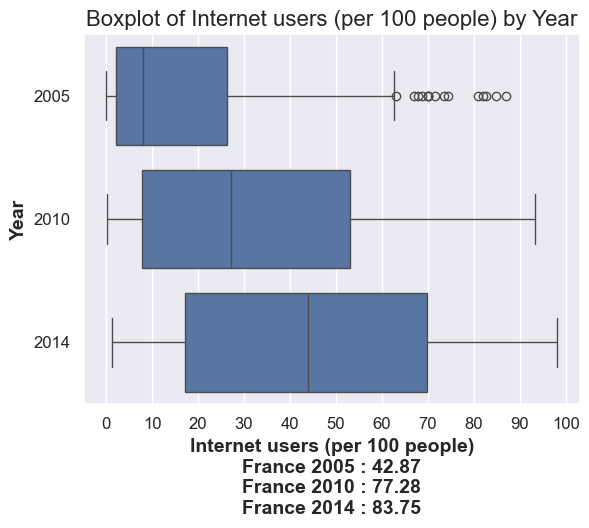

In [108]:
# créer une fonction pour afficher la boite à moustaches de chaque indicateur, par années
def displayBoxPlotByYear(df, indicator, graduation):
    sns.boxplot(y='Year', x=indicator, data=df)
    plt.title('Boxplot of ' + indicator + ' by Year', fontsize=16)
    plt.ylabel('Year', fontsize=14, fontweight='bold')

    # Ajouter repère pour la France
    france_value = df.loc[df['Country Name'] == 'France', indicator]
    plt.xlabel(indicator + "\n" 
              + "France 2005 : " + str(formatted(france_value.values[0])) + "\n"
              + "France 2010 : " + str(formatted(france_value.values[1])) + "\n"
              + "France 2014 : " + str(formatted(france_value.values[2])), fontsize=14, fontweight='bold')
    plt.yticks(fontsize=12)
    plt.xticks(graduation, fontsize=12)
    
    plt.show()

graduation = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
displayBoxPlotByYear(echantillon_pivoted, 'Internet users (per 100 people)', graduation)


On voit sur ces boxplots une amélioration significative entre 2005 et 2014 de l'utilisation d'internet. 
En 2005, il y avait de nombreux outliers sur la droite, ce qui met en évidence qu'en 2005 les pays avec une bonne utilisation internet étaient peu nombreux, et ceux avec une amauvaise, voir aucune utilisation internet étaient beaucoup plus nombreux. C'est ce que confirme la concentration à gauche de la boxplot, et la médiane très à gauche dans la boxplot.
En 2014, la distribution sur cette variable est beaucoup plus normale (homogène). Confirmé par a médiane qui est centrée dans la boxplot. Il n'y a plus d'outliers, mais ces extrêmes s'écartent beaucoup. 



#### 4.2.1.3 - Distribution empirique
Comme il s'agit d'une variable quantitative continue, la forme la plus appropriée est l'histogramme. La discrétisation sera réalisée de façon automatique.

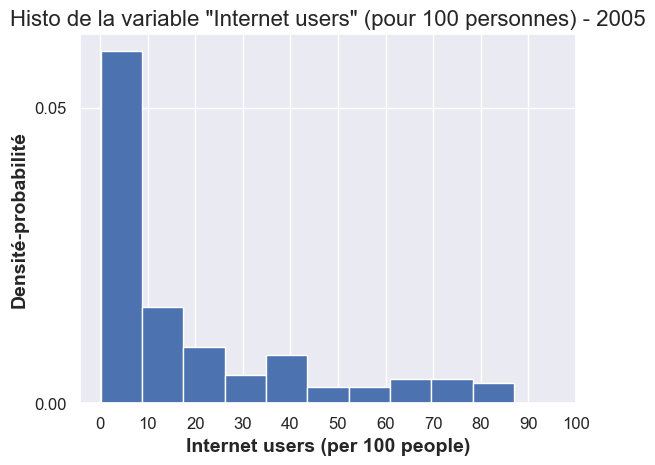

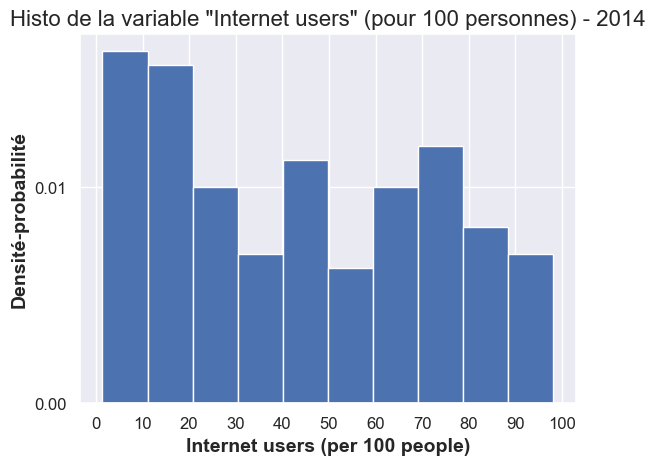

In [111]:
# Histogramme 2005
mask = echantillon_pivoted['Year'] == '2005'
echantillon_pivoted.loc[mask, "Internet users (per 100 people)"].hist(density=True, bins=10)

plt.title('Histo de la variable "Internet users" (pour 100 personnes) - 2005', fontsize=16)
plt.xlabel('Internet users (per 100 people)', fontsize=14, fontweight='bold')
plt.ylabel('Densité-probabilité', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fontsize=12)
# Affichage du quadrillage
plt.grid(True)

plt.show()

# Histogramme 2014
mask = echantillon_pivoted['Year'] == '2014'
echantillon_pivoted.loc[mask, "Internet users (per 100 people)"].hist(density=True, bins=10)

plt.title('Histo de la variable "Internet users" (pour 100 personnes) - 2014', fontsize=16)
plt.xlabel('Internet users (per 100 people)', fontsize=14, fontweight='bold')
plt.ylabel('Densité-probabilité', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fontsize=12)
# Affichage du quadrillage
plt.grid(True)

plt.show()

#### 4.2.1.4 - Répartition par région en 2014

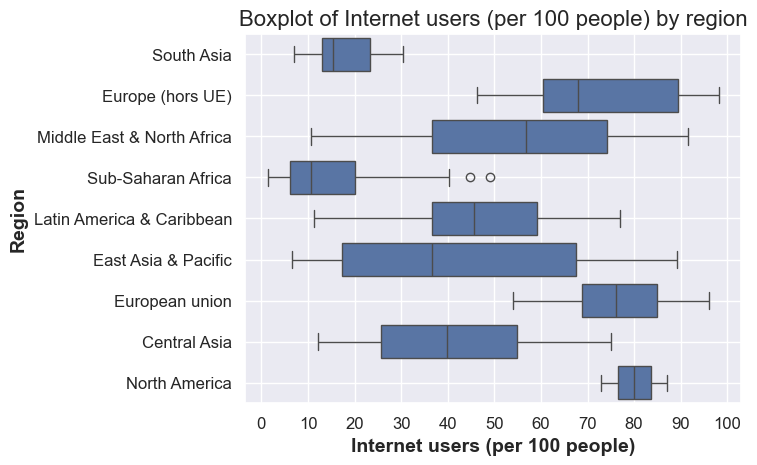

In [113]:
# Afficher la répartition par région sous forme de boxplot pour plus de clarté
mask = echantillon_pivoted['Year'] == '2014'
sous_echantillon = echantillon_pivoted.loc[mask, ["Internet users (per 100 people)", "Region"]]
sns.boxplot(y='Region', x='Internet users (per 100 people)', data=sous_echantillon)

plt.title('Boxplot of Internet users (per 100 people)' + ' by region', fontsize=16)
plt.ylabel('Region', fontsize=14, fontweight='bold')
plt.xlabel('Internet users (per 100 people)', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fontsize=12)
plt.grid(True)

plt.show()

Ces représentations régionales montrent bien la disparité géographique de l'accès à internet.
- On voit clairement que l'Amérique du Nord dispose d'un bon accès internet pour tous les pays de cette région. Comme il n'y a que 2 pays au niveau de vie très proche, la boîte est concentrée
- L'Asie du sud et l'Afrique sub saharienne sont défavorisées
- La région Europe et Union Européenne sont assez étendues.
- Les données des autres régions sont très dispersées.
- On note la présence de 2 outliers en Afrique (L'île Maurice et l'Afrique du Sud, trouvés ci-dessous).
- La région "East Asie et Pacific" est la plus étendue, et avec une médiane qui tend vers la gauche.

In [115]:
# rechercher les 2 outliers de la région Sub-Saharan Africa
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Region'] == 'Sub-Saharan Africa')
sous_echantillon = echantillon_pivoted.loc[mask, ["Internet users (per 100 people)", "Country Name"]]
sous_echantillon.sort_values(by='Internet users (per 100 people)', ascending=False).head(2)

Indicator Name  Internet users (per 100 people)  Country Name
523                                   49.000000  South Africa
377                                   44.803275     Mauritius

Les 2 outliers de la région Sub-Saharan Africa sont :
- L'île Maurice
- L'Afrique du Sud

#### 4.2.1.5 - Mesures de tendance centrale en 2014

In [118]:
# Calcul de la classe modale en 2014
mask = echantillon_pivoted['Year'] == '2014'
modal = echantillon_pivoted.loc[mask, ["Internet users (per 100 people)"]].mode()
print("La classe modale en 2014, c'est à dire la classe la plus fréquente est :", modal)

La classe modale en 2014, c'est à dire la classe la plus fréquente est : Indicator Name  Internet users (per 100 people)
0                                           7.0


Comme on a une distribution bimodale en 2014, le calcul du mode renvoie 2 valeurs. L'interval 0-10 est le plus fréquent, et l'interval 70-80 est le 2ème plus fréquent.

La moyenne calculée précédemment est de 44.14 utilisateurs d'internet pour 100 personnes, et la médiane est de 44.

#### 4.2.1.5 - Mesures de dispersion en 2014

In [122]:
# Calculer la variance empirique en 2014
mask = echantillon_pivoted['Year'] == '2014'
variance = echantillon_pivoted.loc[mask, "Internet users (per 100 people)"].var()
print("La variance empirique en 2014 vaut", round(variance, 2))

La variance empirique en 2014 vaut 829.43


In [123]:
# calculer l'écart-type empirique en 2014
mask = echantillon_pivoted['Year'] == '2014'
ecart_type = echantillon_pivoted.loc[mask, "Internet users (per 100 people)"].std()
print("L'écart-type empirique en 2014 vaut", round(ecart_type, 2))

L'écart-type empirique en 2014 vaut 28.8


In [124]:
# calculer le coefficient de variation en 2014
mask = echantillon_pivoted['Year'] == '2014'
coef_variation = echantillon_pivoted.loc[mask, "Internet users (per 100 people)"].std() / echantillon_pivoted.loc[mask, "Internet users (per 100 people)"].mean()
print("Le coefficient de variation en 2014 vaut", round(coef_variation * 100, 2), '%')

Le coefficient de variation en 2014 vaut 65.25 %


Le coefficient de variation montre une grande dispersion autour de la moyenne. 
Rappel :
- CV < 10% : Faible variabilité, les valeurs sont assez cohérentes.
- 10% < CV < 30% : Variabilité modérée.
- CV > 30% : Haute variabilité, les valeurs montrent une grande dispersion autour de la moyenne.

In [126]:
# calculer le coefficient de variation en 2014 pour l'union européenne
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Region'] == 'European union')
coef_variation = echantillon_pivoted.loc[mask, "Internet users (per 100 people)"].std() / echantillon_pivoted.loc[mask, "Internet users (per 100 people)"].mean()
print("Le coefficient de variation en 2014 vaut", round(coef_variation * 100, 2), "%  pour l'union européenne")

Le coefficient de variation en 2014 vaut 15.67 %  pour l'union européenne


On voit que pour l'union européenne le coeeficient de variation est beaucoup plus faible : 15.67%

#### 4.2.1.5 - Mesures de forme en 2014

In [129]:
# calculer le skewness empirique (mesure d'asymétrie)
mask = echantillon_pivoted['Year'] == '2014'
skewness = echantillon_pivoted.loc[mask, "Internet users (per 100 people)"].skew()
print("Le skewness en 2014 vaut", round(ecart_type, 2))

Le skewness en 2014 vaut 28.8


Le skewness empirique indique une asymétrie plutôt concentrée à gauche (ou étalée à droite).
On n'étudie pas ici l'aplatissement avec le kurtosis empirique, car la distribution est asymétrique. Le kurtosis est réservée aux distributions symétriques.

### 4.2.2 - GDP per capita

#### 4.2.2.1 - Statistiques de base

In [133]:
years = echantillon_pivoted['Year'].unique()

for year in years:
    print('year :', year)
    print()
    summary = echantillon_pivoted.loc[echantillon_pivoted['Year'] == year, 'GDP per capita (current US$)'].describe()
    # Affichage formaté des statistiques
    print('Indicateur : GDP per capita (current US$)')
    print('  - Moyenne    :', formatted(summary.loc['mean']))
    print('  - Ecart-type :', formatted(summary.loc['std']))
    print('  - Médiane    :', formatted(summary.loc['50%']))
    print('  - Valeur max :', formatted(summary.loc['max']))
    print('  - Valeur min :', formatted(summary.loc['min']))
    print()

year : 2005

Indicateur : GDP per capita (current US$)
  - Moyenne    : 9,953.89
  - Ecart-type : 15,249.91
  - Médiane    : 3,029.85
  - Valeur max : 80,289.70
  - Valeur min : 150.51

year : 2010

Indicateur : GDP per capita (current US$)
  - Moyenne    : 13,073.57
  - Ecart-type : 18,543.02
  - Médiane    : 4,542.90
  - Valeur max : 104,965.31
  - Valeur min : 231.19

year : 2014

Indicateur : GDP per capita (current US$)
  - Moyenne    : 15,128.96
  - Ecart-type : 21,480.43
  - Médiane    : 5,540.98
  - Valeur max : 119,225.38
  - Valeur min : 312.75



#### 4.2.2.2 - Boîte à moustaches

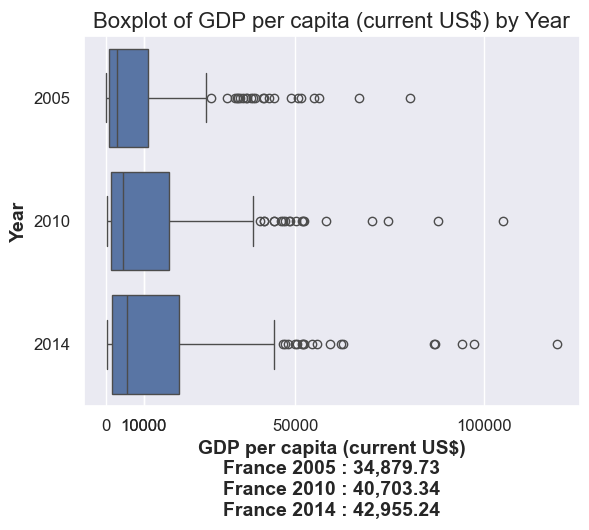

In [135]:
graduation = [0, 10000, 50000, 100000, 10000]
displayBoxPlotByYear(echantillon_pivoted, 'GDP per capita (current US$)', graduation)

- On constate que sur les 3 années, il y a beaucoup d'outliers (13). Sûrement à cause d'une forte disparité entre les différents pays. Les pays à faible GDP sont beaucoup plus nombreux que les pays à fort GDP par habitant.
- Les pays à fort GDP progresse plus vite en valeur absolue que les pays à faible GDP. Les minimums sont toujours proche de 0.
- La médiane très à gauche dans la boxplot montre une forte asymétrie vers la gauche pour les 3 années.

In [137]:
# rechercher les outliers en 2014
mask = echantillon_pivoted['Year'] == '2014'     
sous_echantillon = echantillon_pivoted.loc[mask]
outliers = sous_echantillon.sort_values(by="GDP per capita (current US$)", ascending=False).head(13)
print("Liste des pays outliers : ", outliers['Country Name'].values)

Liste des pays outliers :  ['Luxembourg' 'Norway' 'Macao SAR, China' 'Qatar' 'Switzerland' 'Denmark'
 'Australia' 'Sweden' 'Ireland' 'United States' 'Iceland' 'Netherlands'
 'Austria']


#### 4.2.2.3 - Distribution empirique en 2014
Comme il s'agit d'une variable quantitative continue, la forme la plus appropriée est l'histogramme. La discrétisation sera réalisée de façon automatique.

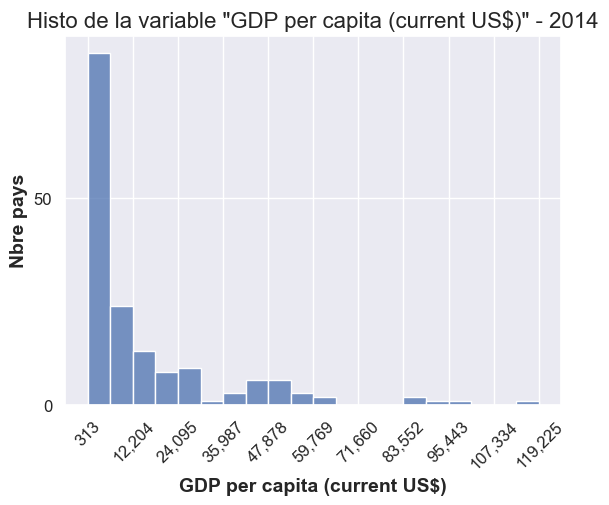

In [139]:
def formattedEntire(value):
    formatted_value = "{:,.0f}".format(value)
    return formatted_value      

# Histogramme 2014
mask = echantillon_pivoted['Year'] == '2014'
sous_echantillon = echantillon_pivoted.loc[mask, "GDP per capita (current US$)"]

# Remplacer les valeurs infinies par NaN
sous_echantillon = sous_echantillon.replace([np.inf, -np.inf], np.nan) ## c'est étonnant que j'ai le warning sur les valeurs infinies, car je n'en ai aucune dans mon dataframe

# Tracer l'histogramme
sns.histplot(sous_echantillon, bins=20)

# Désactiver la notation scientifique pour l'axe x
plt.gca().xaxis.set_major_formatter(ScalarFormatter())

plt.title('Histo de la variable "GDP per capita (current US$)" - 2014', fontsize=16)
plt.xlabel('GDP per capita (current US$)', fontsize=14, fontweight='bold')
plt.ylabel('Nbre pays', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

# Récupérer les limites des bacs
counts, bin_edges = np.histogram(sous_echantillon, bins=10)

# Définir les xticks sur les bords des bacs
plt.xticks(bin_edges, rotation=45, fontsize=12, labels=[formattedEntire(bin_edge) for bin_edge in bin_edges])

plt.grid(True)

plt.show()

L'asymétrie à gauche est confirmée sur ce diagramme

#### 4.2.2.4 - Répartition par région en 2014

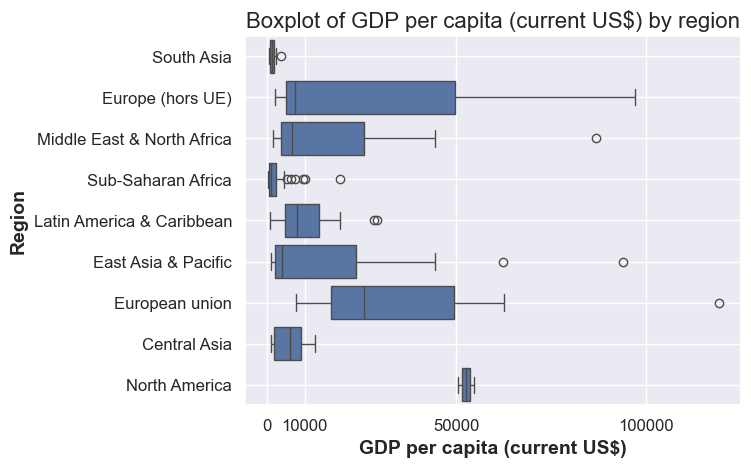

In [142]:
# Afficher la répartition par région sous forme de boxplot pour plus de clarté
mask = echantillon_pivoted['Year'] == '2014'
sous_echantillon = echantillon_pivoted.loc[mask, ["GDP per capita (current US$)", "Region"]]
sns.boxplot(y='Region', x='GDP per capita (current US$)', data=sous_echantillon)

plt.title('Boxplot of GDP per capita (current US$)' + ' by region', fontsize=16)
plt.ylabel('Region', fontsize=14, fontweight='bold')
plt.xlabel('GDP per capita (current US$)', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)
plt.xticks([0, 10000, 50000, 100000], fontsize=12)
plt.grid(True)

plt.show()

Il y a une grande disparité entre les régions, mais aussi à l'intérieur des régions. Plusieurs outliers dans certaines régions, dont un dans l'union européenne.

In [144]:
# rechercher les 2 outliers de la région Sub-Saharan Africa
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Region'] == 'East Asia & Pacific')
sous_echantillon = echantillon_pivoted.loc[mask, ["GDP per capita (current US$)", "Country Name"]]
sous_echantillon.sort_values(by='GDP per capita (current US$)', ascending=False).head(2)

Indicator Name  GDP per capita (current US$)      Country Name
347                             94004.389829  Macao SAR, China
32                              62214.609121         Australia

In [145]:
# rechercher l' outlier de l'union européenne
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Region'] == 'European union')
sous_echantillon = echantillon_pivoted.loc[mask, ["GDP per capita (current US$)", "Country Name"]]
sous_echantillon.sort_values(by='GDP per capita (current US$)', ascending=False).head(1)

Indicator Name  GDP per capita (current US$) Country Name
344                            119225.380023   Luxembourg

In [146]:
# rechercher l' outlier de Middle East & North Africa
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Region'] == 'Middle East & North Africa')
sous_echantillon = echantillon_pivoted.loc[mask, ["GDP per capita (current US$)", "Country Name"]]
sous_echantillon.sort_values(by='GDP per capita (current US$)', ascending=False).head(1)

Indicator Name  GDP per capita (current US$) Country Name
470                             86852.710189        Qatar

In [147]:
# rechercher les 2 outliers de la région Latin America & Caribbean
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Region'] == 'Latin America & Caribbean')
sous_echantillon = echantillon_pivoted.loc[mask, ["GDP per capita (current US$)", "Country Name"]]
sous_echantillon.sort_values(by='GDP per capita (current US$)', ascending=False).head(2)

Indicator Name  GDP per capita (current US$)  Country Name
467                             29000.000000   Puerto Rico
41                              28374.357941  Bahamas, The

#### 4.2.2.5 - Mesures de tendance centrale en 2014

- La moyenne calculée plus haut est : 15,128 dollars
- La médiane calculée plus haut est : 5,540 dollars

On voit encore une asymétrie vers la gauche

In [150]:
# Calcul de la classe modale en 2014
mask = echantillon_pivoted['Year'] == '2014'
modal = echantillon_pivoted.loc[mask, ["GDP per capita (current US$)"]].mode()
print("La classe modale en 2014, c'est à dire la classe la plus fréquente contient :", len(modal), "élements")

La classe modale en 2014, c'est à dire la classe la plus fréquente contient : 165 élements


Etant donné le nombre de modes calculés et retournés, on pourrait réaliser une discrétisation sur 10 catégories (bins) de cette variable, qui serait le groupe de revenus.

Voici un exemple typique basé sur les classifications de la Banque mondiale :

- Pays à faible revenu : PIB par habitant inférieur à 1 046 USD
- Pays à revenu intermédiaire de faible tranche : PIB par habitant entre 1 046 USD et 4 095 USD
- Pays à revenu intermédiaire de haute tranche : PIB par habitant entre 4 096 USD et 12 695 USD
- Pays à revenu élevé : PIB par habitant supérieur à 12 695 USD

In [152]:
# Discrétiser la variable GDP per capita du dataframe

# Définir les bornes des groupes de revenus
bins = [0, 1046, 4095, 12695, float('inf')]
labels = ['Pays à faible revenu', 
          'Pays à revenu intermédiaire de faible tranche', 
          'Pays à revenu intermédiaire de haute tranche', 
          'Pays à revenu élevé']

# Discrétiser la colonne 'GDP_per_capita'
echantillon_pivoted['Income Group'] = pd.cut(echantillon_pivoted['GDP per capita (current US$)'], bins=bins, labels=labels, right=False)
echantillon_pivoted.head()

Indicator Name Country Name            Region  Year  \
0               Afghanistan        South Asia  2005   
1               Afghanistan        South Asia  2010   
2               Afghanistan        South Asia  2014   
3                   Albania  Europe (hors UE)  2005   
4                   Albania  Europe (hors UE)  2010   

Indicator Name  GDP per capita (current US$)  \
0                                 250.294130   
1                                 553.300289   
2                                 612.069651   
3                                2709.142931   
4                                4094.358832   

Indicator Name  Gross outbound enrolment ratio, all regions, both sexes (%)  \
0                                                         0.15583             
1                                                         0.31369             
2                                                             NaN             
3                                                         5.90823             
4                                                         8.48007             

Indicator Name  Internet users (per 100 people)  Population growth (annual %)  \
0                                      1.224148                      3.870470   
1                                      4.000000                      2.812617   
2                                      7.000000                      3.183201   
3                                      6.043891                     -0.511790   
4                                     45.000000                     -0.496462   

Indicator Name  Population of the official age for primary education, both sexes (number)  \
0                                                       4145879.0                           
1                                                       5003108.0                           
2                                                       5564280.0                           
3                                                        234522.0                           
4                                                        227021.0                           

Indicator Name  Population of the official age for secondary education, both sexes (number)  \
0                                                       3292878.0                             
1                                                       3839021.0                             
2                                                       4676453.0                             
3                                                        529872.0                             
4                                                        402516.0                             

Indicator Name  Population of the official age for tertiary education, both sexes (number)  \
0                                                       2304393.0                            
1                                                       2490352.0                            
2                                                       3034517.0                            
3                                                        271360.0                            
4                                                        274639.0                            

Indicator Name  Population, total  \
0                      25070798.0   
1                      28803167.0   
2                      32758020.0   
3                       3011487.0   
4                       2913021.0   

Indicator Name  Unemployment, total (% of total labor force)  \
0                                                        8.5   
1                                                        8.1   
2                                                        8.6   
3                                                       13.8   
4                                                       14.2   

Indicator Name                                   Income Group  
0                                        Pays à fai

In [153]:
# Calcul du mode de l'income group en 2014
mask = echantillon_pivoted['Year'] == '2014'
mode = echantillon_pivoted.loc[mask, ["Income Group"]].mode()
print("Le mode de l'income group en 2014 est :", mode)

Le mode de l'income group en 2014 est : Indicator Name         Income Group
0               Pays à revenu élevé


Camembert 2014 de l'income group

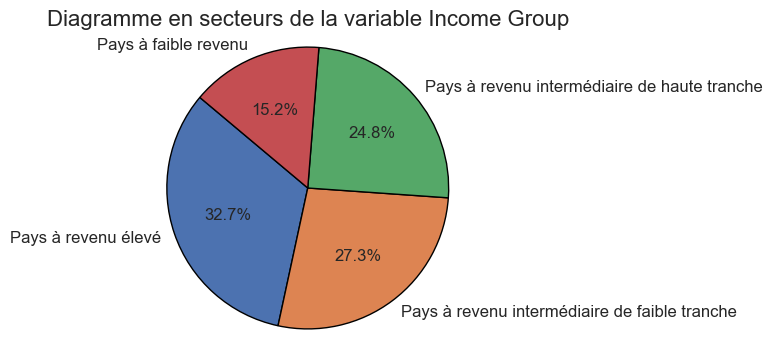

In [155]:
# Camenbert 2014
mask = echantillon_pivoted['Year'] == '2014'
sous_echantillon = echantillon_pivoted.loc[mask]

# Compter le nombre de pays dans chaque groupe de revenu
counts = sous_echantillon['Income Group'].value_counts()

# Diagramme en secteurs
plt.figure(figsize=(4, 4))
plt.pie(counts, 
        labels=counts.index, 
        autopct='%1.1f%%',  # Affiche les pourcentages avec 1 décimale
        startangle=140,     # Angle de départ pour la première tranche
        wedgeprops=dict(edgecolor='black'))  # Couleur de la bordure des secteurs

plt.title('Diagramme en secteurs de la variable Income Group', fontsize=16)
# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal')
# Personnaliser la taille des labels des secteurs
plt.setp(plt.gca().texts, fontsize=12)  # Taille des étiquettes des secteurs
plt.setp(plt.gca().patches, edgecolor='black')  # Couleur des bordures des secteurs

plt.show()

### 4.2.3 - Population, total

#### 4.2.3.1 - Statistiques de base

In [158]:
years = echantillon_pivoted['Year'].unique()

for year in years:
    print('year :', year)
    summary = echantillon_pivoted.loc[echantillon_pivoted['Year'] == year, 'Population, total'].describe()
    # Affichage formaté des statistiques
    print('Indicateur : Population, total')
    print('  - Moyenne    :', formatted(summary.loc['mean']))
    print('  - Ecart-type :', formatted(summary.loc['std']))
    print('  - Médiane    :', formatted(summary.loc['50%']))
    print('  - Valeur max :', formatted(summary.loc['max']))
    print('  - Valeur min :', formatted(summary.loc['min']))
    print()

year : 2005
Indicateur : Population, total
  - Moyenne    : 37,704,801.54
  - Ecart-type : 136,569,812.47
  - Médiane    : 8,309,839.50
  - Valeur max : 1,303,720,000.00
  - Valeur min : 101,041.00

year : 2010
Indicateur : Population, total
  - Moyenne    : 39,970,926.33
  - Ecart-type : 144,764,849.24
  - Médiane    : 9,199,259.00
  - Valeur max : 1,337,705,000.00
  - Valeur min : 104,137.00

year : 2014
Indicateur : Population, total
  - Moyenne    : 43,154,798.12
  - Ecart-type : 150,349,282.25
  - Médiane    : 9,891,790.00
  - Valeur max : 1,364,270,000.00
  - Valeur min : 105,782.00



#### 4.2.3.2 - Boîte à moustaches

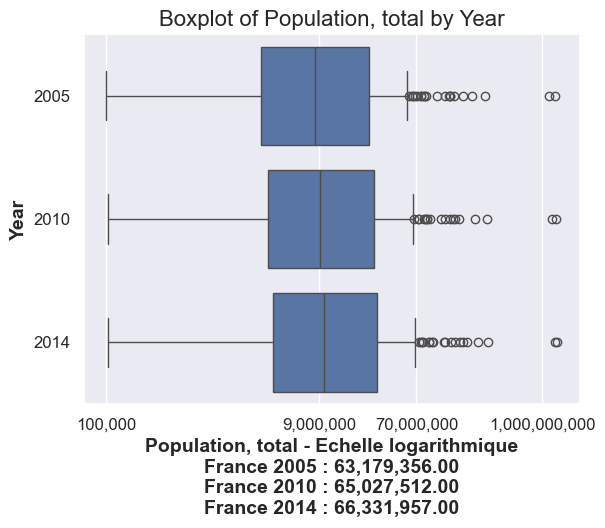

In [160]:
def formattedEntire(value):
    return "{:,}".format(value)

def displayBoxPlotByYearScaleLog(df, indicator, graduations):
    sns.boxplot(y='Year', x=indicator, data=df)
    plt.title('Boxplot of ' + indicator + ' by Year', fontsize=16)
    plt.ylabel('Year', fontsize=14, fontweight='bold')

    # Ajouter repère pour la France
    france_value = df.loc[df['Country Name'] == 'France', indicator]
    plt.xlabel(indicator + " - Echelle logarithmique\n" 
              + "France 2005 : " + str(formatted(france_value.values[0])) + "\n"
              + "France 2010 : " + str(formatted(france_value.values[1])) + "\n"
              + "France 2014 : " + str(formatted(france_value.values[2])), fontsize=14, fontweight='bold')
    plt.yticks(fontsize=12)    
    plt.xscale('log')  # Mettre l'échelle logarithmique sur l'axe des Y - nécessairement avant xticks
    plt.xticks(graduations, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations])
    plt.show()

graduations = [100000, 9000000, 70000000, 1000000000]
displayBoxPlotByYearScaleLog(echantillon_pivoted, 'Population, total', graduations)

On constate :
- la présence de nombreux outliers au-delà de 70 millions d'habitants. Dont 2 pays de plus d'1 milliards : l'Inde et la Chine. C'est pour cette raison qu'une échelle logarithmique a été utilisée pour l'axe des abscisses.
- L'évolution globale reste assez faible d'une année sur l'autre
- La médiane semble centrée dans la boxplot.

#### 4.2.3.3 Distribution empirique en 2014

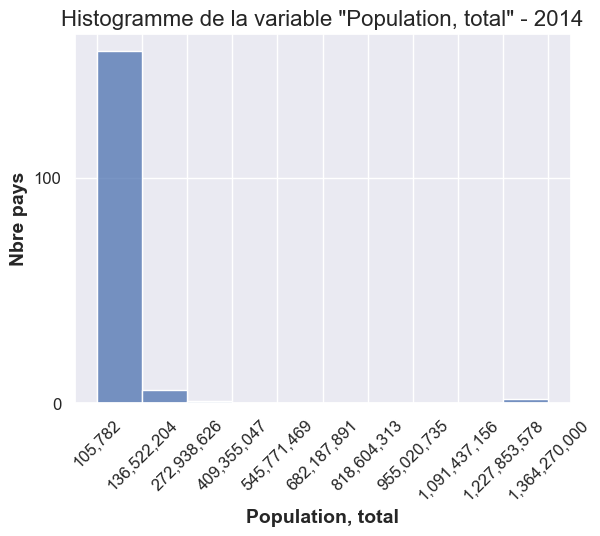

In [163]:
def formattedEntire(value):
    formatted_value = "{:,.0f}".format(value)
    return formatted_value      

# Histogramme 2014
mask = echantillon_pivoted['Year'] == '2014'
sous_echantillon = echantillon_pivoted.loc[mask, "Population, total"]

# Remplacer les valeurs infinies par NaN
sous_echantillon = sous_echantillon.replace([np.inf, -np.inf], np.nan) ## c'est étonnant que j'ai le warning sur les valeurs infinies, car je n'en ai aucune dans mon dataframe

# Tracer l'histogramme
sns.histplot(sous_echantillon, bins=10)

# Désactiver la notation scientifique pour l'axe x
plt.gca().xaxis.set_major_formatter(ScalarFormatter())

plt.title('Histogramme de la variable "Population, total" - 2014', fontsize=16)
plt.xlabel('Population, total', fontsize=14, fontweight='bold')
plt.ylabel('Nbre pays', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

# Récupérer les limites des bacs
counts, bin_edges = np.histogram(sous_echantillon, bins=10)

# Définir les xticks sur les bords des bacs
plt.xticks(bin_edges, rotation=45, fontsize=12, labels=[formattedEntire(bin_edge) for bin_edge in bin_edges])

plt.grid(True)

plt.show()

In [164]:
# Calculer le skewness empirique
print("Le skewness est : ", echantillon_pivoted['Population, total'].skew())

Le skewness est :  7.889104313568324


Le skewness de 7,89 indique une asymétrie, avec une contration sur la gauche (étalement sur la droite)

#### 4.2.3.4 Répartition par région en 2014
En excluant les 2 outliers que sont la Chine et l'Inde

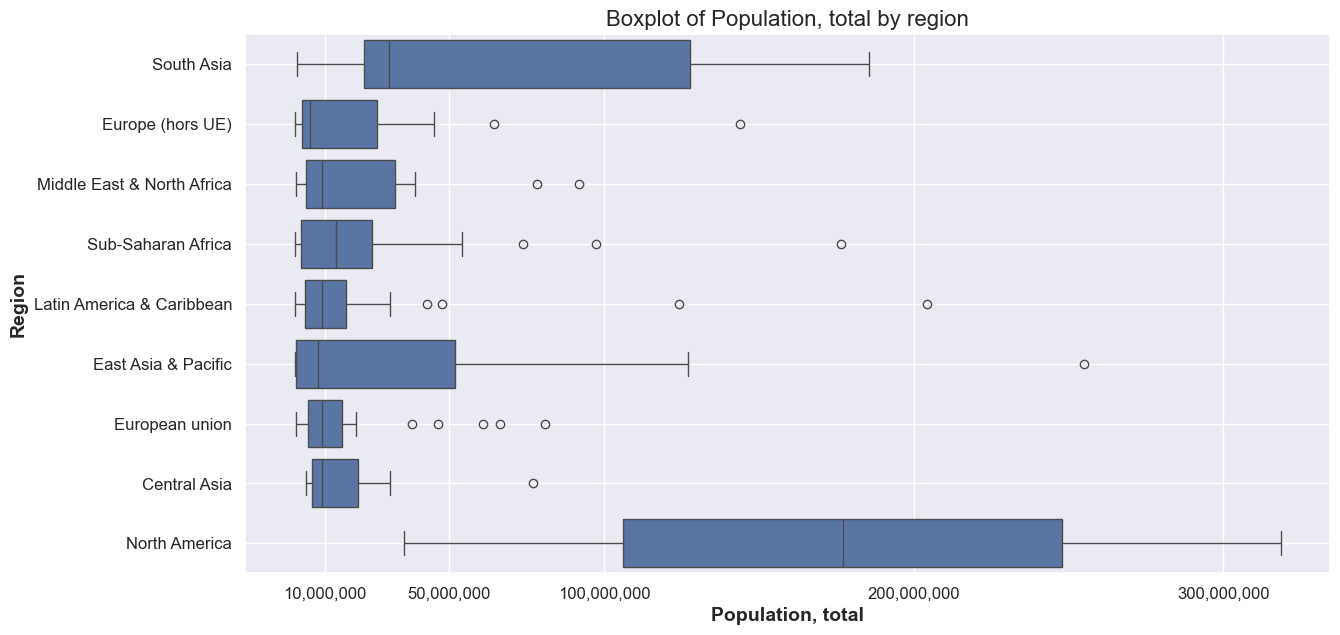

In [167]:
def formattedEntire(value):
    return "{:,}".format(value)

# Afficher la répartition par région sous forme de boxplot pour plus de clarté
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Country Name'] != 'China') & (echantillon_pivoted['Country Name'] != 'India')
sous_echantillon = echantillon_pivoted.loc[mask, ["Population, total", "Region"]]

plt.figure(figsize=(14, 7))

sns.boxplot(y='Region', x='Population, total', data=sous_echantillon)

plt.title('Boxplot of Population, total' + ' by region', fontsize=16)
plt.ylabel('Region', fontsize=14, fontweight='bold')
plt.xlabel('Population, total', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

graduations = [10000000, 50000000, 100000000, 200000000, 300000000]
plt.xticks(graduations, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations])

plt.grid(True)

plt.show()

- Chaque région possède des outliers.
- Hormis South Asia et North America, les régions sont très concentrées vers la gauche.
- L'Amérique du Nord ne contient que 2 pays : le Canada (valeur minimale) et les Etats-Unis (valeur maximale). C'est pour cette raison que la médiane est bien centrée
- La médiane en South Asia montre asymétrie vers la gauche. La médiane est très à gauche

In [169]:
# rechercher les outliers de l'union européenne
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Region'] == 'European union')
sous_echantillon = echantillon_pivoted.loc[mask, ["Population, total", "Country Name"]]
sous_echantillon.sort_values(by='Population, total', ascending=False).head(5)

Indicator Name  Population, total Country Name
218                    80982500.0      Germany
203                    66331957.0       France
284                    60789140.0        Italy
529                    46480882.0        Spain
461                    38011735.0       Poland

### 4.2.4 - Population growth

#### 4.2.4.1 - Statistiques de base

In [172]:
years = echantillon_pivoted['Year'].unique()

for year in years:
    print('year :', year)
    summary = echantillon_pivoted.loc[echantillon_pivoted['Year'] == year, 'Population growth (annual %)'].describe()
    # Affichage formaté des statistiques
    print('Indicateur : Population growth (annual %)')
    print('  - Moyenne    :', round(summary.loc['mean'], 2))
    print('  - Ecart-type :', round(summary.loc['std'], 2))
    print('  - Médiane    :', round(summary.loc['50%'], 2))
    print('  - Valeur max :', round(summary.loc['max'], 2))
    print('  - Valeur min :', round(summary.loc['min'], 2))
    print()

year : 2005
Indicateur : Population growth (annual %)
  - Moyenne    : 1.62
  - Ecart-type : 1.71
  - Médiane    : 1.45
  - Valeur max : 13.08
  - Valeur min : -1.63

year : 2010
Indicateur : Population growth (annual %)
  - Moyenne    : 1.6
  - Ecart-type : 1.59
  - Médiane    : 1.38
  - Valeur max : 11.22
  - Valeur min : -2.1

year : 2014
Indicateur : Population growth (annual %)
  - Moyenne    : 1.52
  - Ecart-type : 1.33
  - Médiane    : 1.37
  - Valeur max : 6.5
  - Valeur min : -1.63



#### 4.2.4.2 - Boîte à moustaches

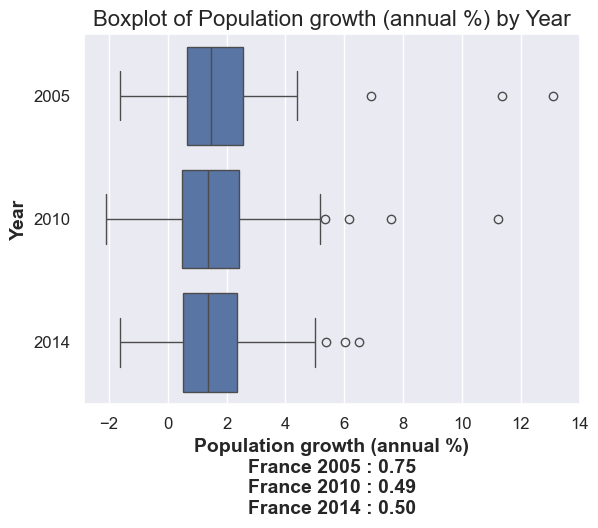

In [174]:
graduations = [-2, 0, 2, 4, 6, 8, 10, 12, 14]
displayBoxPlotByYear(echantillon_pivoted, 'Population growth (annual %)', graduations)

Quels sont les outliers en 2014 ?

In [176]:
# rechercher les 3 outliers en 2014
mask = (echantillon_pivoted['Year'] == '2014')
sous_echantillon = echantillon_pivoted.loc[mask, ["Population growth (annual %)", "Country Name"]]
sous_echantillon.sort_values(by='Population growth (annual %)', ascending=False).head(3)

Indicator Name  Population growth (annual %) Country Name
437                                 6.504660         Oman
326                                 6.016439      Lebanon
470                                 5.361236        Qatar

In [177]:
# rechercher les 4 outliers en 2010
mask = (echantillon_pivoted['Year'] == '2010')
sous_echantillon = echantillon_pivoted.loc[mask, ["Population growth (annual %)", "Country Name"]]
sous_echantillon.sort_values(by='Population growth (annual %)', ascending=False).head(4)

Indicator Name  Population growth (annual %)          Country Name
469                                11.220686                 Qatar
605                                 7.587098  United Arab Emirates
313                                 6.161251                Kuwait
436                                 5.352636                  Oman

Quels sont les pays en croissance négative en 2014 ?

In [179]:
# rechercher les pays en croissance négative
mask = (echantillon_pivoted['Population growth (annual %)'] <= 0) & (echantillon_pivoted['Year'] == '2014')
sous_echantillon = echantillon_pivoted.loc[mask, ["Population growth (annual %)", "Country Name"]]
print(sous_echantillon.sort_values(by='Population growth (annual %)', ascending=True))

Indicator Name  Population growth (annual %) Country Name
467                                -1.633128  Puerto Rico
215                                -1.306163      Georgia
323                                -0.941743       Latvia
341                                -0.859827    Lithuania
224                                -0.666113       Greece
89                                 -0.568389     Bulgaria
464                                -0.539190     Portugal
603                                -0.479616      Ukraine
497                                -0.469489       Serbia
146                                -0.407343      Croatia
473                                -0.374575      Romania
529                                -0.298951        Spain
257                                -0.269379      Hungary
188                                -0.262256      Estonia
5                                  -0.207047      Albania
290                                -0.132694        Japan
461           

#### 4.2.4.3 - Histogramme en 2014

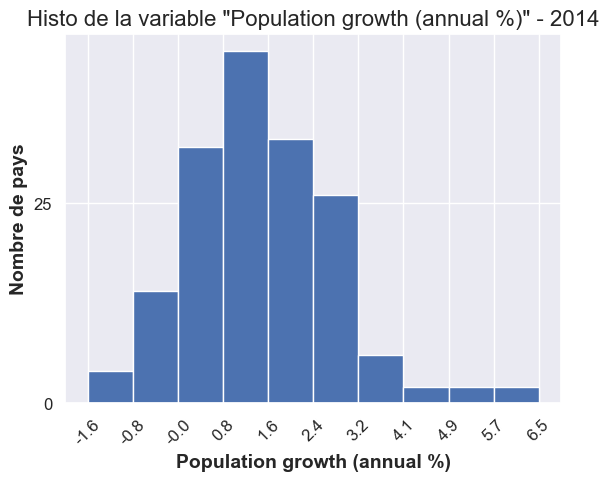

In [181]:
# Histogramme 2014
mask = echantillon_pivoted['Year'] == '2014'
sous_echantillon = echantillon_pivoted.loc[mask, "Population growth (annual %)"]
sous_echantillon.hist(density=False, bins=10)

plt.title('Histo de la variable "Population growth (annual %)" - 2014', fontsize=16)
plt.xlabel('Population growth (annual %)', fontsize=14, fontweight='bold')
plt.ylabel('Nombre de pays', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

# Récupérer les limites des bacs
counts, bin_edges = np.histogram(sous_echantillon, bins=10)

# Définir les xticks sur les bords des bacs
plt.xticks(bin_edges, rotation=45, fontsize=12, labels=[round(bin_edge, 1) for bin_edge in bin_edges])

# Affichage du quadrillage
plt.grid(True)

plt.show()

#### 4.2.4.4 - Répartition par région en 2014

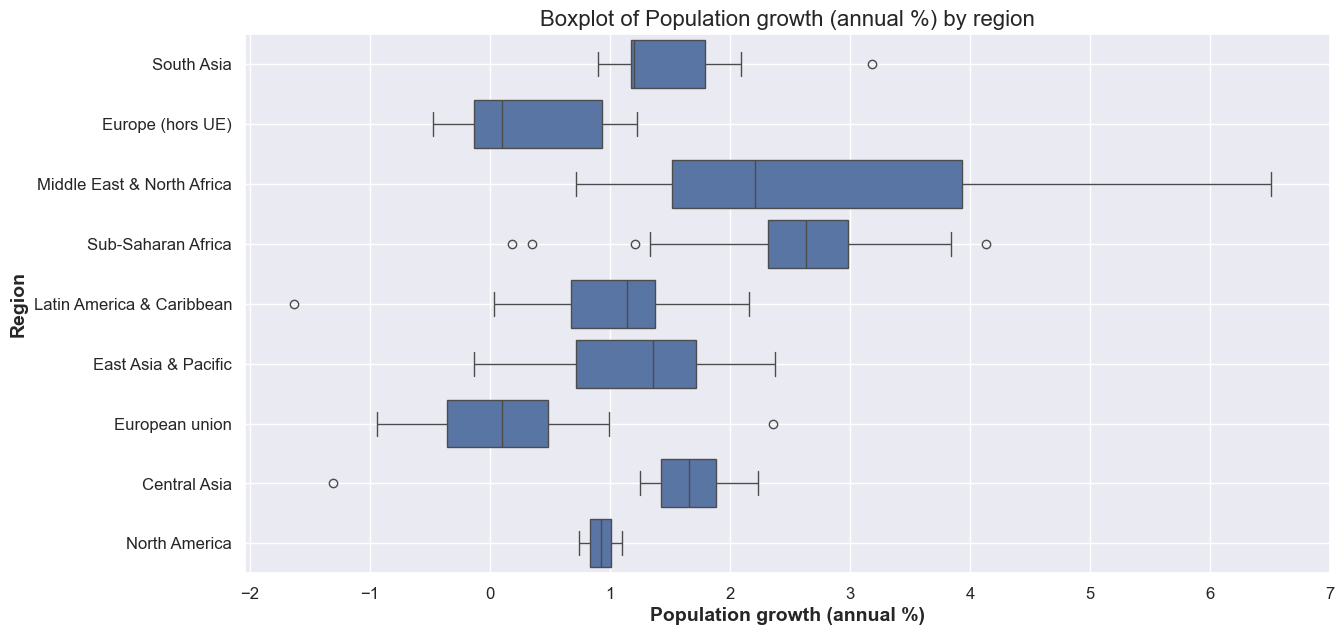

In [183]:
def formattedEntire(value):
    return "{:,}".format(value)

# Afficher la répartition par région sous forme de boxplot pour plus de clarté
mask = (echantillon_pivoted['Year'] == '2014')
sous_echantillon = echantillon_pivoted.loc[mask, ["Population growth (annual %)", "Region"]]

plt.figure(figsize=(14, 7))

sns.boxplot(y='Region', x='Population growth (annual %)', data=sous_echantillon)

plt.title('Boxplot of Population growth (annual %)' + ' by region', fontsize=16)
plt.ylabel('Region', fontsize=14, fontweight='bold')
plt.xlabel('Population growth (annual %)', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

graduations = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7]
plt.xticks(graduations, fontsize=12)

plt.grid(True)

plt.show()

### 4.2.5 - Gross outbound enrolment ratio, all regions, both sexes

#### 4.2.5.1 - Statistiques de base

In [186]:
years = ["2005", "2010"]

for year in years:
    print('year :', year)
    summary = echantillon_pivoted.loc[echantillon_pivoted['Year'] == year, 'Gross outbound enrolment ratio, all regions, both sexes (%)'].describe()
    # Affichage formaté des statistiques
    print('Indicateur : Gross outbound enrolment ratio, all regions, both sexes (%)')
    print('  - Moyenne    :', round(summary.loc['mean'], 2))
    print('  - Ecart-type :', round(summary.loc['std'], 2))
    print('  - Médiane    :', round(summary.loc['50%'], 2))
    print('  - Valeur max :', round(summary.loc['max'], 2))
    print('  - Valeur min :', round(summary.loc['min'], 2))
    print()

year : 2005
Indicateur : Gross outbound enrolment ratio, all regions, both sexes (%)
  - Moyenne    : 2.21
  - Ecart-type : 3.89
  - Médiane    : 0.92
  - Valeur max : 35.33
  - Valeur min : 0.05

year : 2010
Indicateur : Gross outbound enrolment ratio, all regions, both sexes (%)
  - Moyenne    : 2.55
  - Ecart-type : 4.35
  - Médiane    : 1.18
  - Valeur max : 40.56
  - Valeur min : 0.08



#### 4.2.5.2 - Boîte à moustaches

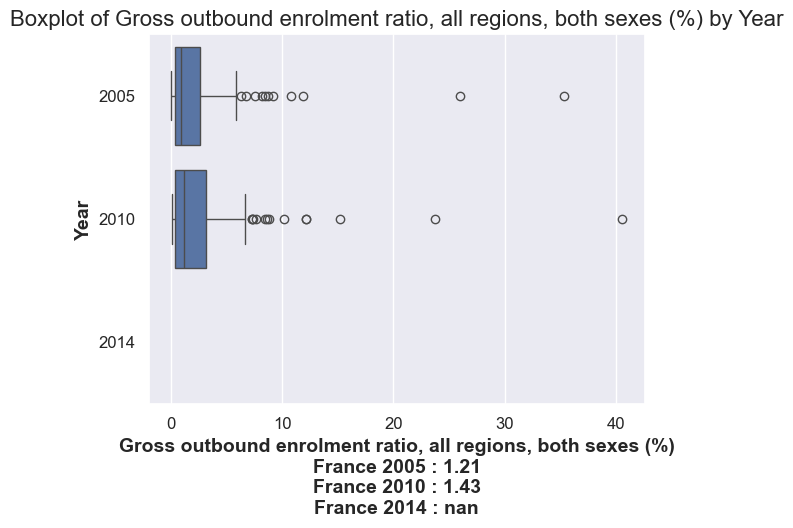

In [188]:
graduations = [0, 10, 20, 30, 40]
displayBoxPlotByYear(echantillon_pivoted, 'Gross outbound enrolment ratio, all regions, both sexes (%)', graduations)

### 4.2.6 - Population of the official age for primary education, both sexes

#### 4.2.6.1 - Statistiques de base

In [191]:
years = echantillon_pivoted['Year'].unique()

for year in years:
    print('year :', year)
    summary = echantillon_pivoted.loc[echantillon_pivoted['Year'] == year, 'Population of the official age for primary education, both sexes (number)'].describe()
    # Affichage formaté des statistiques
    print('Indicateur : Population of the official age for primary education, both sexes (number)')
    print('  - Moyenne    :', formatted(summary.loc['mean']))
    print('  - Ecart-type :', formatted(summary.loc['std']))
    print('  - Médiane    :', formatted(summary.loc['50%']))
    print('  - Valeur max :', formatted(summary.loc['max']))
    print('  - Valeur min :', formatted(summary.loc['min']))
    print()

year : 2005
Indicateur : Population of the official age for primary education, both sexes (number)
  - Moyenne    : 3,862,768.56
  - Ecart-type : 13,125,455.10
  - Médiane    : 816,384.00
  - Valeur max : 123,530,080.00
  - Valeur min : 15,112.00

year : 2010
Indicateur : Population of the official age for primary education, both sexes (number)
  - Moyenne    : 3,865,341.81
  - Ecart-type : 12,611,830.72
  - Médiane    : 832,530.00
  - Valeur max : 126,771,584.00
  - Valeur min : 13,743.00

year : 2014
Indicateur : Population of the official age for primary education, both sexes (number)
  - Moyenne    : 4,090,840.48
  - Ecart-type : 12,828,429.41
  - Médiane    : 963,285.00
  - Valeur max : 127,693,736.00
  - Valeur min : 12,823.00



#### 4.2.6.2 - Boîte à moustaches

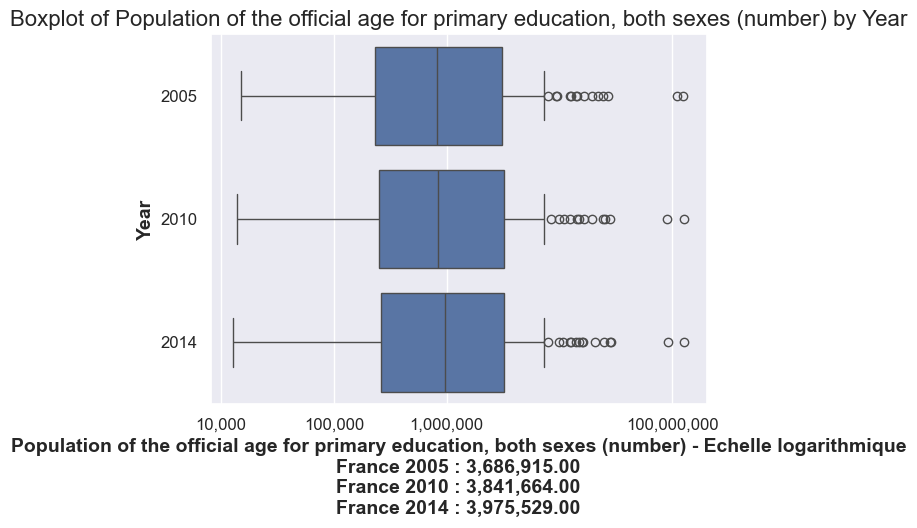

In [193]:
graduations = [10000, 100000, 1000000, 100000000]
displayBoxPlotByYearScaleLog(echantillon_pivoted, 'Population of the official age for primary education, both sexes (number)', graduations)

On constate :
- Une faible variation d'une année sur l'autre
- La présence de quelques outliers, dont l'Inde, la Chine, et plus loin les Etats-Unis.
- Il y aura un intérêt à comparer la répartition au sein ces 3 indicateurs d'éducation : primary, secondary, tertiary, et de rechercher des corrélations.

#### 4.2.6.2 - Répartition par région en 2014
En excluant les 2 outliers que sont la Chine et l'Inde

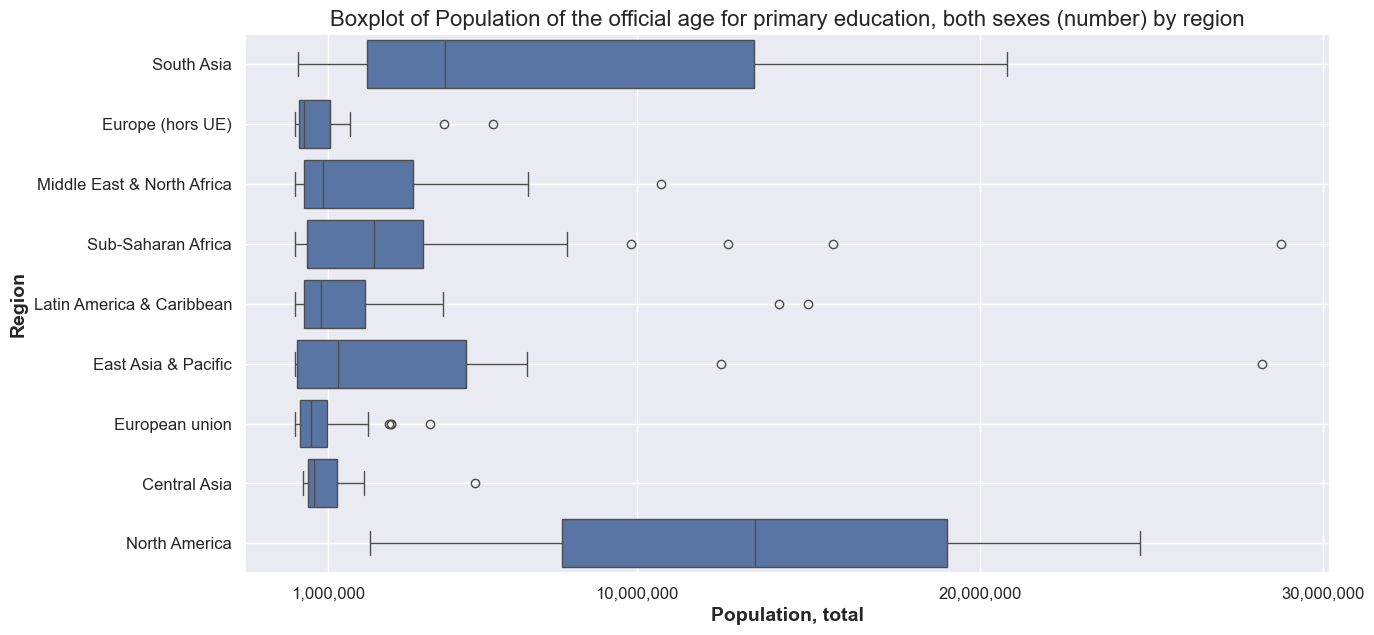

In [196]:
def formattedEntire(value):
    return "{:,}".format(value)

# Afficher la répartition par région sous forme de boxplot pour plus de clarté
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Country Name'] != 'China') & (echantillon_pivoted['Country Name'] != 'India')
sous_echantillon = echantillon_pivoted.loc[mask, ["Population of the official age for primary education, both sexes (number)", "Region"]]

plt.figure(figsize=(14, 7))

sns.boxplot(y='Region', x='Population of the official age for primary education, both sexes (number)', data=sous_echantillon)

plt.title('Boxplot of Population of the official age for primary education, both sexes (number) by region', fontsize=16)
plt.ylabel('Region', fontsize=14, fontweight='bold')
plt.xlabel('Population, total', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

graduations = [1000000, 10000000, 20000000, 30000000]
plt.xticks(graduations, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations])

plt.grid(True)

plt.show()

In [197]:
# rechercher les outliers dans le Sub-Sahara en  2014
mask = (echantillon_pivoted['Region'] == 'Sub-Saharan Africa') & (echantillon_pivoted['Year'] == '2014')
sous_echantillon = echantillon_pivoted.loc[mask, ["Population of the official age for primary education, both sexes (number)", "Country Name"]]
sous_echantillon.sort_values(by='Population of the official age for primary education, both sexes (number)', ascending=False).head(4)

Indicator Name  Population of the official age for primary education, both sexes (number)  \
428                                                    28768486.0                           
191                                                    15713962.0                           
134                                                    12652364.0                           
567                                                     9821908.0                           

Indicator Name      Country Name  
428                      Nigeria  
191                     Ethiopia  
134             Congo, Dem. Rep.  
567                     Tanzania

### 4.2.7 - Population of the official age for secondary education, both sexes

#### 4.2.7.1 - Statistiques de base

In [200]:
years = echantillon_pivoted['Year'].unique()

for year in years:
    print('year :', year)
    summary = echantillon_pivoted.loc[echantillon_pivoted['Year'] == year, 'Population of the official age for secondary education, both sexes (number)'].describe()
    # Affichage formaté des statistiques
    print('Indicateur : Population of the official age for secondary education, both sexes (number)')
    print('  - Moyenne    :', formatted(summary.loc['mean']))
    print('  - Ecart-type :', formatted(summary.loc['std']))
    print('  - Médiane    :', formatted(summary.loc['50%']))
    print('  - Valeur max :', formatted(summary.loc['max']))
    print('  - Valeur min :', formatted(summary.loc['min']))
    print()

year : 2005
Indicateur : Population of the official age for secondary education, both sexes (number)
  - Moyenne    : 4,640,401.68
  - Ecart-type : 17,603,792.97
  - Médiane    : 900,901.00
  - Valeur max : 165,141,728.00
  - Valeur min : 10,931.00

year : 2010
Indicateur : Population of the official age for secondary education, both sexes (number)
  - Moyenne    : 4,441,993.75
  - Ecart-type : 16,404,497.98
  - Médiane    : 902,154.00
  - Valeur max : 170,145,776.00
  - Valeur min : 10,626.00

year : 2014
Indicateur : Population of the official age for secondary education, both sexes (number)
  - Moyenne    : 4,509,824.72
  - Ecart-type : 15,889,525.76
  - Médiane    : 985,778.00
  - Valeur max : 174,268,896.00
  - Valeur min : 9,879.00



#### 4.2.7.2 - Boîte à moustaches

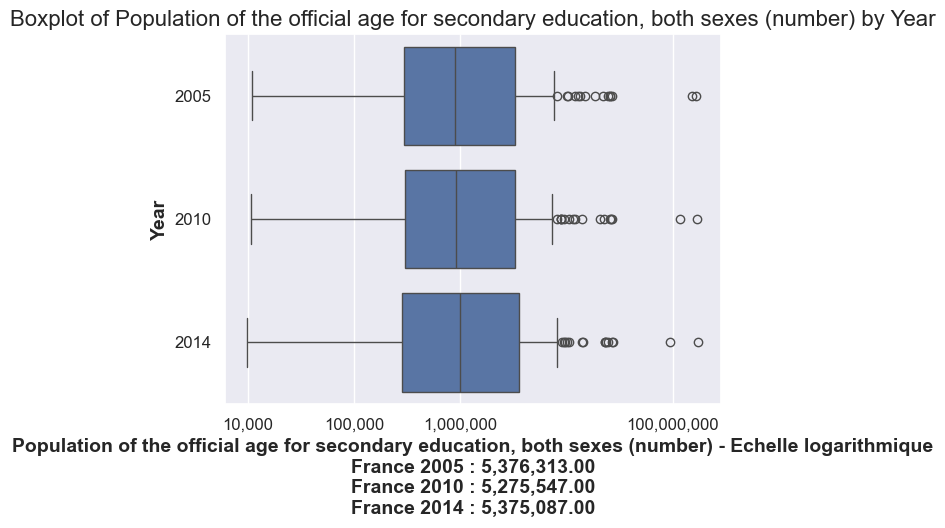

In [202]:
graduations = [10000, 100000, 1000000, 100000000]
displayBoxPlotByYearScaleLog(echantillon_pivoted, 'Population of the official age for secondary education, both sexes (number)', graduations)

#### 4.2.7.3 - Répartition par région en 2014
En excluant les 2 outliers que sont la Chine et l'Inde

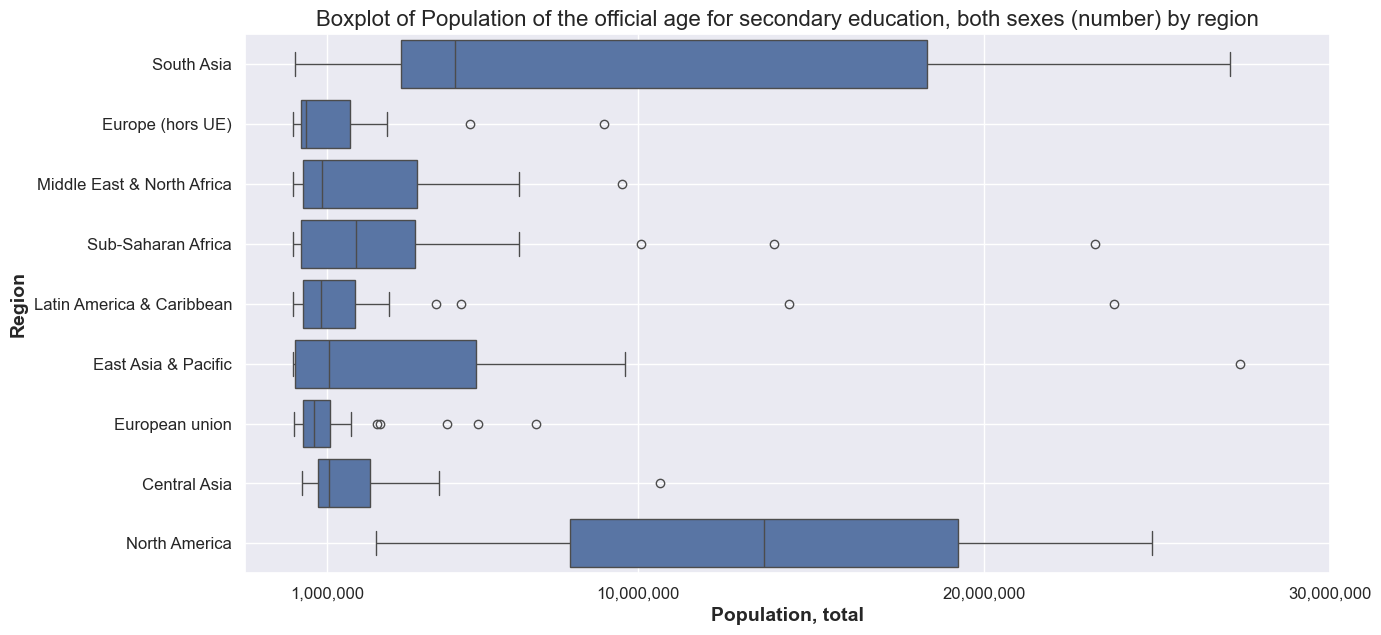

In [204]:
def formattedEntire(value):
    return "{:,}".format(value)

# Afficher la répartition par région sous forme de boxplot pour plus de clarté
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Country Name'] != 'China') & (echantillon_pivoted['Country Name'] != 'India')
sous_echantillon = echantillon_pivoted.loc[mask, ["Population of the official age for secondary education, both sexes (number)", "Region"]]

plt.figure(figsize=(14, 7))

sns.boxplot(y='Region', x='Population of the official age for secondary education, both sexes (number)', data=sous_echantillon)

plt.title('Boxplot of Population of the official age for secondary education, both sexes (number) by region', fontsize=16)
plt.ylabel('Region', fontsize=14, fontweight='bold')
plt.xlabel('Population, total', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

graduations = [1000000, 10000000, 20000000, 30000000]
plt.xticks(graduations, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations])

plt.grid(True)

plt.show()

### 4.2.8 - Population of the official age for tertiary education, both sexes

#### 4.2.8.1 - Statistiques de base

In [207]:
years = echantillon_pivoted['Year'].unique()

for year in years:
    print('year :', year)
    summary = echantillon_pivoted.loc[echantillon_pivoted['Year'] == year, 'Population of the official age for tertiary education, both sexes (number)'].describe()
    # Affichage formaté des statistiques
    print('Indicateur : Population of the official age for tertiary education, both sexes (number)')
    print('  - Moyenne    :', formatted(summary.loc['mean']))
    print('  - Ecart-type :', formatted(summary.loc['std']))
    print('  - Médiane    :', formatted(summary.loc['50%']))
    print('  - Valeur max :', formatted(summary.loc['max']))
    print('  - Valeur min :', formatted(summary.loc['min']))
    print()

year : 2005
Indicateur : Population of the official age for tertiary education, both sexes (number)
  - Moyenne    : 3,352,645.18
  - Ecart-type : 12,071,679.38
  - Médiane    : 694,267.00
  - Valeur max : 109,758,832.00
  - Valeur min : 9,769.00

year : 2010
Indicateur : Population of the official age for tertiary education, both sexes (number)
  - Moyenne    : 3,659,971.43
  - Ecart-type : 13,901,382.85
  - Médiane    : 822,487.00
  - Valeur max : 129,642,728.00
  - Valeur min : 9,874.00

year : 2014
Indicateur : Population of the official age for tertiary education, both sexes (number)
  - Moyenne    : 3,627,780.47
  - Ecart-type : 12,788,547.63
  - Médiane    : 765,877.00
  - Valeur max : 118,681,472.00
  - Valeur min : 9,831.00



#### 4.2.8.2 - Boîte à moustaches

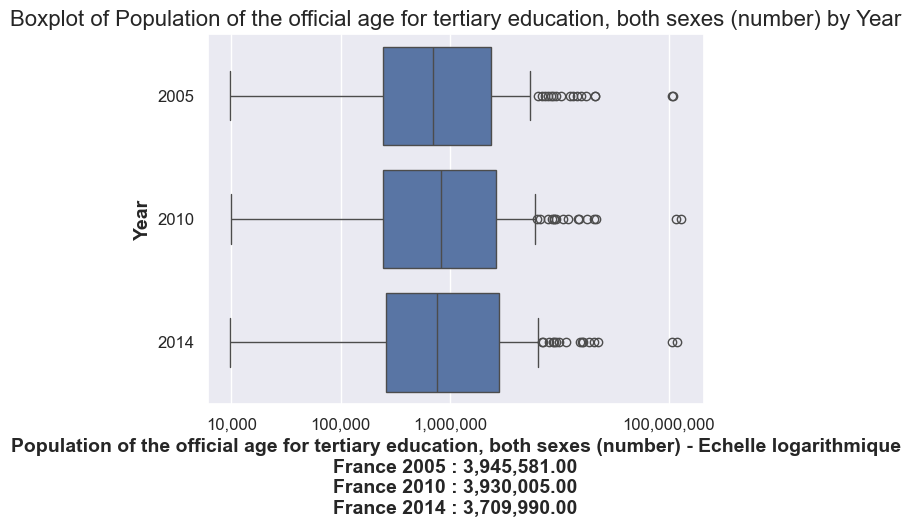

In [209]:
graduations = [10000, 100000, 1000000, 100000000]
displayBoxPlotByYearScaleLog(echantillon_pivoted, 'Population of the official age for tertiary education, both sexes (number)', graduations)

#### 4.2.8.3 - Répartition par région en 2014
En excluant les 2 outliers que sont la Chine et l'Inde

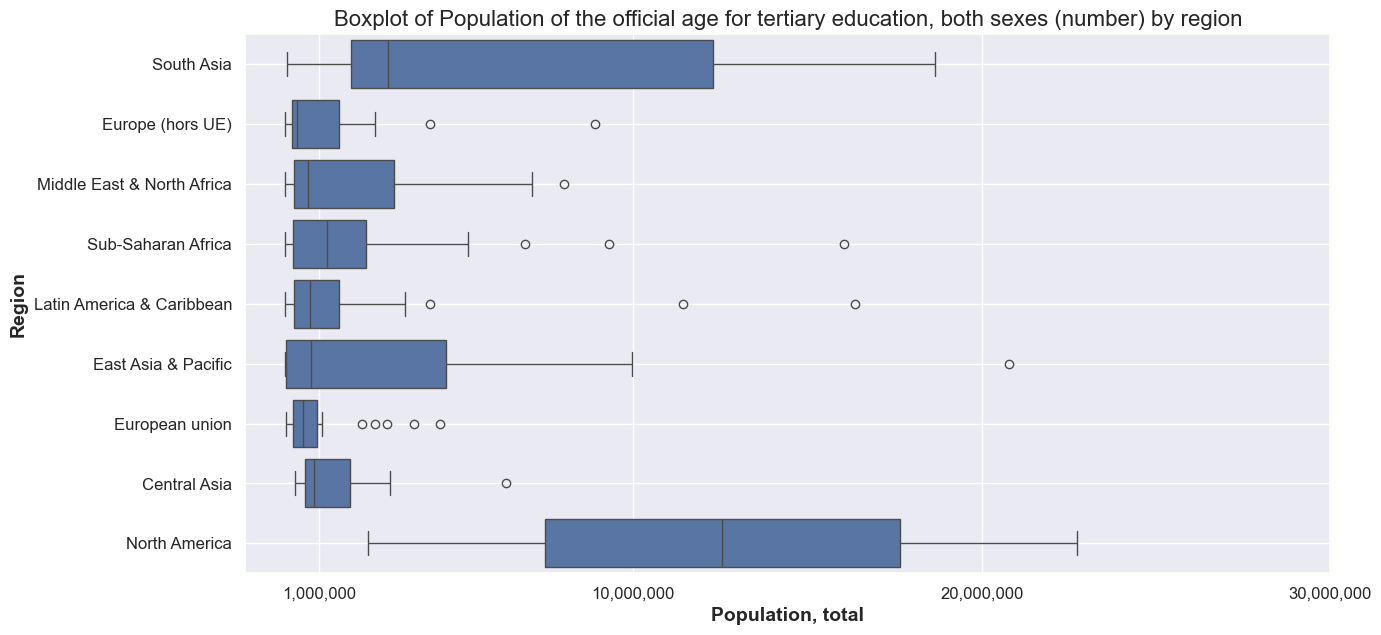

In [211]:
def formattedEntire(value):
    return "{:,}".format(value)

# Afficher la répartition par région sous forme de boxplot pour plus de clarté
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Country Name'] != 'China') & (echantillon_pivoted['Country Name'] != 'India')
sous_echantillon = echantillon_pivoted.loc[mask, ["Population of the official age for tertiary education, both sexes (number)", "Region"]]

plt.figure(figsize=(14, 7))

sns.boxplot(y='Region', x='Population of the official age for tertiary education, both sexes (number)', data=sous_echantillon)

plt.title('Boxplot of Population of the official age for tertiary education, both sexes (number) by region', fontsize=16)
plt.ylabel('Region', fontsize=14, fontweight='bold')
plt.xlabel('Population, total', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

graduations = [1000000, 10000000, 20000000, 30000000]
plt.xticks(graduations, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations])

plt.grid(True)

plt.show()

### 4.2.8 - Unemployment, total

#### 4.2.8.1 - Statistiques de base

In [214]:
years = echantillon_pivoted['Year'].unique()

for year in years:
    print('year :', year)
    summary = echantillon_pivoted.loc[echantillon_pivoted['Year'] == year, 'Unemployment, total (% of total labor force)'].describe()
    # Affichage formaté des statistiques
    print('Indicateur : Unemployment, total (% of total labor force)')
    print('  - Moyenne    :', round(summary.loc['mean'], 2))
    print('  - Ecart-type :', round(summary.loc['std'], 2))
    print('  - Médiane    :', round(summary.loc['50%'], 2))
    print('  - Valeur max :', round(summary.loc['max'], 2))
    print('  - Valeur min :', round(summary.loc['min'], 2))
    print()

year : 2005
Indicateur : Unemployment, total (% of total labor force)
  - Moyenne    : 9.17
  - Ecart-type : 6.49
  - Médiane    : 7.7
  - Valeur max : 37.3
  - Valeur min : 0.8

year : 2010
Indicateur : Unemployment, total (% of total labor force)
  - Moyenne    : 9.11
  - Ecart-type : 6.34
  - Médiane    : 7.4
  - Valeur max : 32.0
  - Valeur min : 0.4

year : 2014
Indicateur : Unemployment, total (% of total labor force)
  - Moyenne    : 8.77
  - Ecart-type : 6.39
  - Médiane    : 6.6
  - Valeur max : 31.2
  - Valeur min : 0.1



#### 4.2.8.2 - Boîte à moustaches

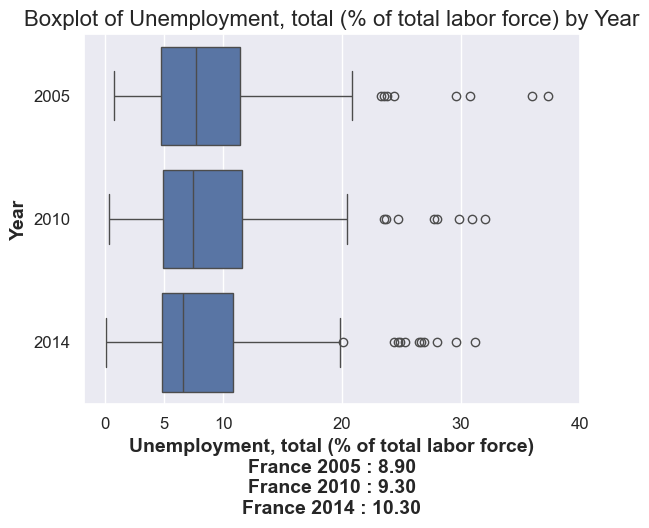

In [216]:
graduations = [0, 5, 10, 20, 30, 40]
displayBoxPlotByYear(echantillon_pivoted, 'Unemployment, total (% of total labor force)', graduations)

On constate peu d'évolution entre les 3 années, hormis le resserement des outliers

#### 4.2.9.3 - Répartition par région en 2014

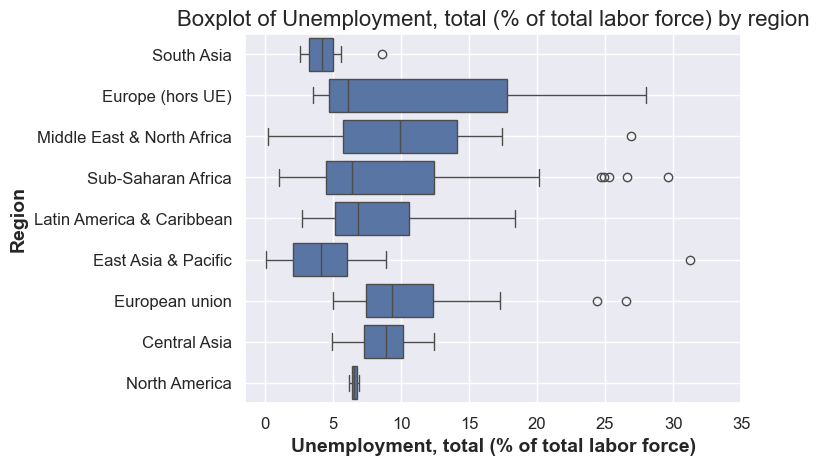

In [219]:
# Afficher la répartition par région sous forme de boxplot pour plus de clarté
mask = echantillon_pivoted['Year'] == '2014'
sous_echantillon = echantillon_pivoted.loc[mask, ["Unemployment, total (% of total labor force)", "Region"]]
sns.boxplot(y='Region', x='Unemployment, total (% of total labor force)', data=sous_echantillon)

plt.title('Boxplot of Unemployment, total (% of total labor force)' + ' by region', fontsize=16)
plt.ylabel('Region', fontsize=14, fontweight='bold')
plt.xlabel('Unemployment, total (% of total labor force)', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35], fontsize=12)
plt.grid(True)

plt.show()

- Le taux de chômage est très déséquilibré en Europe (hors UE), et dans sub-sahara.
- C'est dans l'East Asia & Pacific, et le South Asia, que la médiane du taux de chômage est la plus faible.

In [221]:
# rechercher les outliers de l'union européenne
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Region'] == 'European union')
sous_echantillon = echantillon_pivoted.loc[mask, ["Unemployment, total (% of total labor force)", "Country Name"]]
sous_echantillon.sort_values(by='Unemployment, total (% of total labor force)', ascending=False).head(2)

Indicator Name  Unemployment, total (% of total labor force) Country Name
224                                                     26.5       Greece
529                                                     24.4        Spain

La grèce et l'Espagne sont les 2 outliers de l'UE, c'était juste avant la crise de l'Euro en 2016. Depuis ces 2 pays se sont redressés.

In [223]:
# rechercher l'outlier de East Asia & Pacific
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Region'] == 'East Asia & Pacific')
sous_echantillon = echantillon_pivoted.loc[mask, ["Unemployment, total (% of total labor force)", "Country Name"]]
sous_echantillon.sort_values(by='Unemployment, total (% of total labor force)', ascending=False).head(1)

Indicator Name  Unemployment, total (% of total labor force)     Country Name
517                                                31.200001  Solomon Islands

In [224]:
# rechercher l'outlier de South Asia
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Region'] == 'South Asia')
sous_echantillon = echantillon_pivoted.loc[mask, ["Unemployment, total (% of total labor force)", "Country Name"]]
sous_echantillon.sort_values(by='Unemployment, total (% of total labor force)', ascending=False).head(1)

Indicator Name  Unemployment, total (% of total labor force) Country Name
2                                                        8.6  Afghanistan

### 4.2.10 - Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total

In [226]:
echantillon_projection.describe()

Population age 20_24 in thousands
count                         330.000000
mean                          650.363515
std                          2499.722000
min                             0.030000
25%                            15.852500
50%                            75.655000
75%                           315.860000
max                         22836.480000

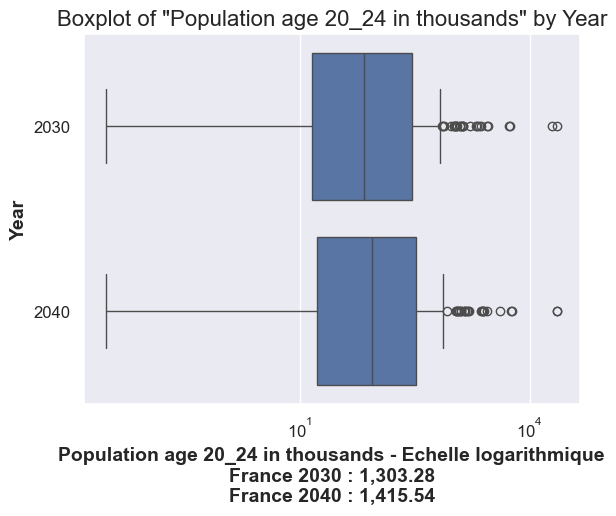

In [227]:
#graduations = [0, 800000]

sns.boxplot(y='Year', x='Population age 20_24 in thousands', data=echantillon_projection)
plt.title('Boxplot of "Population age 20_24 in thousands" by Year', fontsize=16)
plt.ylabel('Year', fontsize=14, fontweight='bold')

# Ajouter repère pour la France
france_value = echantillon_projection.loc[echantillon_projection['Country Name'] == 'France', 'Population age 20_24 in thousands']
plt.xlabel('Population age 20_24 in thousands - Echelle logarithmique\n'
              + "France 2030 : " + str(formatted(france_value.values[0])) + "\n"
              + "France 2040 : " + str(formatted(france_value.values[1])), fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)
    
plt.xscale('log')  # Mettre l'échelle logarithmique sur l'axe des Y - nécessairement avant xticks
#plt.xticks(graduations, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations])
plt.xticks(fontsize=12)
plt.show()

## 4.3 - Rechercher les corrélations

### 4.3.1 - Entre "Population of the official age for primary education" et "Population totale"

Sans l'Inde et la Chine

#### 4.3.1.1 - diagramme de dispersion

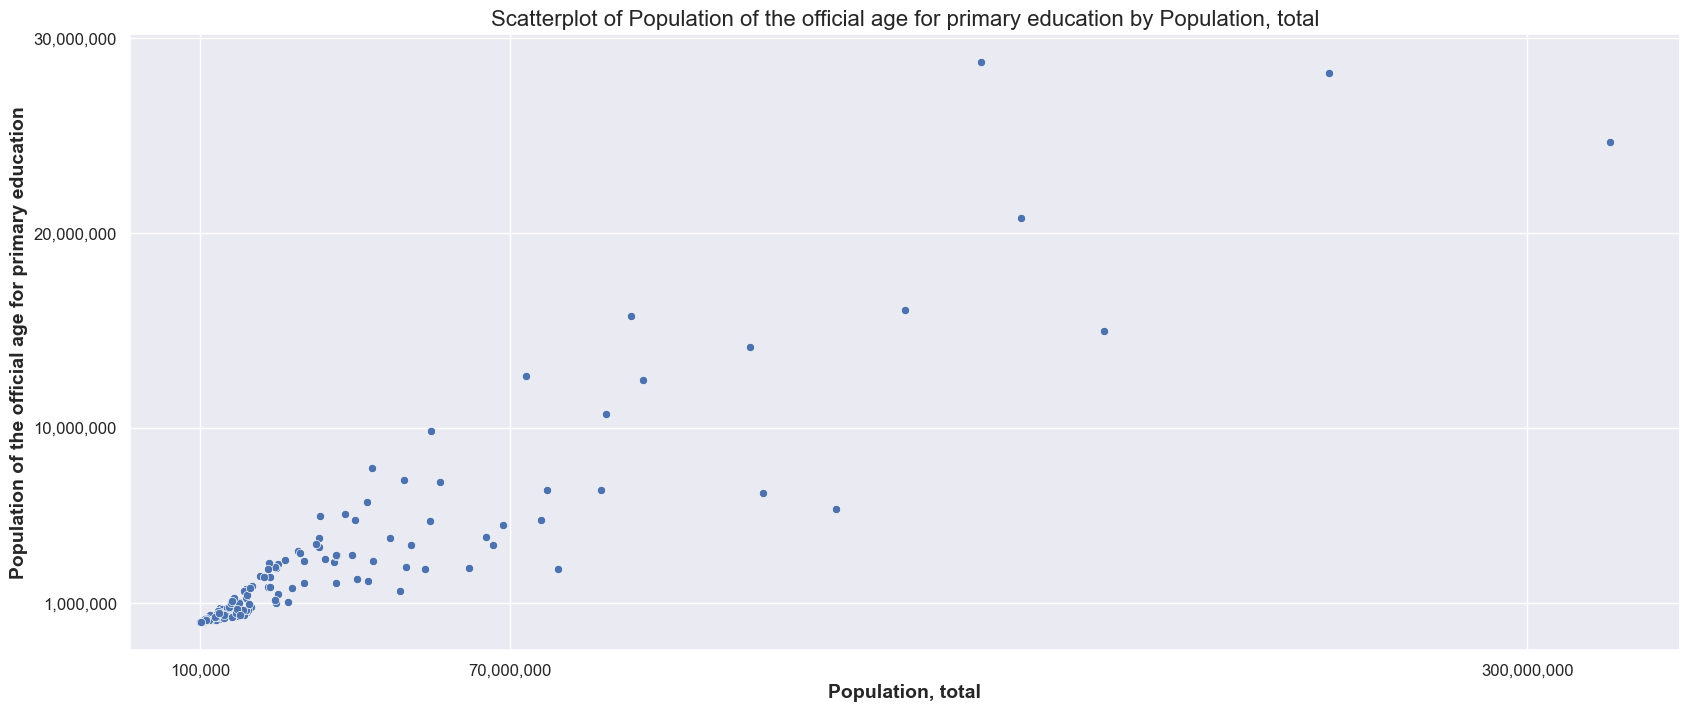

In [232]:
# Créer un sous-echantillon pour 2014
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Country Name'] != 'China') & (echantillon_pivoted['Country Name'] != 'India')
sous_echantillon = echantillon_pivoted.loc[mask]

# créer le diagramme de dispersion
plt.figure(figsize=(20, 8))
sns.scatterplot(data=sous_echantillon, x='Population, total', y='Population of the official age for primary education, both sexes (number)')

# personnaliser le graphique
plt.title('Scatterplot of Population of the official age for primary education' + ' by Population, total', fontsize=16)
plt.xlabel('Population, total', fontsize=14, fontweight='bold')
plt.ylabel('Population of the official age for primary education', fontsize=14, fontweight='bold')

graduations_x = [100000, 70000000, 300000000]
graduations_y = [1000000, 10000000, 20000000, 30000000]
plt.xticks(graduations_x, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations_x])
plt.yticks(graduations_y, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations_y])

plt.grid(True)

plt.show()

#### 4.3.1.2 - Coefficient de corrélation de Pearson

In [234]:
coef_pearson = st.pearsonr(sous_echantillon["Population, total"],sous_echantillon["Population of the official age for primary education, both sexes (number)"])[0]
covariance = np.cov(sous_echantillon["Population, total"],sous_echantillon["Population of the official age for primary education, both sexes (number)"],ddof=0)[1,0]

print("Coefficient de Pearson =", round(coef_pearson, 2))

Coefficient de Pearson = 0.92


Le coefficient de Pearson est assez proche de 1, ce qui indique une corrélation positive entre ces 2 variables. Plus l'une des 2 variables est grande, plus l'autre est grande.

#### 4.3.1.3 - Régression linéaire

In [237]:
# Calculer de a et b pour tracer la droite y = ax + b
Y = sous_echantillon['Population of the official age for primary education, both sexes (number)']
X = sous_echantillon[['Population, total']]
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['Population, total'],result.params['intercept']

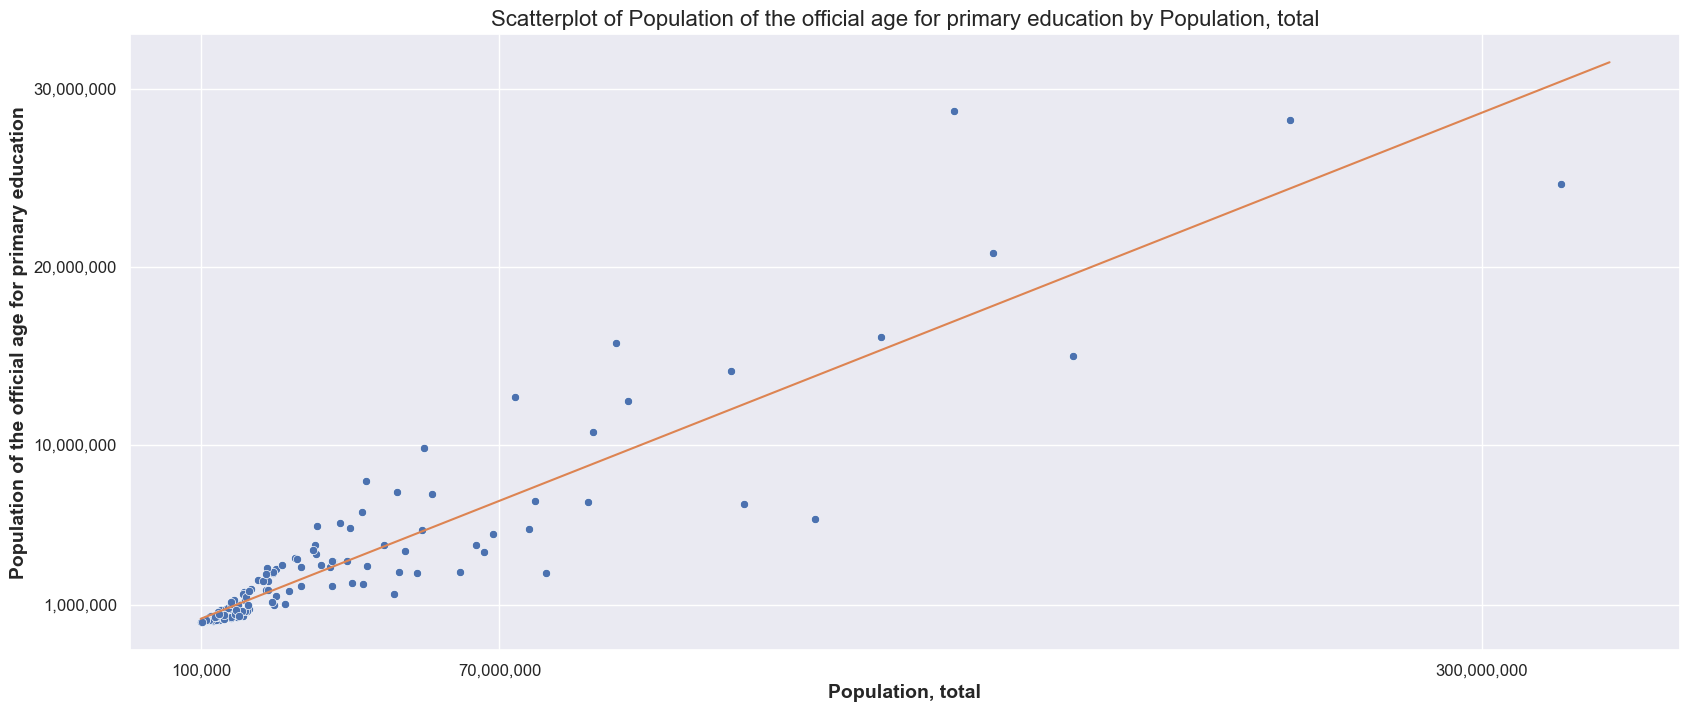

In [238]:
# créer le diagramme de dispersion
plt.figure(figsize=(20, 8))
sns.scatterplot(data=sous_echantillon, x='Population, total', y='Population of the official age for primary education, both sexes (number)')

# Tracer la droite de régression linéaire
plt.plot(np.arange(15),[a*x+b for x in np.arange(15)])

# personnaliser le graphique
plt.title('Scatterplot of Population of the official age for primary education' + ' by Population, total', fontsize=16)
plt.xlabel('Population, total', fontsize=14, fontweight='bold')
plt.ylabel('Population of the official age for primary education', fontsize=14, fontweight='bold')

graduations_x = [100000, 70000000, 300000000]
graduations_y = [1000000, 10000000, 20000000, 30000000]
plt.xticks(graduations_x, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations_x])
plt.yticks(graduations_y, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations_y])

# Tracer la droite de régression linéaire
plt.plot(np.arange(50000, 330000000, 100000),[a*x+b for x in np.arange(50000, 330000000, 100000)])

plt.show()

### 4.3.2 - Entre "Population of the official age for primary education" et "Population of the official age for secondary education, both sexes (number)"
Sans l'Inde et la Chine

#### 4.3.2.1 - diagramme de dispersion

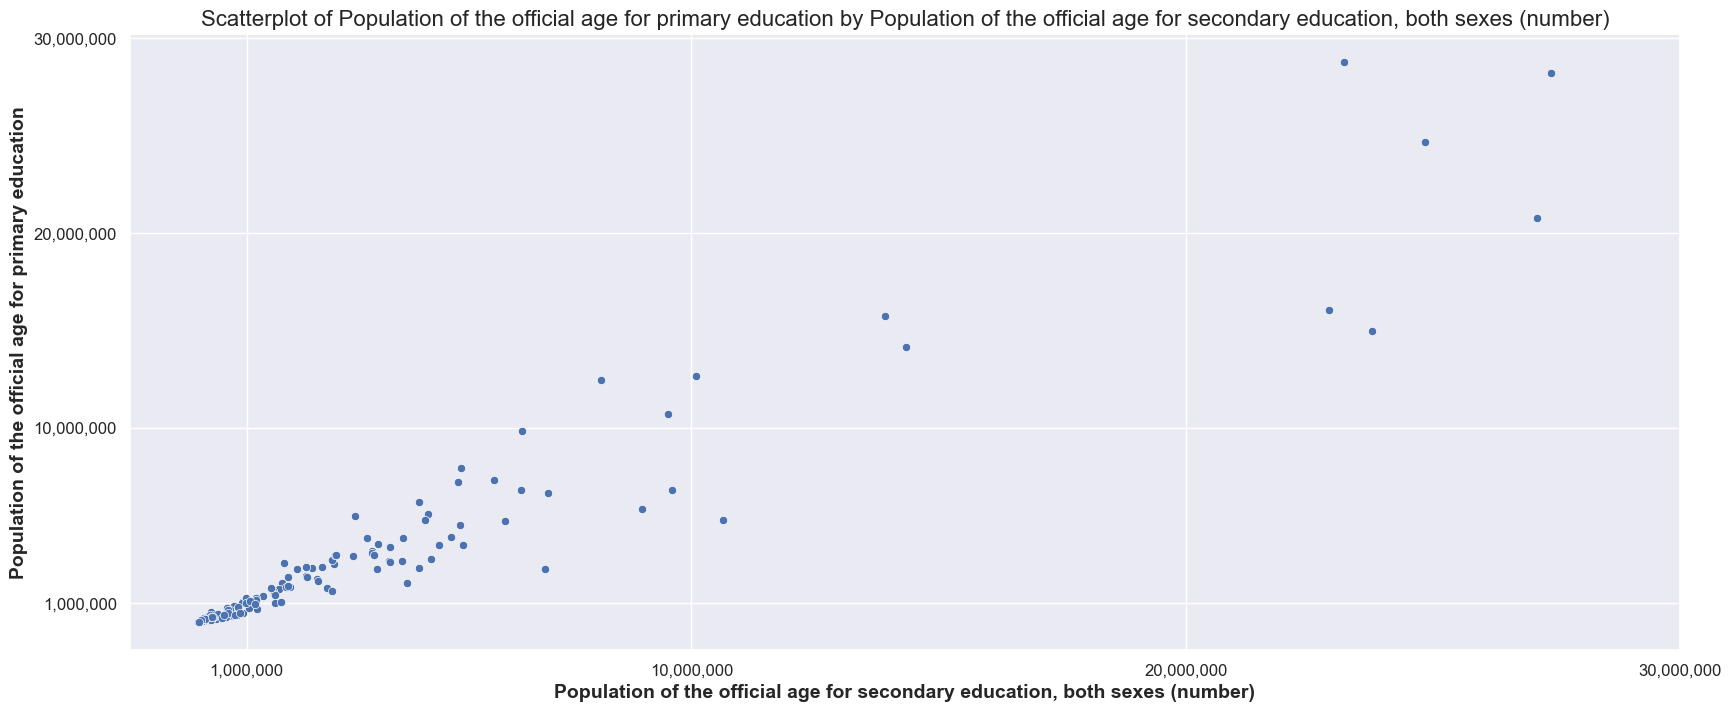

In [241]:
# Créer un sous-echantillon pour 2014
mask = (echantillon_pivoted['Year'] == '2014') & (echantillon_pivoted['Country Name'] != 'China') & (echantillon_pivoted['Country Name'] != 'India')
sous_echantillon = echantillon_pivoted.loc[mask]

# créer le diagramme de dispersion
plt.figure(figsize=(20, 8))
sns.scatterplot(data=sous_echantillon, x='Population of the official age for secondary education, both sexes (number)', y='Population of the official age for primary education, both sexes (number)')

# personnaliser le graphique
plt.title('Scatterplot of Population of the official age for primary education' + ' by Population of the official age for secondary education, both sexes (number)', fontsize=16)
plt.xlabel('Population of the official age for secondary education, both sexes (number)', fontsize=14, fontweight='bold')
plt.ylabel('Population of the official age for primary education', fontsize=14, fontweight='bold')

graduations = [1000000, 10000000, 20000000, 30000000]
plt.xticks(graduations, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations])
plt.yticks(graduations, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations])

plt.grid(True)

plt.show()

#### 4.3.2.2 - Coefficient de corrélation de Pearson

In [243]:
coef_pearson = st.pearsonr(sous_echantillon["Population of the official age for secondary education, both sexes (number)"],sous_echantillon["Population of the official age for primary education, both sexes (number)"])[0]
covariance = np.cov(sous_echantillon["Population of the official age for secondary education, both sexes (number)"],sous_echantillon["Population of the official age for primary education, both sexes (number)"],ddof=0)[1,0]

print("Coefficient de Pearson =", round(coef_pearson, 2))

Coefficient de Pearson = 0.96


Le coefficient de Pearson est assez proche de 1, ce qui indique une corrélation positive entre ces 2 variables. Plus l'une des 2 variables est grande, plus l'autre est grande.

### 4.3.3 - Entre "Internet Users" et "GDP per capita"

#### 4.3.3.1 - diagramme de dispersion

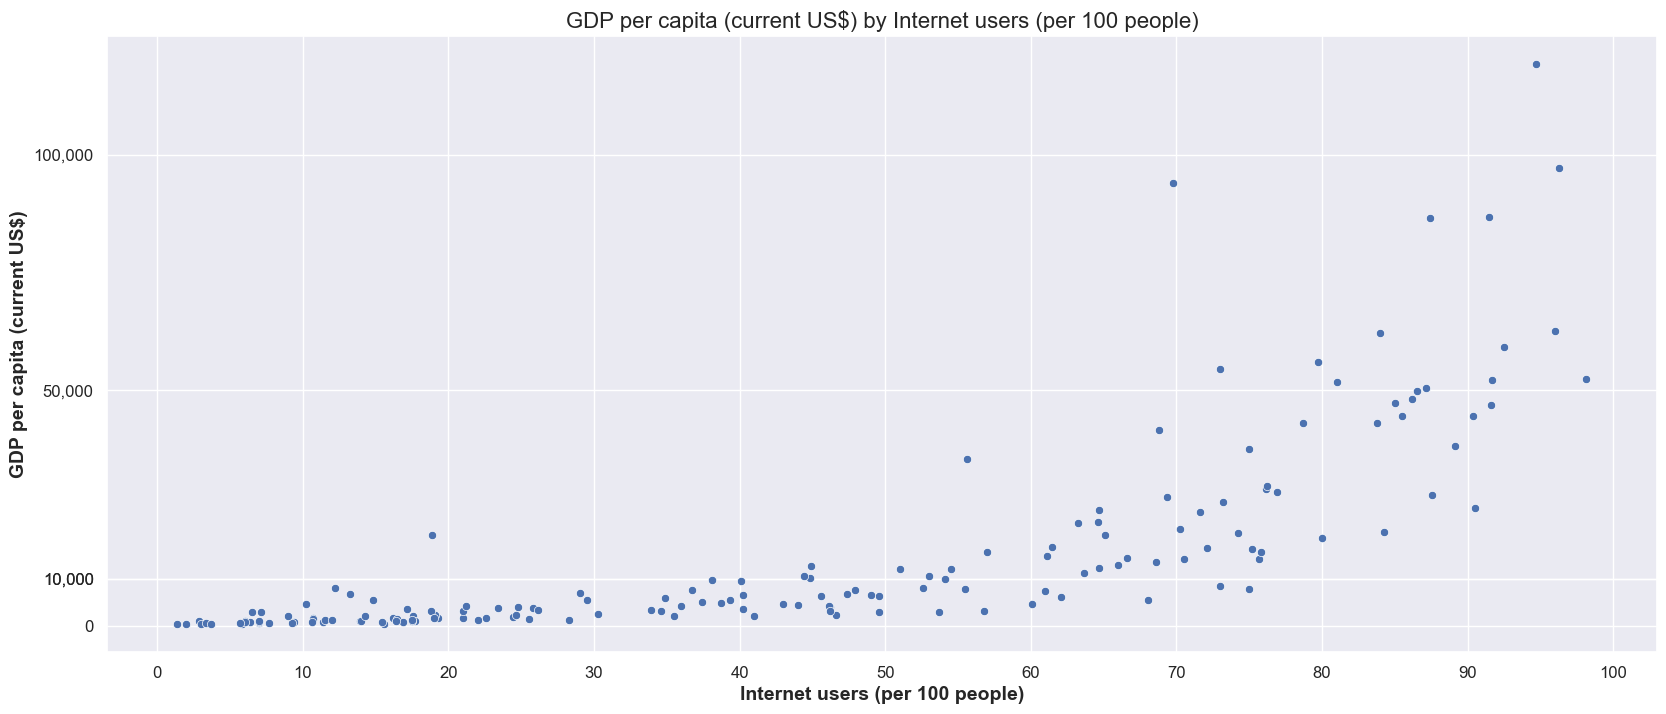

In [247]:
# Créer un sous-echantillon pour 2014
mask = (echantillon_pivoted['Year'] == '2014')
sous_echantillon = echantillon_pivoted.loc[mask]

# créer le diagramme de dispersion
plt.figure(figsize=(20, 8))
sns.scatterplot(data=sous_echantillon, x='Internet users (per 100 people)', y='GDP per capita (current US$)')

# personnaliser le graphique
plt.title('GDP per capita (current US$)' + ' by Internet users (per 100 people)', fontsize=16)
plt.xlabel('Internet users (per 100 people)', fontsize=14, fontweight='bold')
plt.ylabel('GDP per capita (current US$)', fontsize=14, fontweight='bold')

graduations_x = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
graduations_y = [0, 10000, 50000, 100000, 10000]
plt.xticks(graduations_x, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations_x])
plt.yticks(graduations_y, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations_y])

plt.grid(True)

plt.show()

#### 4.3.3.2 - Coefficient de corrélation de Pearson

In [249]:
coef_pearson = st.pearsonr(sous_echantillon["GDP per capita (current US$)"],sous_echantillon["Internet users (per 100 people)"])[0]

print("Coefficient de Pearson =", round(coef_pearson, 2))

Coefficient de Pearson = 0.75


Le coefficient de Pearson est positif, et au-dessus de 0,70, donc fort, sans être très fort. Il existe donc une corrélation entre ces 2 variables

### 4.3.4 - Entre "GDP per Capita" et "Unemployment, total"

#### 4.3.4.1 - diagramme de dispersion

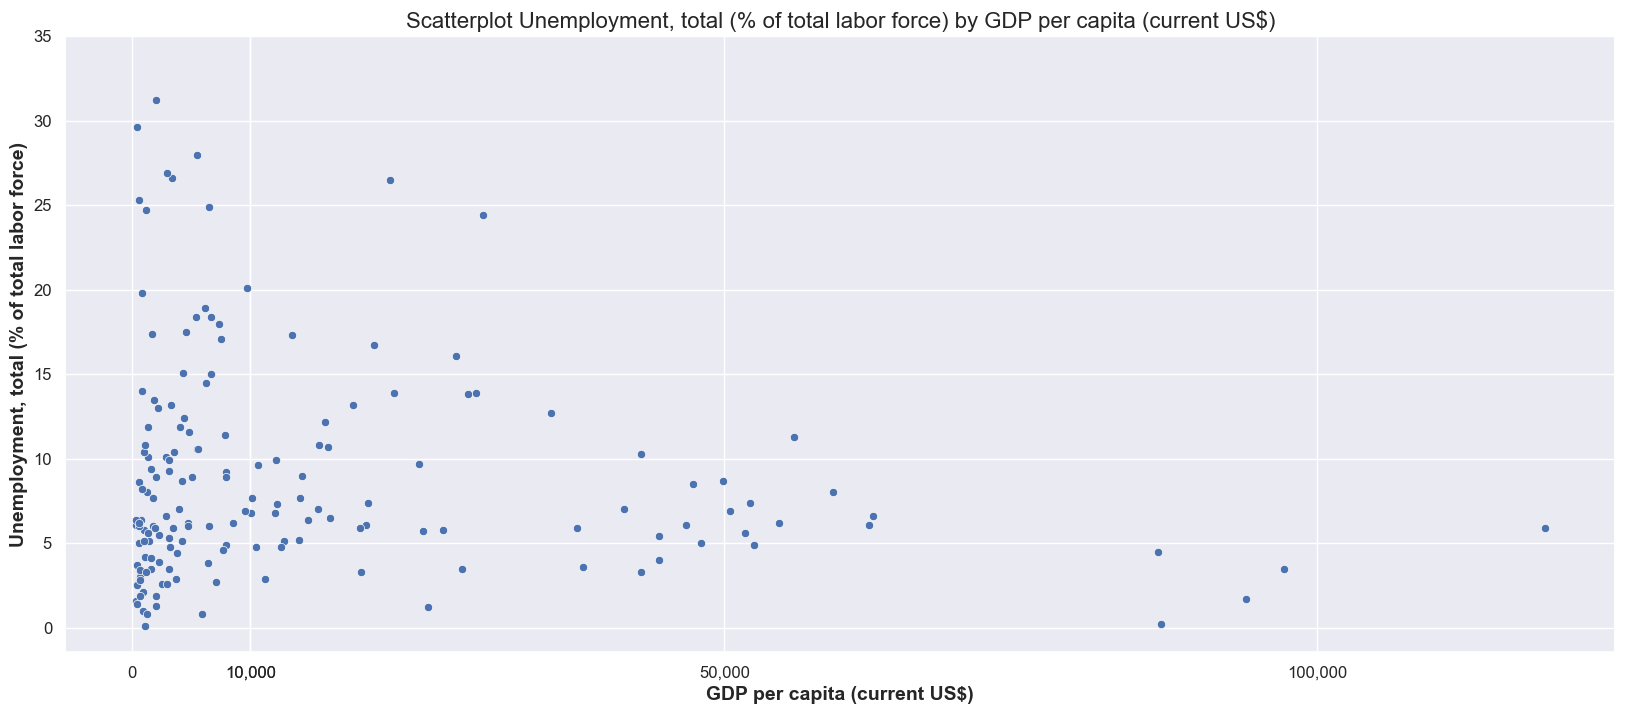

In [253]:
# Créer un sous-echantillon pour 2014
mask = (echantillon_pivoted['Year'] == '2014')
sous_echantillon = echantillon_pivoted.loc[mask]

# créer le diagramme de dispersion
plt.figure(figsize=(20, 8))
sns.scatterplot(data=sous_echantillon, x='GDP per capita (current US$)', y='Unemployment, total (% of total labor force)')

# personnaliser le graphique
plt.title('Scatterplot Unemployment, total (% of total labor force)' + ' by GDP per capita (current US$)', fontsize=16)
plt.xlabel('GDP per capita (current US$)', fontsize=14, fontweight='bold')
plt.ylabel('Unemployment, total (% of total labor force)', fontsize=14, fontweight='bold')

graduations_y = [0, 5, 10, 15, 20, 25, 30, 35]
graduations_x = [0, 10000, 50000, 100000, 10000]
plt.xticks(graduations_x, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations_x])
plt.yticks(graduations_y, fontsize=12, labels=[formattedEntire(graduation) for graduation in graduations_y])

plt.grid(True)

plt.show()

#### 4.3.4.2 - Coefficient de corrélation de Pearson

In [255]:
coef_pearson = st.pearsonr(sous_echantillon["GDP per capita (current US$)"],sous_echantillon["Unemployment, total (% of total labor force)"])[0]

print("Coefficient de Pearson =", round(coef_pearson, 2))

Coefficient de Pearson = -0.14


Le coefficient de Pearson est proche de 0. Il n'y a donc aucune corrélation entre ces 2 variables.

# 5 - Bilan

## 5.1 - Scoring final (2014)
  
Liste des variables retenues pour l’évaluation finale :
- GDP per capita (current US$),
- Internet users (per 100 people),
- Population, total,
- Population growth (annual %),
- Unemployment, total (% of total labor force)

Pour l’évaluation des pays, on discrétisera ces 5 variables en 10 valeurs de 1 à 10.
10 sera la meilleure note. 1 sera la plus mauvaise note.
On ajoutera un coefficient de 2 pour l’Internet Users car il s’agit d’un critère indispensable pour avoir la meilleure
couverture. La Valeur 2 permet de compenser les 2 variables démographiques et les 2 variables économiques.t les 2 variables économiques.

### 5.1.1 - Préparation du dataframe

In [260]:
# Discrétiser la variable GDP per capita du dataframe

# Définir les bornes
bins = [0, 12204, 24095, 35987, 47878, 59769, 71660, 83552, 95443, 107334, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Discrétiser la colonne 'GDP_per_capita'
echantillon_pivoted['score_GDP_per_capita'] = pd.cut(echantillon_pivoted['GDP per capita (current US$)'], bins=bins, labels=labels, right=False)

In [261]:
# Discrétiser la variable Internet users du dataframe

# Définir les bornes
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Discrétiser la colonne 'Internet users (per 100 people)'
echantillon_pivoted['score_Internet_users'] = pd.cut(echantillon_pivoted['Internet users (per 100 people)'], bins=bins, labels=labels, right=False)

In [262]:
# Discrétiser la variable Population growth du dataframe

# Définir les bornes
bins = [-2, -0.8, 0, 1.6, 2.4, 3.2, 4.1, 4.9, 5.7, 6.5, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Discrétiser la colonne 'Population growth (annual %)'
echantillon_pivoted['score_Population_growth'] = pd.cut(echantillon_pivoted['Population growth (annual %)'], bins=bins, labels=labels, right=False)

In [263]:
# Discrétiser la variable Population total du dataframe

# Définir les bornes
bins = [0, 200000, 500000, 1000000, 5000000, 10000000, 50000000, 100000000, 400000000, 1000000000, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Discrétiser la colonne 'Population, total'
echantillon_pivoted['score_Population_total'] = pd.cut(echantillon_pivoted['Population, total'], bins=bins, labels=labels, right=False)

In [264]:
# Discrétiser la variable Unemployment, total (% of total labor force) du dataframe

# Définir les bornes
bins = [0, 4, 6, 8, 10, 12, 14, 16, 25, 35, float('inf')]
labels = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# Discrétiser la colonne 'Unemployment, total (% of total labor force)'
echantillon_pivoted['score_Unemployment'] = pd.cut(echantillon_pivoted['Unemployment, total (% of total labor force)'], bins=bins, labels=labels, right=False)
echantillon_pivoted.head()

Indicator Name Country Name            Region  Year  \
0               Afghanistan        South Asia  2005   
1               Afghanistan        South Asia  2010   
2               Afghanistan        South Asia  2014   
3                   Albania  Europe (hors UE)  2005   
4                   Albania  Europe (hors UE)  2010   

Indicator Name  GDP per capita (current US$)  \
0                                 250.294130   
1                                 553.300289   
2                                 612.069651   
3                                2709.142931   
4                                4094.358832   

Indicator Name  Gross outbound enrolment ratio, all regions, both sexes (%)  \
0                                                         0.15583             
1                                                         0.31369             
2                                                             NaN             
3                                                         5.90823             
4                                                         8.48007             

Indicator Name  Internet users (per 100 people)  Population growth (annual %)  \
0                                      1.224148                      3.870470   
1                                      4.000000                      2.812617   
2                                      7.000000                      3.183201   
3                                      6.043891                     -0.511790   
4                                     45.000000                     -0.496462   

Indicator Name  Population of the official age for primary education, both sexes (number)  \
0                                                       4145879.0                           
1                                                       5003108.0                           
2                                                       5564280.0                           
3                                                        234522.0                           
4                                                        227021.0                           

Indicator Name  Population of the official age for secondary education, both sexes (number)  \
0                                                       3292878.0                             
1                                                       3839021.0                             
2                                                       4676453.0                             
3                                                        529872.0                             
4                                                        402516.0                             

Indicator Name  Population of the official age for tertiary education, both sexes (number)  \
0                                                       2304393.0                            
1                                                       2490352.0                            
2                                                       3034517.0                            
3                                                        271360.0                            
4                                                        274639.0                            

Indicator Name  Population, total  \
0                      25070798.0   
1                      28803167.0   
2                      32758020.0   
3                       3011487.0   
4                       2913021.0   

Indicator Name  Unemployment, total (% of total labor force)  \
0                                                        8.5   
1                                                        8.1   
2                                                        8.6   
3                                                       13.8   
4                                                       14.2   

Indicator Name                                   Income Group  \
0                                        Pays à fa

In [265]:
# Ajout d'une colonne totale des scores
echantillon_pivoted['score_total'] = (
    pd.to_numeric(echantillon_pivoted['score_Internet_users']) +
    pd.to_numeric(echantillon_pivoted['score_GDP_per_capita']) +
    pd.to_numeric(echantillon_pivoted['score_Population_growth']) +
    pd.to_numeric(echantillon_pivoted['score_Population_total']) +
    pd.to_numeric(echantillon_pivoted['score_Unemployment'])
)

In [266]:
# Réduction du dataframe à l'année 2014 et réduction aux colonnes concernées
mask = (echantillon_pivoted['Year'] == '2014')
sous_echantillon = echantillon_pivoted.loc[mask, ['Country Name', 'Region', 'score_Internet_users', 'score_GDP_per_capita', 'score_Unemployment', 'score_Population_total', 'score_Population_growth', 'score_total']]
sous_echantillon.head()

Indicator Name Country Name                      Region score_Internet_users  \
2               Afghanistan                  South Asia                    1   
5                   Albania            Europe (hors UE)                    7   
8                   Algeria  Middle East & North Africa                    3   
17                   Angola          Sub-Saharan Africa                    2   
23                Argentina   Latin America & Caribbean                    7   

Indicator Name score_GDP_per_capita score_Unemployment score_Population_total  \
2                                 1                  7                      6   
5                                 1                  3                      4   
8                                 1                  6                      6   
17                                1                  8                      6   
23                                2                  8                      6   

Indicator Name score_Population_growth  score_total  
2                                    5         20.0  
5                                    2         17.0  
8                                    4         20.0  
17                                   6         23.0  
23                                   3         26.0

### 5.1.2 - Heatmap de scoring région "European union'

In [268]:
mask = sous_echantillon['Region'] == 'European union'
sous_echantillon_ue = sous_echantillon.loc[mask, ['Country Name', 'score_Internet_users', 'score_GDP_per_capita', 'score_Unemployment', 'score_Population_total', 'score_Population_growth', 'score_total']]
sous_echantillon_ue = sous_echantillon_ue.sort_values(by='score_total', ascending=False)
# Définir la colonne 'Country Name' comme index pour utiliser comme noms de lignes
sous_echantillon_ue.set_index('Country Name', inplace=True)

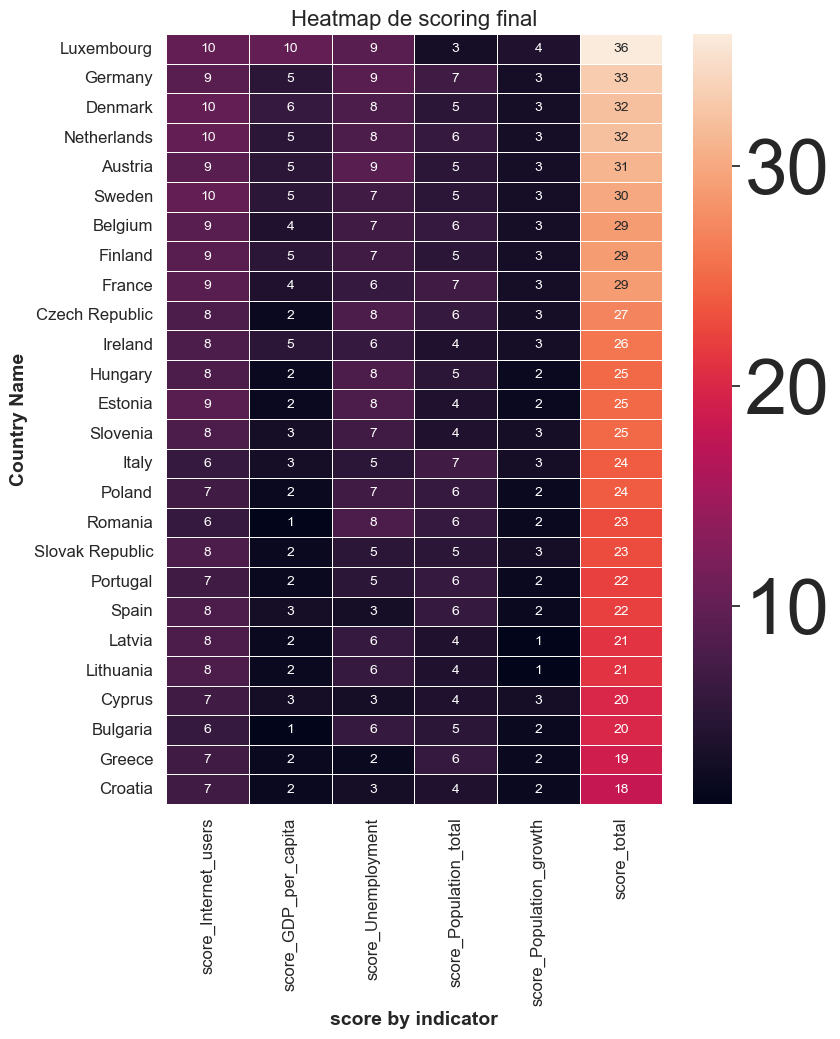

In [432]:
# Créer la heatmap
plt.figure(figsize=(8,10))
sns.heatmap(sous_echantillon_ue, annot=True, annot_kws={"size":10}, linewidths=0.5, xticklabels=True, yticklabels=True)

# personnaliser le graphique
plt.title('Heatmap de scoring final', fontsize=16)
plt.xlabel('score by indicator', fontsize=14, fontweight='bold')
plt.ylabel('Country Name', fontsize=14, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Afficher la heatmap
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_16684\521786676.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Country Name', x='Internet users (per 100 people)', data=sous_echantillon, palette='viridis')


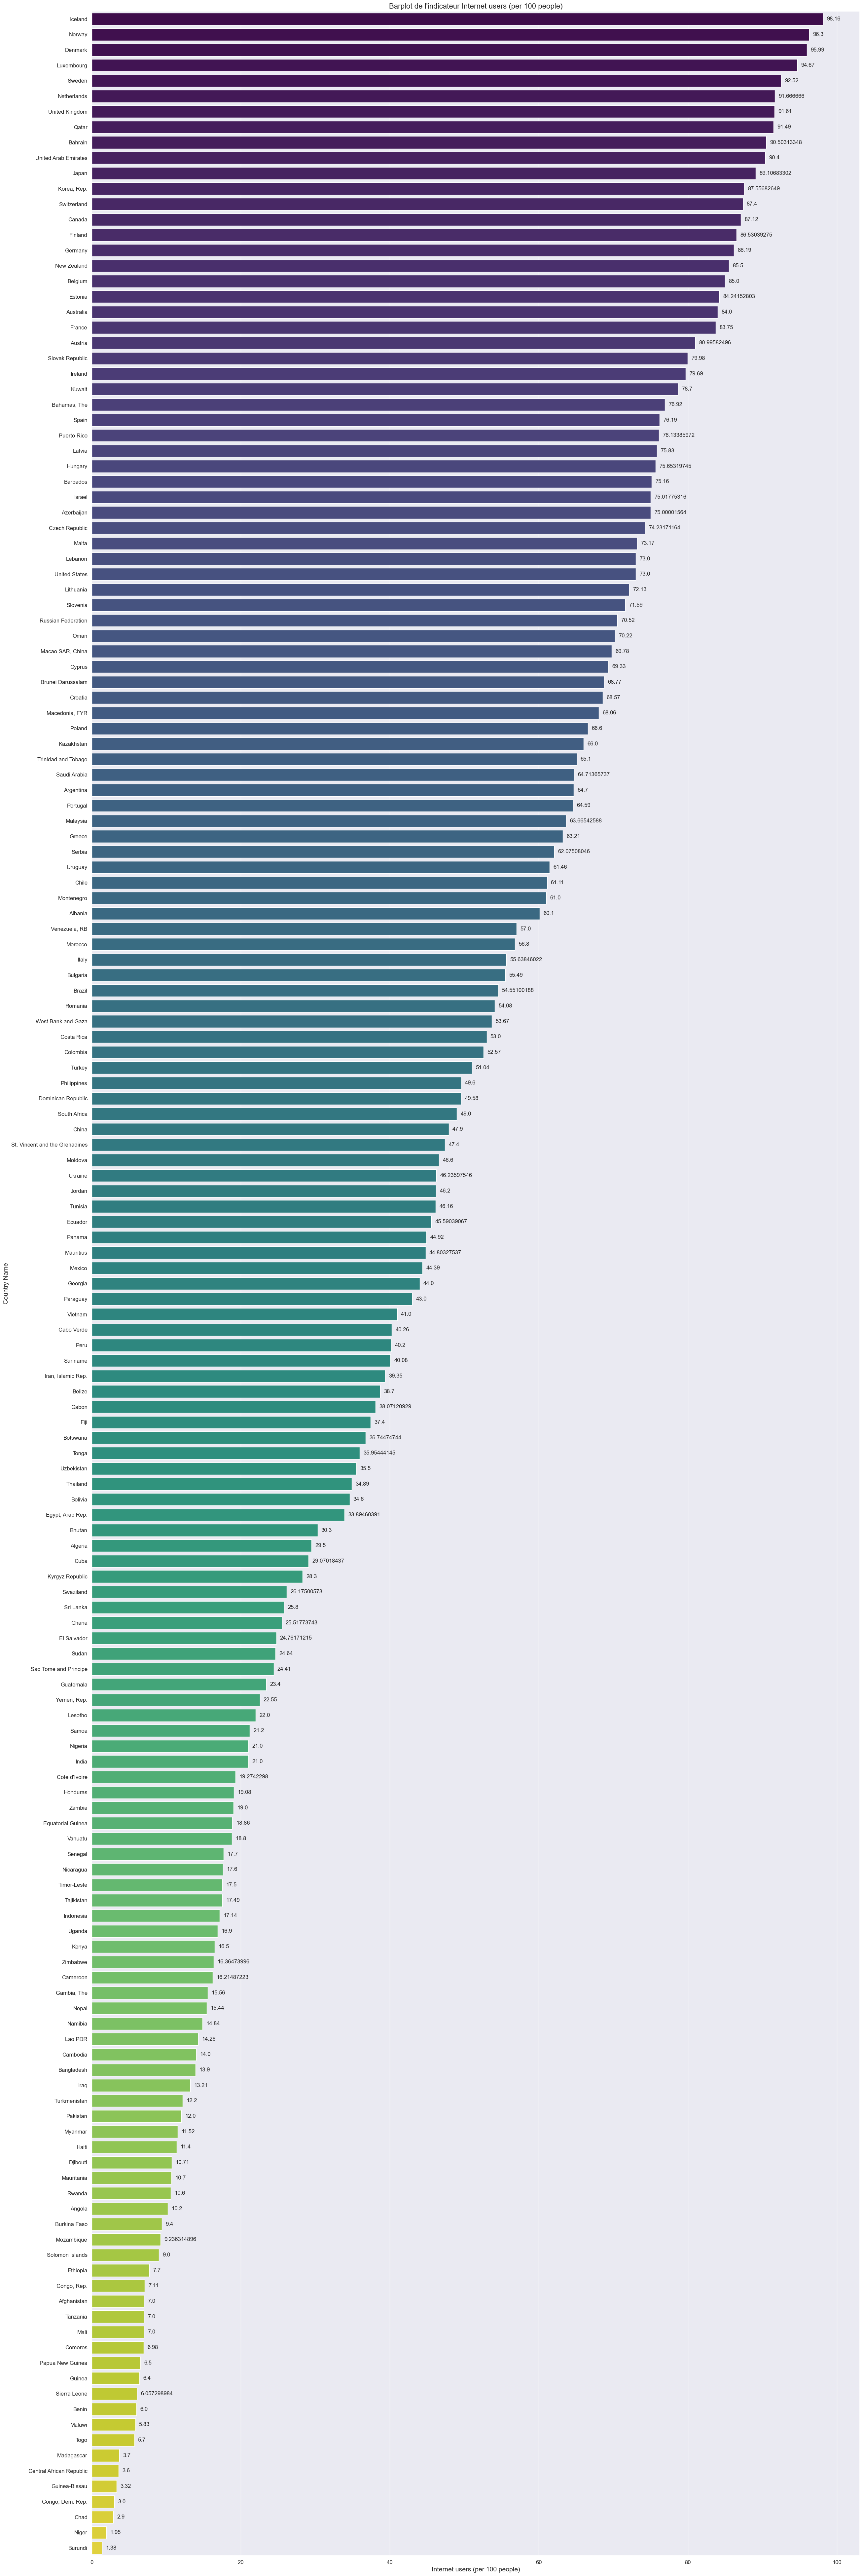

In [271]:
# Afficher la distribution par pays sous forme de graphique à barres

# Créer un sou_echantillon trié de la plus grande valeur à la plus petite
mask = echantillon_pivoted['Year'] == '2014'
sous_echantillon = echantillon_pivoted[mask]
sous_echantillon = sous_echantillon.sort_values(by='Internet users (per 100 people)', ascending=False)

plt.figure(figsize=(30,100))

# Créer le barplot
ax = sns.barplot(y='Country Name', x='Internet users (per 100 people)', data=sous_echantillon, palette='viridis')

# Ajouter des annotations à droite des barres
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.5, p.get_y() + p.get_height() / 2,  # Positionnement à droite de la barre
            f'{width}', ha='left', va='center', fontsize=12)  # Alignement à gauche pour que le texte soit à droite de la barre

# Ajouter des titres et des labels
plt.title("Barplot de l'indicateur Internet users (per 100 people)", fontsize=16)
plt.xlabel('Internet users (per 100 people)', fontsize=14)
plt.ylabel('Country Name', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Afficher le graphique
plt.show()